# What's this?

This notebook describes an analysis of measurements taken from a Core417I board (the one like [Core 407I](http://www.waveshare.com/wiki/Core407I) but featuring a version of the STM32F4 chip with HW crypto accelerator). The board together with a custom sofware package is available from Riscure as a training target dubbed [Piñata](https://www.riscure.com/product/pinata-training-target/). Since vanilla Piñata software doesn't do HMAC SHA1, I (@ceesb) cut and paste some of ST's reference code. Then, I added a command on the Piñata that feeds back a SHA1 output into the HMAC SHA1 computation so that Piñata does many HMACs per input sent from the PC:

```
i = 0
iterations = MSB_UINT32(readfromserial(4))
input = readfromserial(20)
for i < iterations:
   triggerUP()
   output = HMACSHA1(input)
   triggerDOWN()
   input = SHA1(input)
   i++
writetoserial(output)
```

It can be run from the PC by sending a message with command 0xdf:

```
=>   df <UINT32 MSB iterations> <20 bytes MSB input>
<=   <20 bytes output of last HMAC SHA1 iteration>
```

Send me (@ceeesb) a ping for the binary.

# TL;DR

Attack doesn't perform very well, key of inner SHA cannot be recovered. Outer SHA not tried.

# Acquisition

[Riscure EM probe (LS)](https://www.riscure.com/product/em-probe-station/) over the chip, right in the middle.

Picoscope in rapid block mode, 4096 encryptions per scope fetch.  On receiving the 4096 traces on the PC we compute the inputs and store them in a trace set. Since we know the key, we verify that the last HMAC output of the Piñata matches with what we expect, so we know for sure all traces match the inputs. Obviously the acquisition is done with a Julia script, similar to piposcope.jl in Jlsca's example folder, but send me a ping if you want it.

Acquired > 1M traces of 3900 samples at 1Gs/s in *less than 15 minutes*. 3.5Gb 7-zipped trace set [here](https://drive.google.com/open?id=0B-My9BsChztIM21sdWxWRWRrZGs).

# Attack definition

The attack is the same as described in Section 3.4 in this [paper](https://link.springer.com/chapter/10.1007/978-3-319-25915-4_19) by Belaid and others.

We're going to take a look at SHA1 HMAC using the input. The key itself cannot be recovered since there is no differential data being mixed with the key. The two SHA1 states themselves are sufficient to create arbitrary HMACs. One can also attack the outer SHA1 using an output attack, but this is not shown here (although [Jlsca](https://github.com/Riscure/Jlsca) implements this attack too). We'll only be looking at the inner SHA1.

To explain this attack, we first define some terms:
* a0,b0,c0,d0,e0: the 160-bit SHA1 state we are to recover, in 5 32-bit numbers
* W0 - W3: the attacker controlled and known 32-bit inputs
* T0-T3: the value of T for rounds 0-3
* F0-F3: the output value of the F function for rounds 0-3
* Rot(x,a): rotates x left by a bits
* Ch(a,b,c) = (a & b) XOR (~a & c)

We then roll out first 4 rounds of the inner SHA1 loop in the terms defined above (constants omitted):
```
T0 = Rot(a0, 5) + Ch(b0, c0, d0) + e0 + W0
F0 = Ch(b0, c0, d0)

T1 = Rot(T0, 5) + Ch(a0, Rot(b0, 30), c0) + d0 + W1
F1 = Ch(a0, Rot(b0, 30), c0)

T2 = Rot(T1, 5) + Ch(T0, Rot(a0, 30), Rot(b0, 30)) + c0 + W2
F2 = Ch(T0, Rot(a0, 30), Rot(b0, 30))

T3 = Rot(T2, 5) + Ch(T1, Rot(T0, 30), Rot(a0, 30)) + Rot(b0, 30) + W3
F3 = Ch(T1, Rot(T0, 30), Rot(a0, 30))
```

The SHA1 input attack steps are then:
1. DPA attack on 32-bit modular addition to guess "Rot(a0, 5) + Ch(b0, c0, d0)" and predict "T0" since we know "W0" 
2. DPA attack on 32-bit modular addition to guess "Ch(a0, Rot(b0, 30), c0) + d0" and predict "T1" since we know "W1" and "Rot(T0, 5)" 
3. DPA attack on Ch function to guess "Rot(a0, 30)" and predict "F3" since we know "T1" and "Rot(T0, 30)" 
4. DPA attack on Ch function to guess "Rot(b0, 30)" and predict "F2" since we know "T0" and "Rot(a0, 30)"
5. DPA attack on 32-bit modular addition to guess "c0" and predict "T2" since we know "Rot(T1, 5) + Ch(T0, Rot(a0, 30), Rot(b0, 30))" and "W2" 

These 5 attacks allow us to recover the secret SHA1 state a0,b0,c0,d0,e0.  DPA attacks 1-5 are recovering 32-bit numbers and in order to enumerate the guesses we need to split the attacks up in smaller (typically 8-bits or less) attack so that the key space can be enumerated. How to split up the attacks is described in this [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.94.7333&rep=rep1&type=pdf) by Lemke, Schramm and Paar. Note that DPA attack n depends on the output of attack n-1 for n > 1. In Jlsca terms we'd call these attack *phases*. For DPA 3 and 4 multiple parts of the secret can be recovered simulteaneously since they're independent. Within a *phase* you can therefore have multiple *targets*. 

In Jlsca, the SHA1 attack is split up in 14 phases and targets as follows:

* Phase 1, target 1: byte 0 of DPA 1
* Phase 2, target 1: byte 1 of DPA 1
* Phase 3, target 1: byte 2 of DPA 1
* Phase 4, target 1: byte 3 of DPA 1
* Phase 5, target 1: byte 0 of DPA 2
* Phase 6, target 1: byte 1 of DPA 2
* Phase 7, target 1: byte 2 of DPA 2
* Phase 8, target 1: byte 3 of DPA 2
* Phase 9, targets 1-8, 8 nibbles of DPA 3. The reason we attack nibbles is that we constructed the Ch target function to take 2 4-bits inputs and produces one 4-output. We can easily conditionally average on 2 4-bit (8-bits) of input, but not much more than that.
* Phase 10, targets 1-4, 4 bytes of DPA 4. The reason we *don't* attack nibbles here is that one of the Ch target function inputs, Rot(b0,30), is a constant. Since it's constant, it doesn't affect the number of averages so we can take 8-bits of the T0 input to Ch and guess an 8-bits output.
* Phase 11, target 1: byte 0 of DPA 5
* Phase 12, target 1: byte 1 of DPA 5
* Phase 13, target 1: byte 2 of DPA 5
* Phase 14, target 1: byte 3 of DPA 5



Note also that this attack only uses the first 12 bytes of the input! (W0, W1 and W2)

Note also that for HMAC we need to perform the SHA1 attack two times, but we don't in this notebook. 

In [1]:
# add two local workers in addition to the master process
addprocs(2)

# import the necessary stuff on each process
@everywhere begin
    using Jlsca.Trs
    using Jlsca.Sca
    using Jlsca.Sca.sca
    using Jlsca.Sca.hw
    using Jlsca.Sha
    using Jlsca.Align
    using ProgressMeter
    
    import Jlsca.Sca.leak
end

# plotting libs are local only
using PyPlot.plot,PyPlot.figure,PyPlot.title,PyPlot.subplots

using Base.Threads

@printf("#procs:              %d\n", nprocs())
@printf("#workers:            %d\n", nworkers())
@printf("#threads per worker: %d\n", nthreads())

INFO: Recompiling stale cache file /data/home/ceesb/.julia/lib/v0.6/Jlsca.ji for module Jlsca.
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#procs:              3
#workers:            2
#threads per worker: 10


In [2]:
@everywhere begin
    # for testing if this notebook is working correctly
    emulation = false
    
    if emulation
        trs = InspectorTrace("../jlsca/shatraces/sha1_67452301efcdab8998badcfe10325476c3d2e1f0.trs")
        # trace set samples are intermediates, not yet leakages!
        # convert the intermediates to the necessary leakages for this attack to work
        addSamplePass(trs, x -> hw.(x))
        # 16 bytes input, 20 bytes output in this trace set 
        inputLength = 16
        # where the peaks are
        rangeOfInterest = 1:200
    else
        trs = InspectorTrace("pinatahmacsha1.trs")
        # a dirty hack to make Jlsca interpret this data as signed (don't change this to types with different sizes, 
        # or bad fail)
        trs.sampleType = Int8
        # only 20 inputs in this trace set, there's no output
        inputLength = 20
        # where the inner SHA1 is (how this region is determined is explained below)
        rangeOfInterest = 900:2100
    end
    
    # used by function correlateDataSamples defined later
    getTrs() = trs
    
    # set to less if you have no time 
    len = length(trs)
    interval = 50000
end

Opened pinatahmacsha1.trs, #traces 1228800, #samples 3900 (UInt8), #data 20
	From worker 3:	Opened pinatahmacsha1.trs, #traces 1228800, #samples 3900 (UInt8), #data 20
	From worker 2:	Opened pinatahmacsha1.trs, #traces 1228800, #samples 3900 (UInt8), #data 20


# Alignment

First things first, we need some alignment.

In [3]:
# sets up a static align pass (not for the emulation)

if !emulation 
    @everywhere begin
        popSamplePass(trs)

        # how much we are willing to move to find an optimum correlation with the reference
        maxShift = 100
        # where you want the reference to be placed in the result. Setting this to 1 will place it at the beginning.
        referenceOffset = 900
        # how long the reference is
        referenceLength = 600
        # the reference data itself. Can come from anywhere, but here we extract it from one of traces
        reference = trs[1][2][referenceOffset:referenceOffset+referenceLength-1]
        # drop traces that correlate less than this minimum
        corvalMin = 0.0
        # use the FFTW correlator with the above settings
        alignstate = CorrelationAlignFFT(reference, referenceOffset, maxShift)
        # caches the shift and correlation values, so that in a given process it's only computed once for each trace
        alignpass = AlignPass(alignstate, length(trs), corvalMin)

        addSamplePass(trs, alignpass)
    end
end

We'll plot some trace in the same window to show the effect of the alignment.

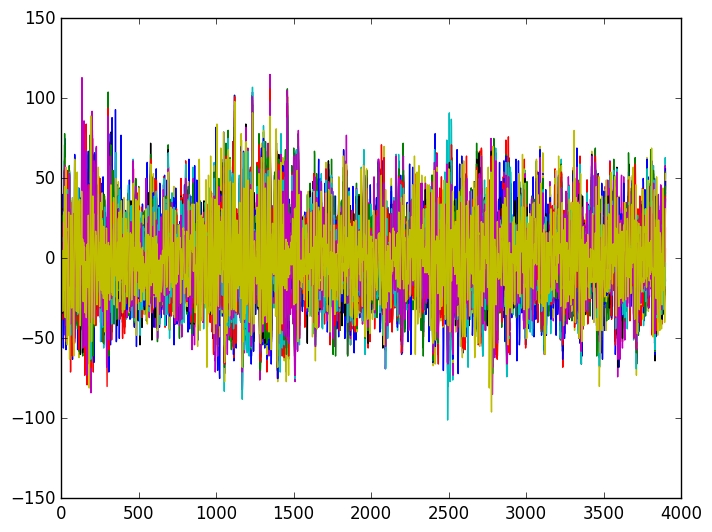

In [4]:
# show a few traces in the same window
for i in 1:20
    plot(trs[i][2])
end

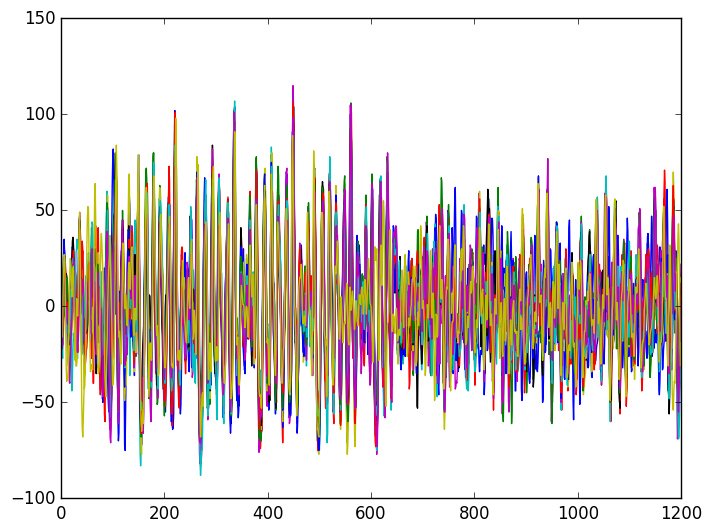

In [5]:
# zoomed in to check the alignment
for i in 1:20
    plot(trs[i][2][rangeOfInterest])
end


# Finding your inner SHA1

Now we need to find where the inner SHA1 is. We'll use input/output correlation. First we need to define some functions to compute this under a known key. We also define the function that does the correlation (parallel and threaded, just for fun).

In [6]:
# helper functions for the known key analysis

@everywhere begin
    # will contain the secret inner SHA1 state, used for correlating with intermediates under known key scenario
    # (i.e. known key analysis)
    innerstate = sha1init()
    if emulation
        knownkeyinner = [0x00 for i in 1:20]
        knownkeyinner = hex2bytes("67452301efcdab8998badcfe10325476c3d2e1f0")
    else
        # the master key used for HMAC SHA1 on the pinata
        key = hex2bytes("cafebabedeadbeef0001020304050607cafebabedeadbeef")
        # the inner SHA1 key is derived from the master key by a hash
        innerkey = Sha.K0(key) .⊻ 0x36
        update(innerstate, innerkey)
        # the secret state of the inner SHA1, passed as a known key into the attack later
        knownkeyinner = reinterpret(UInt8, map(hton, innerstate.H))
        # will contain the secret inner SHA1 state, used for known key analysis later
        outerstate = sha1init()
        # the outer SHA1 key is derived from the master key by a hash        
        outerkey = Sha.K0(key) .⊻ 0x5c
        update(outerstate, outerkey)
        # the secret state of the outer SHA1
        knownkeyouter = reinterpret(UInt8, map(hton, outerstate.H))
    end

    # computes the output the inner SHA1, used for finding the relevant sample range
    function inneroutput(innerstate::Sha1state, msg::Vector{UInt8})
        state = deepcopy(innerstate)
        update(state, msg)
        return final(state)
    end

    # given the known inner SHA1 key computes the HD between 0,T0 T0,T1 T1,T2, T2,T3, used for spot finding
    function attackableHDT(msg::Vector{UInt8})
        data = zeros(UInt32, 4)
        cnt = Ref(1)
        innerstate2 = deepcopy(innerstate)
        update(innerstate2, msg[1:inputLength])
        final(innerstate2, (x,y) -> x == "T" && cnt.x <= length(data) ? (data[cnt.x] = y; cnt.x += 1) : nothing)
        xor = 0x00000000
        for i in 1:length(data)
            tmp = data[i]
            data[i] ⊻= xor
            xor = tmp
        end
        return map(hton, data)
    end
    
    # given the known inner SHA1 key computes the HD between T0,W0 T1,W1 T2,W2, T3,W3
    # our trace set doesn't leak this though .. used for spot finding
    function attackableHDIn(msg::Vector{UInt8})
        data = zeros(UInt32, 4)
        cnt = Ref(1)
        innerstate2 = deepcopy(innerstate)
        update(innerstate2, msg[1:inputLength])
        final(innerstate2, (x,y) -> x == "T" && cnt.x <= length(data) ? (data[cnt.x] = y; cnt.x += 1) : nothing)
        for i in 1:length(data)
            data[i] ⊻= Sca.getInt(i,msg)
        end
        return map(hton, data)
    end
end


# Helper for computing correlation for known key analysis. We don't define this in the @everwhere macro, since we 
# only need it on the  master process. It uses IncrementalCovarianceTiled which is threaded, and macro @parallel to
# run it on different processes. Used for spot finding
# TODO move this into Jlsca
function correlateDataSamples()
    @everywhere begin 
        ic = IncrementalCovarianceTiled(length(trs[1][1]), length(trs[1][2]))
        getIc() = ic
    end
    
    @sync @parallel for t in 1:len
        trs = getTrs()
        ic = getIc()
        (data, samples) = trs[t]
        if length(data) == 0 || length(samples) == 0
            continue
        end
        add!(ic, data, samples)
    end
        
    
    for w in workers()
        if w != myid()
            add!(ic, @fetchfrom w getIc())
        end
    end
    
    C = getCorr(ic)
    return abs.(C)
end

correlateDataSamples (generic function with 1 method)

We first want to determine in time when the inner SHA1 computation is happening. The next code block compute the correlation of samples with the HW of the input, and then plot it. We'll see large spikes from around sample 900 onwards, which we will mark as the start of the inner SHA1.

In [7]:
# byte-wise HW of input correlated with samples
@everywhere begin
    addDataPass(trs, x -> Sca.hw.(x))
    addSamplePass(trs, x -> abs.(x))
end

@time C1 = correlateDataSamples()

@everywhere begin
    popDataPass(trs)
    popSamplePass(trs)
end

 77.015965 seconds (1.44 M allocations: 82.956 MiB, 0.05% gc time)


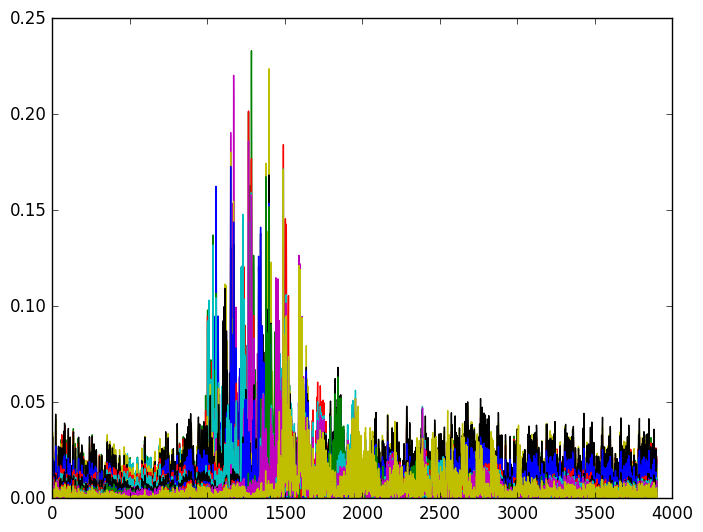

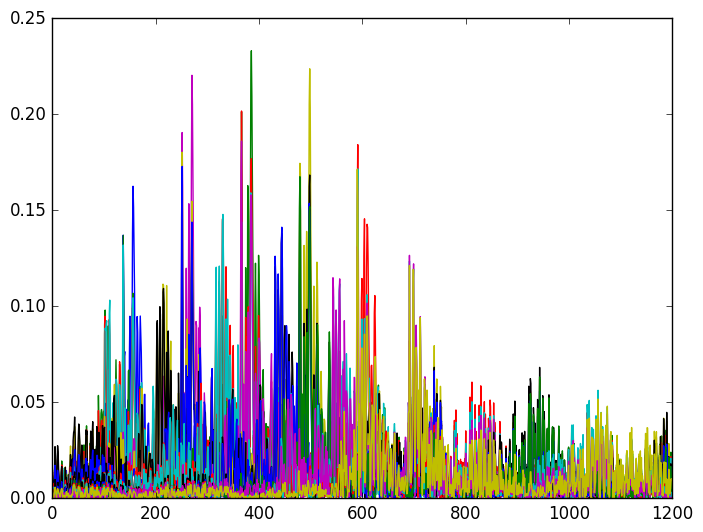

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7f619ebdb710>)

In [8]:
# overall picture of HW input correlation
plot(C1')
figure()

# zoomed in
plot(C1[:,rangeOfInterest]')
figure()


Now let's find the output of the inner SHA1. We'll correlate with HW of 32-bits at the time to get a bit stronger signal. We'll find two peaks, one around sample 2100 and one near the end at 3500. The last one is (probably) caused by the outer SHA1 overwriting the inner SHA1 output. We'll use 900:2100 as the range for the inner SHA1 computation.

In [9]:
# byte-wise HW of inner SHA1 output correlated with samples
@everywhere begin
    addDataPass(trs, x -> inneroutput(innerstate,x[1:inputLength]))
    addDataPass(trs, x -> Sca.hw.(reinterpret(UInt32, x)))
    addSamplePass(trs, x -> abs.(x))
end

@time C2 = correlateDataSamples()

@everywhere begin
    popDataPass(trs)
    popDataPass(trs)
    popSamplePass(trs)
end


 41.183566 seconds (155.68 k allocations: 14.760 MiB, 0.02% gc time)


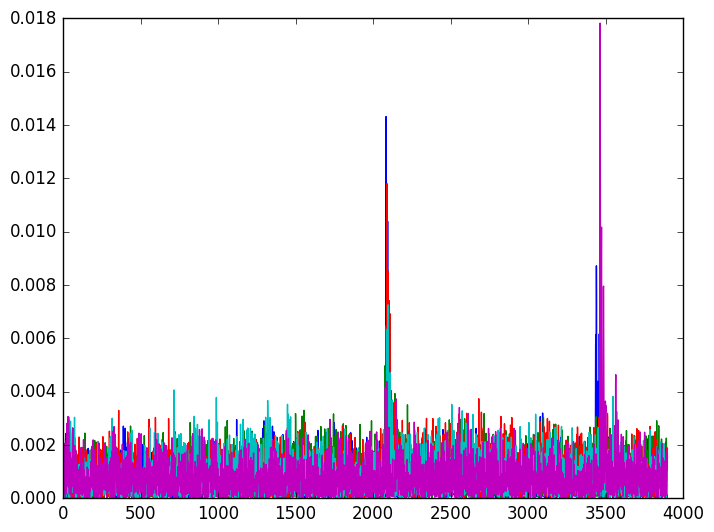

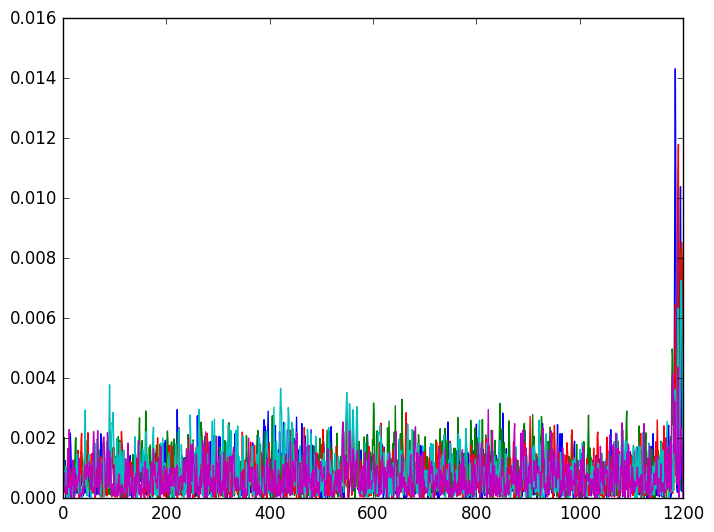

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7f619e9db550>)

In [10]:
# overall picture of HW SHA1 output correlation
plot(C2')
figure()

# zoomed in
plot(C2[:,rangeOfInterest]')
figure()

Now that we know where the inner SHA1 is, we define some functions to run the actual attack. We define a cond avg variant, and a inc cpa variant.

In [11]:
function allocateCbData(params::DpaAttack)
    phases = numberOfPhases(params.attack)
    leakages = numberOfLeakages(params.analysis)
    c = Vector{Vector{Vector{AbstractArray{Float64,2}}}}(phases)
    
    for phase in 1:phases
        targets = numberOfTargets(params.attack,phase)
        c[phase] = Vector{Vector{AbstractArray{Float64,2}}}(targets)
        
        for target in 1:targets
            c[phase][target] = Vector{AbstractArray{Float64,2}}(leakages)
        end
    end
    return c
end

@everywhere begin    
    # for saving the final correlation matrices (we get called for all the params.updateInterval, if any)
    function corrCb(cbData, phase::Int,targetOffset::Int,leakageIdx::Int,c::AbstractArray{Float64,2})
        # just save a pointer
        cbData[phase][targetOffset][leakageIdx] = c
    end
    
    type Div <: Leakage 
        a::UInt8
    end
    leak(a::Div, x::UInt8) = div(x,a.a)

    type Zero <: Leakage end
    leak(a::Zero, x::UInt8) = x == 0x0 ? 1 : 0

    type FF <: Leakage end
    leak(a::FF, x::UInt8) = x == 0xff ? 1 : 0

    type ID <: Leakage end
    leak(a::ID, x::UInt8) = x
end

function docondavg()
    attack = Sha1InputAttack()
    analysis = CPA()
    global condavgparams = DpaAttack(attack,analysis)
    condavgparams.scoresCallBack = Nullable((b,c,d,e) -> corrCb(condavgcorrMatrices,b,c,d,e))
    condavgparams.knownKey = Nullable(knownkeyinner)
#     condavgparams.phases = [1,2,3,4]
#     condavgparams.targetOffsets = [1]
    condavgparams.updateInterval = interval
    condavgparams.analysis.leakages= [HW()]
    
    global condavgcorrMatrices = allocateCbData(condavgparams)
    
    @everywhere addSamplePass(trs, x -> abs.(x[rangeOfInterest]))
    
    @everywhere setPostProcessor(trs, CondAvg(SplitByTracesBlock()))
    
    @time global condavgrankData = sca(DistributedTrace(), condavgparams, 1,len)
    
    @everywhere popSamplePass(trs)
end

function doinccpa()
    attack = Sca.Sha1InputAttack()
    analysis = IncrementalCPA()
    global inccpaparams = DpaAttack(attack,analysis)
    inccpaparams.scoresCallBack = Nullable((b,c,d,e) -> corrCb(inccpacorrMatrices,b,c,d,e))
    inccpaparams.knownKey = Nullable(knownkeyinner)
#     inccpaparams.phases = [1,2,3,4]
#     inccpaparams.targetOffsets = [1]
    inccpaparams.updateInterval = interval
    inccpaparams.analysis.leakages= [HW()]
        
    global inccpacorrMatrices = allocateCbData(inccpaparams)
    
    @everywhere addSamplePass(trs, x -> abs.(x[rangeOfInterest]))    
    
    @everywhere setPostProcessor(trs, IncrementalCorrelation(SplitByTracesBlock()))
    
    @time global inccparankData = sca(DistributedTrace(), inccpaparams, 1,len)
    
    @everywhere popSamplePass(trs)
end


doinccpa (generic function with 1 method)

We define some functions for plotting the results ...

In [12]:
using Jlsca.Sca.getTarget

# TODO move these plotting functions into Jlsca once they're stable

function plotScoresPerSample(corrMatrices,rankData,params,phase,target)
    totalplots = rankData.nrLeakages
    nrTraces = getNrConsumedRows(rankData,phase)[end]
    (fig,axes) = subplots(nrows=Int(ceil(totalplots/3)), ncols=(totalplots > 3 ? 3 : totalplots), figsize=(8, 4), sharey=false, squeeze=false)
    fig[:suptitle]("Scores per sample for phase $phase, target $target, \"$(getTarget(params,phase,target))\" @ $nrTraces traces, $(params.analysis)")
    kb = getCorrectKey(params,phase,target)
    f = 1
    for leakage in 1:rankData.nrLeakages
        cm = corrMatrices[phase][target][leakage]
        if isdefined(params.analysis, :leakages) 
            leakstr = string(params.analysis.leakages[leakage])
        else 
            leakstr = leakage
        end
        axes[f][:set_title]("$leakstr, (0x$(hex(kb)) in red)")
        (rows,cols) = size(cm)
        for i in 1:cols
            if i != kb+1
                axes[f][:plot](cm[:,i], color="grey")
            end
        end
        axes[f][:plot](cm[:,kb+1], color="red", linewidth=1)
        f += 1
    end
end

function plotAllEvolutions(params,rankData)
    for phase in getPhases(rankData)
        for target in getTargets(rankData, phase)
            plotEvolutions(params,rankData,phase,target)
        end
    end
end

function plotEvolutions(params,rankData,phase,target)
    totalplots = 1 + (rankData.nrLeakages > 1 ? rankData.nrLeakages : 0) + 1 + (rankData.nrLeakages > 1 ? rankData.nrLeakages : 0)
    nrTraces = getNrConsumedRows(rankData,phase)[end]
    (fig,axes) = subplots(nrows=Int(ceil(totalplots/3)), ncols=(totalplots > 3 ? 3 : totalplots), figsize=(8, 4), sharey=false)
    fig[:suptitle]("Evolutions for phase $phase, target $target, \"$(getTarget(params,phase,target))\" @ $nrTraces traces, $(params.analysis)")
    
    kb = getCorrectKey(params,phase,target)
    guesses = getGuesses(rankData,phase,target)
    f = 1
    for leakage in 1:rankData.nrLeakages
        if isdefined(params.analysis, :leakages) 
            leakstr = string(params.analysis.leakages[leakage])
        else 
            leakstr = leakage
        end
        axes[f][:set_ylim]([guesses[1],guesses[end]+2])
        axes[f][:set_title]("rank evolution, $leakstr, for 0x$(hex(kb))")
        axes[f][:plot](getRankingsEvolution(rankData,phase,target,leakage,kb))
        f += 1
    end
    if rankData.nrLeakages > 1
        combined = (rankData.nrLeakages > 1 ? ", $(params.leakageCombinator) of scores," : "")
        axes[f][:set_ylim]([guesses[1],guesses[end]+2])
        axes[f][:set_title]("rank evolution$combined for 0x$(hex(kb))")
        axes[f][:plot](getRankingsEvolution(rankData,phase,target,kb))
        f += 1
    end

    for leakage in 1:rankData.nrLeakages
        if isdefined(params.analysis, :leakages) 
            leakstr = string(params.analysis.leakages[leakage])
        else 
            leakstr = leakage
        end
        for guess in guesses
            if guess != kb
                axes[f][:plot](getScoresEvolution(rankData,phase,target,leakage,guess), color="grey")
            end
        end
        axes[f][:set_title]("score evolution, $leakstr, (0x$(hex(kb)) in red)")
        axes[f][:plot](getScoresEvolution(rankData,phase,target,leakage,kb), color="red", linewidth=1)
        f += 1
    end
    if rankData.nrLeakages > 1
        axes[f][:set_title]("score evolution$combined (0x$(hex(kb)) in red)")
        for guess in guesses
            if guess != kb
                axes[f][:plot](getScoresEvolution(rankData,phase,target,guess), color="grey")
            end
        end
        axes[f][:plot](getScoresEvolution(rankData,phase,target,kb), color="red", linewidth=1)
        f += 1
    end
    fig[:subplots_adjust](hspace=0.3)
#     fig[:subplots_adjust](wspace=0.3)
    figure()
end

plotEvolutions (generic function with 1 method)

# Running the attacks

Now we want to perform the attack described above. First, we'll use conditional averaging to speed things up. We will use Hamming weight as a leakage model, and store the evolution rank and scores, and the final correlation matrix for each attack. We'll then plot the results.

In [13]:
docondavg()


Jlsca running in Julia version: 0.6.1, 3 processes/2 workers/10 threads per worker

DPA parameters
attack:       Sha1 input
T xor:        false
analysis:     CPA
leakages:     HW
maximization: abs global max
data at:      1
known key:    685d79d6007d6cb9437d9393ce6eacdefbf69a0a

phase: 1 / 14, #targets 1

	From worker 2:	Running processor "Cond avg" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:08:14



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.838506 @ 112
rank:   2, candidate: 0x08, peak: 0.649272 @ 158
rank:   3, candidate: 0x10, peak: 0.633505 @ 138
rank:   4, candidate: 0x80, peak: 0.630637 @ 105
rank: 208, correct  : 0x47, peak: 0.233980 @ 281
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000..  91%|████████████████  |  ETA: 0:00:00


Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.901404 @ 112
rank:   2, candidate: 0x08, peak: 0.684906 @ 158
rank:   3, candidate: 0x80, peak: 0.683479 @ 111
rank:   4, candidate: 0x10, peak: 0.647017 @ 158
rank: 216, correct  : 0x47, peak: 0.250195 @ 706
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000..  85%|██████████████   |  ETA: 0:00:01


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:04


Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.912354 @ 111
rank:   2, candidate: 0x80, peak: 0.698681 @ 111
rank:   3, candidate: 0x08, peak: 0.691121 @ 158
rank:   4, candidate: 0xf8, peak: 0.662988 @ 142
rank: 178, correct  : 0x47, peak: 0.289311 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000..  92%|████████████████ |  ETA: 0:00:00


Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.929042 @ 111
rank:   2, candidate: 0x80, peak: 0.708543 @ 105
rank:   3, candidate: 0x08, peak: 0.702654 @ 158
rank:   4, candidate: 0x10, peak: 0.684971 @ 152
rank: 146, correct  : 0x47, peak: 0.328649 @ 517
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:03



Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.942555 @ 104
rank:   2, candidate: 0x80, peak: 0.719107 @ 105
rank:   3, candidate: 0x08, peak: 0.715637 @ 158
rank:   4, candidate: 0x10, peak: 0.709782 @ 152
rank: 169, correct  : 0x47, peak: 0.317824 @ 517
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000..  92%|████████████████ |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.952635 @ 111
rank:   2, candidate: 0x10, peak: 0.720736 @ 152
rank:   3, candidate: 0x80, peak: 0.720420 @ 111
rank:   4, candidate: 0x08, peak: 0.718295 @ 158
rank: 145, correct  : 0x47, peak: 0.347985 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:04
Processing traces 300001:350000..  92%|████████████████ |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.958205 @ 111
rank:   2, candidate: 0x08, peak: 0.724508 @ 142
rank:   3, candidate: 0x10, peak: 0.723892 @ 152
rank:   4, candidate: 0x80, peak: 0.718294 @ 111
rank: 124, correct  : 0x47, peak: 0.371103 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:04



Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.961432 @ 111
rank:   2, candidate: 0x80, peak: 0.728298 @ 105
rank:   3, candidate: 0x10, peak: 0.727973 @ 160
rank:   4, candidate: 0x08, peak: 0.727001 @ 158
rank: 147, correct  : 0x47, peak: 0.348182 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 400001:450000..  95%|████████████████ |  ETA: 0:00:00Processing traces 400001:450000..  50%|█████████        |  ETA: 0:00:01


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.965619 @ 104
rank:   2, candidate: 0x10, peak: 0.731737 @ 160
rank:   3, candidate: 0x80, peak: 0.729788 @ 104
rank:   4, candidate: 0x08, peak: 0.726331 @ 142
rank: 146, correct  : 0x47, peak: 0.353890 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:04
Processing traces 450001:500000..  86%|███████████████  |  ETA: 0:00:00


Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.968708 @ 104
rank:   2, candidate: 0x80, peak: 0.734537 @ 104
rank:   3, candidate: 0x10, peak: 0.730903 @ 160
rank:   4, candidate: 0x08, peak: 0.726596 @ 142
rank: 128, correct  : 0x47, peak: 0.382501 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000..  90%|███████████████  |  ETA: 0:00:00


Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.969616 @ 104
rank:   2, candidate: 0x80, peak: 0.738588 @ 104
rank:   3, candidate: 0xe0, peak: 0.736685 @ 214
rank:   4, candidate: 0x10, peak: 0.733217 @ 160
rank: 118, correct  : 0x47, peak: 0.390887 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:04



Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.969647 @ 111
rank:   2, candidate: 0xe0, peak: 0.741965 @ 214
rank:   3, candidate: 0x10, peak: 0.736116 @ 160
rank:   4, candidate: 0x80, peak: 0.734668 @ 104
rank: 128, correct  : 0x47, peak: 0.387439 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000..  59%|██████████       |  ETA: 0:00:01Processing traces 600001:650000..  68%|████████████     |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:02


Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.970338 @ 111
rank:   2, candidate: 0xe0, peak: 0.751955 @ 214
rank:   3, candidate: 0x10, peak: 0.741675 @ 160
rank:   4, candidate: 0x80, peak: 0.732666 @ 104
rank: 135, correct  : 0x47, peak: 0.380774 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000..  84%|██████████████   |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.973165 @ 104
rank:   2, candidate: 0xe0, peak: 0.753321 @ 214
rank:   3, candidate: 0x10, peak: 0.744241 @ 160
rank:   4, candidate: 0x80, peak: 0.731850 @ 105
rank: 142, correct  : 0x47, peak: 0.369254 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:03



Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.973650 @ 104
rank:   2, candidate: 0xe0, peak: 0.760795 @ 214
rank:   3, candidate: 0x10, peak: 0.748385 @ 160
rank:   4, candidate: 0x80, peak: 0.735686 @ 124
rank: 146, correct  : 0x47, peak: 0.367578 @ 496
recovered key material: 00
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:03



Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.974624 @ 104
rank:   2, candidate: 0xe0, peak: 0.759200 @ 214
rank:   3, candidate: 0x10, peak: 0.750830 @ 160
rank:   4, candidate: 0x80, peak: 0.735829 @ 124
rank: 136, correct  : 0x47, peak: 0.380577 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 800001:850000..  83%|██████████████   |  ETA: 0:00:00


Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.975256 @ 104
rank:   2, candidate: 0xe0, peak: 0.761973 @ 214
rank:   3, candidate: 0x10, peak: 0.751496 @ 160
rank:   4, candidate: 0x80, peak: 0.739638 @ 124
rank: 134, correct  : 0x47, peak: 0.385835 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000..  90%|███████████████  |  ETA: 0:00:00Processing traces 850001:900000..  58%|██████████       |  ETA: 0:00:01


Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.976058 @ 104
rank:   2, candidate: 0xe0, peak: 0.763753 @ 214
rank:   3, candidate: 0x10, peak: 0.750925 @ 160
rank:   4, candidate: 0x80, peak: 0.746852 @ 124
rank: 127, correct  : 0x47, peak: 0.390023 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:03
Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:03Processing traces 900001:950000..  58%|██████████       |  ETA: 0:00:01



Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.977094 @ 104
rank:   2, candidate: 0xe0, peak: 0.762522 @ 214
rank:   3, candidate: 0x10, peak: 0.750126 @ 160
rank:   4, candidate: 0x80, peak: 0.749594 @ 124
rank: 128, correct  : 0x47, peak: 0.393622 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:03Processing traces 950001:1000000..  58%|█████████       |  ETA: 0:00:01



Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.977344 @ 104
rank:   2, candidate: 0xe0, peak: 0.765294 @ 214
rank:   3, candidate: 0x10, peak: 0.752003 @ 160
rank:   4, candidate: 0x80, peak: 0.750338 @ 124
rank: 120, correct  : 0x47, peak: 0.410201 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:03Processing traces 1000001:1050000..  57%|█████████      |  ETA: 0:00:01



Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.978486 @ 104
rank:   2, candidate: 0xe0, peak: 0.763547 @ 214
rank:   3, candidate: 0x10, peak: 0.754678 @ 160
rank:   4, candidate: 0x80, peak: 0.749984 @ 124
rank: 115, correct  : 0x47, peak: 0.417502 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000..  90%|██████████████ |  ETA: 0:00:00Processing traces 1050001:1100000..  58%|█████████      |  ETA: 0:00:01


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.979065 @ 104
rank:   2, candidate: 0xe0, peak: 0.762300 @ 214
rank:   3, candidate: 0x10, peak: 0.753048 @ 160
rank:   4, candidate: 0x80, peak: 0.750542 @ 124
rank: 112, correct  : 0x47, peak: 0.419210 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:03
Processing traces 1100001:1150000..  87%|█████████████  |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.980111 @ 104
rank:   2, candidate: 0xe0, peak: 0.765144 @ 214
rank:   3, candidate: 0x10, peak: 0.752868 @ 160
rank:   4, candidate: 0x80, peak: 0.752555 @ 124
rank: 109, correct  : 0x47, peak: 0.422394 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  90%|█████████████  |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.980747 @ 104
rank:   2, candidate: 0xe0, peak: 0.768904 @ 214
rank:   3, candidate: 0x80, peak: 0.752989 @ 124
rank:   4, candidate: 0x10, peak: 0.749855 @ 160
rank: 107, correct  : 0x47, peak: 0.427983 @ 496
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1200001:1228800..  69%|██████████     |  ETA: 0:00:00


Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:02


Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.981033 @ 104
rank:   2, candidate: 0xe0, peak: 0.769999 @ 214
rank:   3, candidate: 0x80, peak: 0.753968 @ 124
rank:   4, candidate: 0x10, peak: 0.750532 @ 160
rank: 106, correct  : 0x47, peak: 0.429055 @ 496
recovered key material: 00

phase: 2 / 14, #targets 1
phase input: 47

	From worker 2:	Running processor "Cond avg" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.806641 @ 103
rank:   2, candidate: 0xff, peak: 0.642160 @ 138
rank:   3, candidate: 0x80, peak: 0.626770 @ 138
rank:   4, candidate: 0xfe, peak: 0.544786 @ 102
rank: 233, correct  : 0xcf, peak: 0.200391 @ 387
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000..  67%|████████████      |  ETA: 0:00:00


Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.853723 @ 138
rank:   2, candidate: 0x80, peak: 0.678785 @ 157
rank:   3, candidate: 0xff, peak: 0.642423 @ 138
rank:   4, candidate: 0xfe, peak: 0.581711 @ 102
rank: 208, correct  : 0xcf, peak: 0.223127 @ 387
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000..  83%|██████████████   |  ETA: 0:00:00


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.871310 @ 138
rank:   2, candidate: 0x80, peak: 0.733084 @ 157
rank:   3, candidate: 0xff, peak: 0.657494 @ 138
rank:   4, candidate: 0xfe, peak: 0.591345 @ 156
rank: 169, correct  : 0xcf, peak: 0.261439 @ 498
recovered key material: 00
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01
Processing traces 150001:200000..  80%|██████████████   |  ETA: 0:00:00Processing traces 150001:200000..  89%|███████████████  |  ETA: 0:00:00


Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.887323 @ 138
rank:   2, candidate: 0x80, peak: 0.732697 @ 157
rank:   3, candidate: 0xff, peak: 0.683002 @ 138
rank:   4, candidate: 0xfe, peak: 0.591990 @ 156
rank: 139, correct  : 0xcf, peak: 0.289164 @ 498
recovered key material: 00
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01
Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01



Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.902921 @ 138
rank:   2, candidate: 0x80, peak: 0.749672 @ 157
rank:   3, candidate: 0xff, peak: 0.690802 @ 138
rank:   4, candidate: 0xfe, peak: 0.599043 @ 156
rank: 138, correct  : 0xcf, peak: 0.298035 @ 498
recovered key material: 00
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes


Processing traces 250001:300000..  77%|█████████████    |  ETA: 0:00:00Processing traces 250001:300000..  87%|███████████████  |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.907626 @ 111
rank:   2, candidate: 0x80, peak: 0.752448

Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01


 @ 157
rank:   3, candidate: 0xff, peak: 0.690953 @ 138
rank:   4, candidate: 0xfe, peak: 0.599577 @ 156
rank: 165, correct  : 0xcf, peak: 0.288429 @ 498
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes

Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.917399 @ 112
rank:   2, candidate: 0x80, peak: 0.757289 @ 171
rank:   3, candidate: 0xff, peak: 0.697419 @ 138
rank:   4, candidate: 0xfe, peak: 0.600638 @ 156
rank: 147, correct  : 0xcf, peak: 0.311227 @ 497
recovered key material: 00
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  81%|██████████████   |  ETA: 0:00:00Processing traces 350001:400000..  91%|███████████████  |  ETA: 0:00:00


Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.926072 @ 111
rank:   2, candidate: 0x80, peak: 0.762106 @ 171
rank:   3, candidate: 0xff, peak: 0.702342 @ 138
rank:   4, candidate: 0xfe, peak: 0.605672 @ 156
rank: 122, correct  : 0xcf, peak: 0.336853 @ 497
recovered key material: 00
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01
Processing traces 400001:450000..  79%|█████████████    |  ETA: 0:00:00Processing traces 400001:450000..  89%|███████████████  |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.932204 @ 112
rank:   2, candidate: 0x80, peak: 0.764209 @ 171
rank:   3, candidate: 0xff, peak: 0.702427 @ 138
rank:   4, candidate: 0xfe, peak: 0.609198 @ 155
rank: 123, correct  : 0xcf, peak: 0.340614 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000..  81%|██████████████   |  ETA: 0:00:00


Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.935305 @ 112
rank:   2, candidate: 0x80, peak: 0.770911 @ 171
rank:   3, candidate: 0xff, peak: 0.707208 @ 138
rank:   4, candidate: 0xfe, peak: 0.605523 @ 156
rank: 122, correct  : 0xcf, peak: 0.347728 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01
Processing traces 500001:550000..  83%|██████████████   |  ETA: 0:00:00


Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.937051 @ 112
rank:   2, candidate: 0x80, peak: 0.773210 @ 171
rank:   3, candidate: 0xff, peak: 0.714308 @ 265
rank:   4, candidate: 0xfe, peak: 0.602917 @ 156
rank: 117, correct  : 0xcf, peak: 0.353988 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01
Processing traces 550001:600000..  81%|██████████████   |  ETA: 0:00:00Processing traces 550001:600000..  91%|███████████████  |  ETA: 0:00:00


Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.940023 @ 112
rank:   2, candidate: 0x80, peak: 0.773162 @ 171
rank:   3, candidate: 0xff, peak: 0.724377 @ 265
rank:   4, candidate: 0xfe, peak: 0.607457 @ 102
rank: 100, correct  : 0xcf, peak: 0.374691 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01
Processing traces 600001:650000..  81%|██████████████   |  ETA: 0:00:00Processing traces 600001:650000..  91%|███████████████  |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.943911 @ 112
rank:   2, candidate: 0x80, peak: 0.773741 @ 171
rank:   3, candidate: 0xff, peak: 0.742649 @ 265
rank:   4, candidate: 0xfe, peak: 0.609037 @ 155
rank: 103, correct  : 0xcf, peak: 0.376781 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01
Processing traces 650001:700000..  82%|██████████████   |  ETA: 0:00:00Processing traces 650001:700000..  91%|████████████████ |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.946049 @ 112
rank:   2, candidate: 0x80, peak: 0.771357 @ 171
rank:   3, candidate: 0xff, peak: 0.745298 @ 265
rank:   4, candidate: 0xfe, peak: 0.613870 @ 155
rank:  63, correct  : 0xcf, peak: 0.419077 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01



Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.946116 @ 112
rank:   2, candidate: 0x80, peak: 0.769164 @ 158
rank:   3, candidate: 0xff, peak: 0.748271 @ 265
rank:   4, candidate: 0xfe, peak: 0.619075 @ 155
rank:  62, correct  : 0xcf, peak: 0.424900 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  78%|█████████████    |  ETA: 0:00:01


Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.948500 @ 112
rank:   2, candidate: 0x80, peak: 0.767586 @ 158
rank:   3, candidate: 0xff, peak: 0.747380 @ 265
rank:   4, candidate: 0xfe, peak: 0.621686 @ 155
rank:  56, correct  : 0xcf, peak: 0.438314 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:02
Processing traces 800001:850000..  79%|█████████████    |  ETA: 0:00:00


Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.950722 @ 112
rank:   2, candidate: 0x80, peak: 0.765703 @ 158
rank:   3, candidate: 0xff, peak: 0.746960 @ 265
rank:   4, candidate: 0xfe, peak: 0.625915 @ 155
rank:  58, correct  : 0xcf, peak: 0.437524 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01
Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01Processing traces 850001:900000..  91%|███████████████  |  ETA: 0:00:00



Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.953613 @ 112
rank:   2, candidate: 0x80, peak: 0.766904 @ 158
rank:   3, candidate: 0xff, peak: 0.748698 @ 265
rank:   4, candidate: 0xfe, peak: 0.627155 @ 155
rank:  34, correct  : 0xcf, peak: 0.477187 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000..  81%|██████████████   |  ETA: 0:00:00


Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.954852 @ 112
rank:   2, candidate: 0x80, peak: 0.765857 @ 158
rank:   3, candidate: 0xff, peak: 0.745072 @ 265
rank:   4, candidate: 0xfe, peak: 0.632515 @ 155
rank:  26, correct  : 0xcf, peak: 0.487075 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000..  80%|█████████████   |  ETA: 0:00:00Processing traces 950001:1000000..  90%|██████████████  |  ETA: 0:00:00


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.956858 @ 112
rank:   2, candidate: 0x80, peak: 0.766759 @ 157
rank:   3, candidate: 0xff, peak: 0.742580 @ 265
rank:   4, candidate: 0xfc, peak: 0.640867 @ 154
rank:  33, correct  : 0xcf, peak: 0.480313 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01
Processing traces 1000001:1050000..  72%|███████████    |  ETA: 0:00:00


Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.958219 @ 112
rank:   2, candidate: 0x80, peak: 0.765627 @ 158
rank:   3, candidate: 0xff, peak: 0.744116 @ 265
rank:   4, candidate: 0xfc, peak: 0.641943 @ 154
rank:  27, correct  : 0xcf, peak: 0.496230 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000..  76%|███████████    |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.958562 @ 112
rank:   2, candidate: 0x80, peak: 0.763229 @ 158
rank:   3, candidate: 0xff, peak: 0.744597 @ 265
rank:   4, candidate: 0xfc, peak: 0.648450 @ 154
rank:  26, correct  : 0xcf, peak: 0.498011 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000..  82%|████████████   |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.958016 @ 112
rank:   2, candidate: 0x80, peak: 0.763565 @ 158
rank:   3, candidate: 0xff, peak: 0.741472 @ 265
rank:   4, candidate: 0xfc, peak: 0.652037 @ 154
rank:  28, correct  : 0xcf, peak: 0.499372 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01
Processing traces 1150001:1200000..  76%|███████████    |  ETA: 0:00:00Processing traces 1150001:1200000..  83%|████████████   |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.957959 @ 112
rank:   2, candidate: 0x80, peak: 0.765781 @ 158
rank:   3, candidate: 0xff, peak: 0.742039 @ 265
rank:   4, candidate: 0xfc, peak: 0.649769 @ 154
rank:  24, correct  : 0xcf, peak: 0.510742 @ 497
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes

Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.957738 @ 112
rank:   2, candidate: 0x80, peak: 0.766702 @ 158
rank:   3, candidate: 0xff, peak: 0.745644 

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.864336 @ 138
rank:   2, candidate: 0x7f, peak: 0.666612 @ 138
rank:   3, candidate: 0x00, peak: 0.569857 @ 138
rank:   4, candidate: 0x03, peak: 0.557000 @ 112
rank: 199, correct  : 0xa7, peak: 0.229326 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000..  67%|████████████      |  ETA: 0:00:00


Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.928054 @ 138
rank:   2, candidate: 0x7f, peak: 0.717121 @ 138
rank:   3, candidate: 0x00, peak: 0.629179 @ 103
rank:   4, candidate: 0x03, peak: 0.602702 @ 112
rank: 179, correct  : 0xa7, peak: 0.269081 @ 497
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01
Processing traces 100001:150000..  69%|████████████     |  ETA: 0:00:00


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.940372 @ 138
rank:   2, candidate: 0x7f, peak: 0.758165 @ 139
rank:   3, candidate: 0x00, peak: 0.644136 @ 103
rank:   4, candidate: 0xbf, peak: 0.616554 @ 139
rank: 130, correct  : 0xa7, peak: 0.314631 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000..  73%|████████████     |  ETA: 0:00:00Processing traces 150001:200000..  83%|██████████████   |  ETA: 0:00:00


Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.948300 @ 138
rank:   2, candidate: 0x7f, peak: 0.765198 @ 139
rank:   3, candidate: 0x00, peak: 0.657433 @ 103
rank:   4, candidate: 0xfd, peak: 0.624471 @ 130
rank:  92, correct  : 0xa7, peak: 0.354357 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01
Processing traces 200001:250000..  76%|█████████████    |  ETA: 0:00:00Processing traces 200001:250000..  83%|██████████████   |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.954844 @ 138
rank:   2, candidate: 0x7f, peak: 0.770207 @ 139
rank:   3, candidate: 0x00, peak: 0.652184 @ 103
rank:   4, candidate: 0x03, peak: 0.623816 @ 112
rank:  70, correct  : 0xa7, peak: 0.381761 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.960244 @ 138
rank:   2, candidate: 0x7f, peak: 0.786542 @ 141
rank:   3, candidate: 0x00, peak: 0.652982 @ 103
rank:   4, candidate: 0x03, peak: 0.643753 @ 112
rank:  55, correct  : 0xa7, peak: 0.423428 @ 497
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes



Processing traces 300001:350000..  73%|████████████     |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.964155 @ 138
rank:   2, candidate: 0x7f, peak: 0.805059 @ 141
rank:   3, candidate: 0x03, peak: 0.656518 @ 106
rank:   4, candidate: 0x00, peak: 0.645225 @ 103
rank:  52, correct  : 0xa7, peak: 0.437323 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01
Processing traces 350001:400000..  73%|████████████     |  ETA: 0:00:00Processing traces 350001:400000..  80%|██████████████   |  ETA: 0:00:00


Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.967011 @ 138
rank:   2, candidate: 0x7f, peak: 0.810326 @ 141
rank:   3, candidate: 0x03, peak: 0.678903 @ 106
rank:   4, candidate: 0xfd, peak: 0.658137 @ 209
rank:  46, correct  : 0xa7, peak: 0.463235 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01
Processing traces 400001:450000..  73%|████████████     |  ETA: 0:00:00Processing traces 400001:450000..  80%|██████████████   |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.969565 @ 138
rank:   2, candidate: 0x7f, peak: 0.813212 @ 141
rank:   3, candidate: 0x03, peak: 0.690045 @ 106
rank:   4, candidate: 0xfd, peak: 0.669509 @ 209
rank:  32, correct  : 0xa7, peak: 0.488727 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01
Processing traces 450001:500000..  74%|█████████████    |  ETA: 0:00:00


Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.970109 @ 138
rank:   2, candidate: 0x7f, peak: 0.812337 @ 141
rank:   3, candidate: 0x03, peak: 0.700662 @ 106
rank:   4, candidate: 0xfd, peak: 0.674441 @ 209
rank:  36, correct  : 0xa7, peak: 0.483353 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01
Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01



Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.970361 @ 138
rank:   2, candidate: 0x7f, peak: 0.817687 @ 141
rank:   3, candidate: 0x03, peak: 0.707539 @ 106
rank:   4, candidate: 0xfd, peak: 0.682000 @ 209
rank:  32, correct  : 0xa7, peak: 0.494977 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000..  72%|████████████     |  ETA: 0:00:00


Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.971249 @ 138
rank:   2, candidate: 0x7f, peak: 0.824017 @ 141
rank:   3, candidate: 0x03, peak: 0.707444 @ 106
rank:   4, candidate: 0xfd, peak: 0.685718 @ 209
rank:  28, correct  : 0xa7, peak: 0.517946 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01
Processing traces 600001:650000..  73%|████████████     |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.970623 @ 138
rank:   2, candidate: 0x7f, peak: 0.826412 @ 141
rank:   3, candidate: 0x03, peak: 0.722300 @ 106
rank:   4, candidate: 0xfd, peak: 0.690430 @ 209
rank:  30, correct  : 0xa7, peak: 0.517192 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01
Processing traces 650001:700000..  71%|████████████     |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.970425 @ 138
rank:   2, candidate: 0x7f, peak: 0.827466 @ 141
rank:   3, candidate: 0x03, peak: 0.733194 @ 106
rank:   4, candidate: 0xfd, peak: 0.696121 @ 209
rank:  30, correct  : 0xa7, peak: 0.511474 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01
Processing traces 700001:750000..  71%|████████████     |  ETA: 0:00:00Processing traces 700001:750000..  80%|██████████████   |  ETA: 0:00:00


Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.971115 @ 138
rank:   2, candidate: 0x7f, peak: 0.830509 @ 141
rank:   3, candidate: 0x03, peak: 0.733929 @ 106
rank:   4, candidate: 0xfd, peak: 0.699358 @ 209
rank:  29, correct  : 0xa7, peak: 0.520311 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01
Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01



Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.971129 @ 138
rank:   2, candidate: 0x7f, peak: 0.834534 @ 141
rank:   3, candidate: 0x03, peak: 0.751201 @ 106
rank:   4, candidate: 0x01, peak: 0.696528 @ 209
rank:  30, correct  : 0xa7, peak: 0.530218 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01



Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.971923 @ 138
rank:   2, candidate: 0x7f, peak: 0.833240 @ 141
rank:   3, candidate: 0x03, peak: 0.755589 @ 106
rank:   4, candidate: 0x01, peak: 0.701367 @ 276
rank:  26, correct  : 0xa7, peak: 0.536510 @ 497
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes


Processing traces 850001:900000..  75%|█████████████    |  ETA: 0:00:00Processing traces 850001:900000..  85%|██████████████   |  ETA: 0:00:00


Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.972812 @ 138
rank:   2, candidate: 0x7f, peak: 0.835361 @ 141
rank:   3, candidate: 0x03, peak: 0.760744 @ 106
rank:   4, candidate: 0x01, peak: 0.703855 @ 276
rank:  27, correct  : 0xa7, peak: 0.543592 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000..  75%|█████████████    |  ETA: 0:00:00Processing traces 900001:950000..  85%|██████████████   |  ETA: 0:00:00


Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.973996 @ 138
rank:   2, candidate: 0x7f, peak: 0.837708 @ 141
rank:   3, candidate: 0x03, peak: 0.770080 @ 106
rank:   4, candidate: 0x01, peak: 0.706949 @ 209
rank:  27, correct  : 0xa7, peak: 0.539717 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01
Processing traces 950001:1000000..  77%|████████████    |  ETA: 0:00:00Processing traces 950001:1000000..  85%|██████████████  |  ETA: 0:00:00


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.974275 @ 138
rank:   2, candidate: 0x7f, peak: 0.837939 @ 141
rank:   3, candidate: 0x03, peak: 0.770904 @ 106
rank:   4, candidate: 0x01, peak: 0.712257 @ 209
rank:  27, correct  : 0xa7, peak: 0.547492 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01
Processing traces 1000001:1050000..  73%|███████████    |  ETA: 0:00:00Processing traces 1000001:1050000..  81%|████████████   |  ETA: 0:00:00


Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.974900 @ 138
rank:   2, candidate: 0x7f, peak: 0.840233 @ 141
rank:   3, candidate: 0x03, peak: 0.774019 @ 106
rank:   4, candidate: 0x01, peak: 0.717371 @ 276
rank:  27, correct  : 0xa7, peak: 0.554492 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01
Processing traces 1050001:1100000..  74%|███████████    |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.975209 @ 138
rank:   2, candidate: 0x7f, peak: 0.843285 @ 141
rank:   3, candidate: 0x03, peak: 0.773099 @ 106
rank:   4, candidate: 0x01, peak: 0.718696 @ 276
rank:  24, correct  : 0xa7, peak: 0.562801 @ 497
recovered key material: ff


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01


	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01Processing traces 1100001:1150000..  86%|█████████████  |  ETA: 0:00:00



Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.975958 @ 138
rank:   2, candidate: 0x7f, peak: 0.847635 @ 141
rank:   3, candidate: 0x03, peak: 0.773414 @ 106
rank:   4, candidate: 0x01, peak: 0.722852 @ 209
rank:  23, correct  : 0xa7, peak: 0.567391 @ 497
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01



Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.976728 @ 138
rank:   2, candidate: 0x7f, peak: 0.849124 @ 141
rank:   3, candidate: 0x03, peak: 0.770692 @ 106
rank:   4, candidate: 0x01, peak: 0.725738 @ 209
rank:  23, correct  : 0xa7, peak: 0.569883 @ 497
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes

Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modu

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:03



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.843144 @ 157
rank:   2, candidate: 0x00, peak: 0.718690 @ 157
rank:   3, candidate: 0x7f, peak: 0.598040 @ 156
rank:   4, candidate: 0x01, peak: 0.531013 @ 138
rank: 221, correct  : 0x30, peak: 0.205959 @ 351
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000..  67%|████████████      |  ETA: 0:00:00Processing traces 50001:100000..  77%|██████████████    |  ETA: 0:00:00


Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.887083 @ 157
rank:   2, candidate: 0x00, peak: 0.732184 @ 157
rank:   3, candidate: 0x7f, peak: 0.622016 @ 156
rank:   4, candidate: 0xbf, peak: 0.546031 @ 141
rank: 242, correct  : 0x30, peak: 0.208252 @ 389
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01Processing traces 100001:150000..  88%|███████████████  |  ETA: 0:00:00



Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.884487 @ 157
rank:   2, candidate: 0x00, peak: 0.747786 @ 157
rank:   3, candidate: 0x7f, peak: 0.624919 @ 138
rank:   4, candidate: 0xe0, peak: 0.576053 @ 144
rank: 189, correct  : 0x30, peak: 0.259880 @ 385
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 150001:200000..  78%|█████████████    |  ETA: 0:00:00


Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.900853 @ 138
rank:   2, candidate: 0x00, peak: 0.744135 @ 157
rank:   3, candidate: 0x7f, peak: 0.642150 @ 138
rank:   4, candidate: 0x3f, peak: 0.590038 @ 141
rank: 184, correct  : 0x30, peak: 0.266975 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000..  77%|█████████████    |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.906769 @ 138
rank:   2, candidate: 0x00, peak: 0.753422 @ 140
rank:   3, candidate: 0x7f, peak: 0.650234 @ 138
rank:   4, candidate: 0xbf, peak: 0.592117 @ 141
rank: 137, correct  : 0x30, peak: 0.304191 @ 385
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes


Processing traces 250001:300000..  82%|██████████████   |  ETA: 0:00:00Processing traces 250001:300000..  91%|████████████████ |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.912023 @ 138
rank:   2, candidate: 0x00, peak: 0.760037 @ 140
rank:   3, candidate: 0x7f, peak: 0.652458 @ 138
rank:   4, candidate: 0x3f, peak: 0.606680 @ 141
rank: 152, correct  : 0x30, peak: 0.307979 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01
Processing traces 300001:350000..  78%|█████████████    |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.921962 @ 139
rank:   2, candidate: 0x00, peak: 0.758438 @ 140
rank:   3, candidate: 0x7f, peak: 0.658627 @ 138
rank:   4, candidate: 0xbf, peak: 0.617353 @ 141
rank:  95, correct  : 0x30, peak: 0.348452 @ 385
recovered key material: ff


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01


	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  73%|████████████     |  ETA: 0:00:00


Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.924163 @ 139
rank:   2, candidate: 0x00, peak: 0.761171 @ 140
rank:   3, candidate: 0x7f, peak: 0.656663 @ 138
rank:   4, candidate: 0xbf, peak: 0.637636 @ 141
rank:  76, correct  : 0x30, peak: 0.373918 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 400001:450000..  67%|███████████      |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.929164 @ 139
rank:   2, candidate: 0x00, peak: 0.764708 @ 140
rank:   3, candidate: 0x7f, peak: 0.660982 @ 138
rank:   4, candidate: 0xbf, peak: 0.638646 @ 141
rank:  81, correct  : 0x30, peak: 0.372733 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:02
Processing traces 450001:500000..  70%|████████████     |  ETA: 0:00:00


Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.934482 @ 139
rank:   2, candidate: 0x00, peak: 0.769095 @ 140
rank:   3, candidate: 0x7f, peak: 0.668557 @ 137
rank:   4, candidate: 0xbf, peak: 0.639330 @ 141
rank:  87, correct  : 0x30, peak: 0.370517 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000..  74%|█████████████    |  ETA: 0:00:00


Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.936739 @ 139
rank:   2, candidate: 0x00, peak: 0.769006 @ 140
rank:   3, candidate: 0x

Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01


7f, peak: 0.678930 @ 137
rank:   4, candidate: 0xbf, peak: 0.649452 @ 141
rank:  90, correct  : 0x30, peak: 0.365727 @ 385
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes


Processing traces 550001:600000..  81%|██████████████   |  ETA: 0:00:00Processing traces 550001:600000..  90%|███████████████  |  ETA: 0:00:00


Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.937140 @ 139
rank:   2, candidate: 0x00, peak: 0.772271 @ 140
rank:   3, candidate: 0x7f, peak: 0.689510 @ 137
rank:   4, candidate: 0x3f, peak: 0.648751 @ 267
rank: 102, correct  : 0x30, peak: 0.362806 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01
Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01



Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.938159 @ 139
rank:   2, candidate: 0x00, peak: 0.779568 @ 140
rank:   3, candidate: 0x7f, peak: 0.689829 @ 137
rank:   4, candidate: 0x3f, peak: 0.646242 @ 267
rank:  75, correct  : 0x30, peak: 0.386448 @ 385
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes


Processing traces 650001:700000..  72%|████████████     |  ETA: 0:00:00Processing traces 650001:700000..  80%|██████████████   |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.939450 @ 139
rank:   2, candidate: 0x00, peak: 0.783725 @ 140
rank:   3, candidate: 0x7f, peak: 0.694355 @ 137
rank:   4, candidate: 0x3f, peak: 0.657100 @ 267
rank:  68, correct  : 0x30, peak: 0.396337 @ 385
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes


Processing traces 700001:750000..  75%|█████████████    |  ETA: 0:00:00Processing traces 700001:750000..  84%|██████████████   |  ETA: 0:00:00


Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.940335 @ 139
rank:   2, candidate: 0x00, peak: 0.779312 @ 140
rank:   3, candidate: 0x7f, peak: 0.694329 @ 137
rank:   4, candidate: 0xbf, peak: 0.654067 @ 141
rank:  60, correct  : 0x30, peak: 0.408882 @ 389
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01
Processing traces 750001:800000..  75%|█████████████    |  ETA: 0:00:00Processing traces 750001:800000..  82%|██████████████   |  ETA: 0:00:00


Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.941583 @ 139
rank:   2, candidate: 0x00, peak: 0.783393 @ 140
rank:   3, candidate: 0x7f, peak: 0.694493 @ 137
rank:   4, candidate: 0xbf, peak: 0.659816 @ 141
rank:  51, correct  : 0x30, peak: 0.424829 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 800001:850000..  75%|█████████████    |  ETA: 0:00:00Processing traces 800001:850000..  85%|██████████████   |  ETA: 0:00:00


Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.943456 @ 139
rank:   2, candidate: 0x00, peak: 0.782429 @ 140
rank:   3, candidate: 0x7f, peak: 0.698836 @ 137
rank:   4, candidate: 0xbf, peak: 0.655920 @ 141
rank:  53, correct  : 0x30, peak: 0.425433 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01
Processing traces 850001:900000..  75%|█████████████    |  ETA: 0:00:00


Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.944018 @ 139
rank:   2, candidate: 0x00, peak: 0.786414 @ 140
rank:   3, candidate: 0x7f, peak: 0.696013 @ 137
rank:   4, candidate: 0x3f, peak: 0.651891 @ 141
rank:  54, correct  : 0x30, peak: 0.428120 @ 389
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01Processing traces 900001:950000..  84%|██████████████   |  ETA: 0:00:00



Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.945864 @ 139
rank:   2, candidate: 0x00, peak: 0.786397 @ 140
rank:   3, candidate: 0x7f, peak: 0.699650 @ 615
rank:   4, candidate: 0xbf, peak: 0.660351 @ 284
rank:  49, correct  : 0x30, peak: 0.434903 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000..  75%|████████████    |  ETA: 0:00:00Processing traces 950001:1000000..  83%|█████████████   |  ETA: 0:00:00


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.946700 @ 139
rank:   2, candidate: 0x00, peak: 0.784621 @ 140
rank:   3, candidate: 0x7f, peak: 0.702178 @ 615
rank:   4, candidate: 0xbf, peak: 0.656898 @ 284
rank:  44, correct  : 0x30, peak: 0.448443 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01Processing traces 1000001:1050000..  73%|███████████    |  ETA: 0:00:00



Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.948366 @ 139
rank:   2, candidate: 0x00, peak: 0.785490 @ 140
rank:   3, candidate: 0x7f, peak: 0.699551 @ 615
rank:   4, candidate: 0xbf, peak: 0.661267 @ 284
rank:  40, correct  : 0x30, peak: 0.462934 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000..  67%|██████████     |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.947591 @ 139
rank:   2, candidate: 0x00, peak: 0.784301 @ 140
rank:   3, candidate: 0x7f, peak: 0.701352 @ 615
rank:   4, candidate: 0x3f, peak: 0.660204 @ 141
rank:  38, correct  : 0x30, peak: 0.475708 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01
Processing traces 1100001:1150000..  73%|███████████    |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.947538 @ 139
rank:   2, candidate: 0x00, peak: 0.782678 @ 140
rank:   3, candidate: 0x7f, peak: 0.701144 @ 615
rank:   4, candidate: 0x3f, peak: 0.661863 @ 141
rank:  41, correct  : 0x30, peak: 0.468693 @ 385
recovered key material: ff
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01
Processing traces 1150001:1200000..  73%|███████████    |  ETA: 0:00:00Processing traces 1150001:1200000..  80%|████████████   |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.947561 @ 139
rank:   2, candidate: 0x00, peak: 0.779500 @ 140
rank:   3, candidate: 0x7f, peak: 0.701406 @ 615
rank:   4, candidate: 0x3f, peak: 0.661532 @ 267
rank:  39, correct  : 0x30, peak: 0.479201 @ 385
recovered key material: ff
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01



Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.948149 @ 139
rank:   2, candidate: 0x00, peak: 0.779104 @ 140
rank:   3, candidate: 0x7f, peak: 0.703180 @ 615
rank:   4, candidate: 0x3f, peak: 0.663101 @ 267
rank:  37, correct  : 0x30, peak: 0.485279 @ 385
recovered key material: ff

phase: 5 / 14, #targets 1
phase input: 47cfa730

	From worker 3:	Running processor "Cond avg" on trace range 25001:1:50000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 1:1:25000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01Processing traces 1:50000..  79%|██████████████████     |  ETA: 0:00:00



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x98, peak: 0.286399 @ 705
rank:   2, candidate: 0xd4, peak: 0.269148 @ 1132
rank:   3, candidate: 0x18, peak: 0.266336 @ 705
rank:   4, candidate: 0xf3, peak: 0.266223 @ 1060
rank:  61, correct  : 0x7e, peak: 0.224971 @ 615
recovered key material: 98
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01



Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x04, peak: 0.281210 @ 502
rank:   2, candidate: 0xa0, peak: 0.276962 @ 567
rank:   3, candidate: 0x45, peak: 0.271383 @ 4
rank:   4, candidate: 0xc5, peak: 0.265213 @ 638
rank: 134, correct  : 0x7e, peak: 0.207542 @ 144
recovered key material: 04
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01Processing traces 100001:150000..  82%|██████████████   |  ETA: 0:00:00



Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x4a, peak: 0.278646 @ 535
rank:   2, candidate: 0xd3, peak: 0.276842 @ 84
rank:   3, candidate: 0x5b, peak: 0.273607 @ 938
rank:   4, candidate: 0x11, peak: 0.270768 @ 385
rank:  78, correct  : 0x7e, peak: 0.218400 @ 144
recovered key material: 4a
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01Processing traces 150001:200000..  89%|███████████████  |  ETA: 0:00:00



Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x90, peak: 0.268253 @ 184
rank:   2, candidate: 0xa0, peak: 0.265872 @ 567
rank:   3, candidate: 0x52, peak: 0.265373 @ 537
rank:   4, candidate: 0x78, peak: 0.256175 @ 308
rank: 149, correct  : 0x7e, peak: 0.200212 @ 1146
recovered key material: 90
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000..  80%|██████████████   |  ETA: 0:00:00Processing traces 200001:250000..  89%|███████████████  |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x37, peak: 0.306011 @ 36
rank:   2, candidate: 0x82, peak: 0.273655 @ 915
rank:   3, candidate: 0xc2, peak: 0.270281 @ 777
rank:   4, candidate: 0x4f, peak: 0.257584 @ 882
rank:  57, correct  : 0x7e, peak: 0.228219 @ 497
recovered key material: 37
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes

Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xdc, peak: 0.315788 @ 563
rank:   2, candidate: 0xfe, peak: 0.277921 @ 497
rank:   3, candidate: 0xe4, peak: 0.272805 @ 65
rank:   4, candidate: 0x81, peak: 0.268115 @ 1080
rank:  26, correct  : 0x7e, peak: 0.239103 @ 497
recovered key material: dc
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 300001:350000..  81%|██████████████   |  ETA: 0:00:00Processing traces 300001:350000..  91%|███████████████  |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xdc, peak: 0.295198 @ 563
rank:   2, candidate: 0xc2, peak: 0.270584 @ 777
rank:   3, candidate: 0x3e, peak: 0.267743 @ 1186
rank:   4, candidate: 0x14, peak: 0.265188 @ 54
rank:  50, correct  : 0x7e, peak: 0.227224 @ 497
recovered key material: dc
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01
Processing traces 350001:400000..  81%|██████████████   |  ETA: 0:00:00Processing traces 350001:400000..  91%|███████████████  |  ETA: 0:00:00


Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.302790 @ 497
rank:   2, candidate: 0xfe, peak: 0.283995 @ 496
rank:   3, candidate: 0x82, peak: 0.283849 @ 497
rank:   4, candidate: 0x3e, peak: 0.282344 @ 1186
rank:  15, correct  : 0x7e, peak: 0.248461 @ 497
recovered key material: 02
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes


Processing traces 400001:450000..  80%|██████████████   |  ETA: 0:00:00Processing traces 400001:450000..  90%|███████████████  |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.347981 @ 497
rank:   2, candidate: 0x82, peak: 0.322815 @ 497
rank:   3, candidate: 0xfe, peak: 0.305369 @ 497
rank:   4, candidate: 0x42, peak: 0.294738 @ 497
rank:   7, correct  : 0x7e, peak: 0.261164 @ 497
recovered key material: 02
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01
Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01Processing traces 450001:500000..  90%|███████████████  |  ETA: 0:00:00



Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.355222 @ 497
rank:   2, candidate: 0xfe, peak: 0.353236 @ 496
rank:   3, candidate: 0x82, peak: 0.329394 @ 497
rank:   4, correct  : 0x7e, peak: 0.292223 @ 496
rank:   5, candidate: 0xc2, peak: 0.290737 @ 777
recovered key material: 02
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000..  69%|████████████     |  ETA: 0:00:01


Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.365121 @ 496
rank:   2, correct  : 0x7e, peak: 0.331404 @ 496
rank:   3, candidate: 0x02, peak: 0.326605 @ 497
rank:   4, candidate: 0x82, peak: 0.325720 @ 497
rank:   5, candidate: 0x42, peak: 0.289641 @ 498
recovered key material: fe
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:03
Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01



Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.357631 @ 496
rank:   2, correct  : 0x7e, peak: 0.338027 @ 496
rank:   3, candidate: 0x02, peak: 0.333443 @ 497
rank:   4, candidate: 0x82, peak: 0.333124 @ 497
rank:   5, candidate: 0x42, peak: 0.310406 @ 498
recovered key material: fe
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000..  81%|██████████████   |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.363995 @ 496
rank:   2, correct  : 0x7e, peak: 0.357379 @ 496
rank:   3, candidate: 0x82, peak: 0.355033 @ 496
rank:   4, candidate: 0x02, peak: 0.338481 @ 497
rank:   5, candidate: 0x42, peak: 0.299750 @ 498
recovered key material: fe
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01
Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01



Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.362853 @ 496
rank:   2, correct  : 0x7e, peak: 0.349954 @ 496
rank:   3, candidate: 0xfe, peak: 0.346799 @ 496
rank:   4, candidate: 0x02, peak: 0.325610 @ 497
rank:   5, candidate: 0x7c, peak: 0.287227 @ 594
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000..  81%|██████████████   |  ETA: 0:00:00


Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.389009 @ 496
rank:   2, candidate: 0xfe, peak: 0.367546 @ 496
rank:   3, correct  : 0x7e, peak: 0.358712 @ 496
rank:   4, candidate: 0x02, peak: 0.354788 @ 496
rank:   5, candidate: 0xc2, peak: 0.303385 @ 497
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  81%|██████████████   |  ETA: 0:00:00Processing traces 750001:800000..  90%|███████████████  |  ETA: 0:00:00


Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.369457 @ 496
rank:   2, candidate: 0xfe, peak: 0.366047 @ 497
rank:   3, correct  : 0x7e, peak: 0.356430 @ 496
rank:   4, candidate: 0x02, peak: 0.345786 @ 497
rank:   5, candidate: 0xc2, peak: 0.292381 @ 497
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01
Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01Processing traces 800001:850000..  85%|██████████████   |  ETA: 0:00:00



Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.361298 @ 496
rank:   2, candidate: 0xfe, peak: 0.357685 @ 497
rank:   3, candidate: 0x02, peak: 0.353245 @ 497
rank:   4, correct  : 0x7e, peak: 0.345334 @ 496
rank:   5, candidate: 0x88, peak: 0.306275 @ 389
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000..  80%|██████████████   |  ETA: 0:00:00Processing traces 850001:900000..  90%|███████████████  |  ETA: 0:00:00


Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.375705 @ 496
rank:   2, correct  : 0x7e, peak: 0.350166 @ 496
rank:   3, candidate: 0x02, peak: 0.346980 @ 497
rank:   4, candidate: 0xfe, peak: 0.346975 @ 497
rank:   5, candidate: 0x86, peak: 0.287396 @ 496
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000..  82%|██████████████   |  ETA: 0:00:00Processing traces 900001:950000..  91%|███████████████  |  ETA: 0:00:00


Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.373439 @ 496
rank:   2, candidate: 0x02, peak: 0.369053 @ 497
rank:   3, candidate: 0xfe, peak: 0.357363 @ 497
rank:   4, correct  : 0x7e, peak: 0.341668 @ 496
rank:   5, candidate: 0xc2, peak: 0.298229 @ 497
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01
Processing traces 950001:1000000..  81%|█████████████   |  ETA: 0:00:00


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.392297 @ 496
rank:   2, candidate: 0x02, peak: 0.377608 @ 497
rank:   3, candidate: 0xfe, peak: 0.363210 @ 497
rank:   4, correct  : 0x7e, peak: 0.352308 @ 496
rank:   5, candidate: 0xc2, peak: 0.309621 @ 497
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000..  82%|████████████   |  ETA: 0:00:00Processing traces 1000001:1050000..  91%|██████████████ |  ETA: 0:00:00


Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.400484 @ 496
rank:   2, candidate: 0x02, peak: 0.390822 @ 497
rank:   3, candidate: 0xfe, peak: 0.361854 @ 497
rank:   4, correct  : 0x7e, peak: 0.346025 @ 496
rank:   5, candidate: 0xc2, peak: 0.316342 @ 497
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01
Processing traces 1050001:1100000..  81%|████████████   |  ETA: 0:00:00Processing traces 1050001:1100000..  90%|██████████████ |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.390887 @ 496
rank:   2, candidate: 0x02, peak: 0.374298 @ 497
rank:   3, candidate: 0xfe, peak: 0.362629 @ 497
rank:   4, correct  : 0x7e, peak: 0.361452 @ 496
rank:   5, candidate: 0x42, peak: 0.297838 @ 498
recovered key material: 82
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000..  81%|████████████   |  ETA: 0:00:00Processing traces 1100001:1150000..  91%|██████████████ |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.389252 @ 496
rank:   2, correct  : 0x7e, peak: 0.371102 @ 496
rank:   3, candidate: 0xfe, peak: 0.359562 @ 496
rank:   4, candidate: 0x02, peak: 0.355140 @ 497
rank:   5, candidate: 0x88, peak: 0.295287 @ 389
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01
Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01Processing traces 1150001:1200000..  91%|██████████████ |  ETA: 0:00:00



Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.393700 @ 496
rank:   2, correct  : 0x7e, peak: 0.380318 @ 496
rank:   3, candidate: 0xfe, peak: 0.365961 @ 497
rank:   4, candidate: 0x02, peak: 0.362219 @ 497
rank:   5, candidate: 0xc2, peak: 0.298571 @ 497
recovered key material: 82
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes

Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modu

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01Processing traces 1:50000..  81%|███████████████████    |  ETA: 0:00:00



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x80, peak: 0.270945 @ 938
rank:   2, candidate: 0xed, peak: 0.265427 @ 1157
rank:   3, candidate: 0x12, peak: 0.262293 @ 1165
rank:   4, candidate: 0xaf, peak: 0.257053 @ 583
rank:  23, correct  : 0x01, peak: 0.231920 @ 327
recovered key material: 80
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000..  66%|████████████      |  ETA: 0:00:01Processing traces 50001:100000..  76%|██████████████    |  ETA: 0:00:00


Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x92, peak: 0.293623 @ 389
rank:   2, candidate: 0xf7, peak: 0.278164 @ 876
rank:   3, candidate: 0x12, peak: 0.266360 @ 389
rank:   4, candidate: 0xfb, peak: 0.262742 @ 36
rank: 114, correct  : 0x01, peak: 0.209164 @ 946
recovered key material: 92
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000..  81%|██████████████   |  ETA: 0:00:00


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.287638 @ 498
rank:   2, candidate: 0xcb, peak: 0.268543 @ 577
rank:   3, candidate: 0x7a, peak: 0.268109 @ 10
rank:   4, candidate: 0x83, peak: 0.262060 @ 615
rank:  68, correct  : 0x01, peak: 0.223207 @ 1084
recovered key material: 02
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01
Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01Processing traces 150001:200000..  89%|███████████████  |  ETA: 0:00:00



Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.315189 @ 498
rank:   2, candidate: 0x87, peak: 0.311919 @ 626
rank:   3, candidate: 0x07, peak: 0.290704 @ 626
rank:   4, candidate: 0x92, peak: 0.289166 @ 389
rank: 155, correct  : 0x01, peak: 0.203003 @ 578
recovered key material: 02
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000..  80%|██████████████   |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.316711 @ 641
rank:   2, candidate: 0x87, peak: 0.299489 @ 626
rank:   3, candidate: 0x02, peak: 0.291644 @ 498
rank:   4, candidate: 0x92, peak: 0.280083 @ 389
rank: 120, correct  : 0x01, peak: 0.213520 @ 578
recovered key material: 2d
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000..  82%|██████████████   |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.297673 @ 641
rank:   2, candidate: 0x27, peak: 0.290020 @ 375
rank:   3, candidate: 0x87, peak: 0.287910 @ 626
rank:   4, candidate: 0x02, peak: 0.279851 @ 498
rank:  15, correct  : 0x01, peak: 0.254587 @ 617
recovered key material: 2d
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01
Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01



Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.335871 @ 641
rank:   2, candidate: 0x2e, peak: 0.298270 @ 641
rank:   3, candidate: 0x03, peak: 0.289452 @ 614
rank:   4, candidate: 0x4d, peak: 0.287070 @ 628
rank:  23, correct  : 0x01, peak: 0.247301 @ 617
recovered key material: 2d
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  82%|██████████████   |  ETA: 0:00:00


Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.327981 @ 641
rank:   2, candidate: 0x03, peak: 0.274511 @ 615
rank:   3, candidate: 0x06, peak: 0.265084 @ 504
rank:   4, candidate: 0x27, peak: 0.260619 @ 375
rank:  17, correct  : 0x01, peak: 0.250088 @ 617
recovered key material: 2d
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01
Processing traces 400001:450000..  81%|██████████████   |  ETA: 0:00:00Processing traces 400001:450000..  91%|███████████████  |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.313192 @ 641
rank:   2, candidate: 0x06, peak: 0.295738 @ 504
rank:   3, candidate: 0x14, peak: 0.262965 @ 709
rank:   4, candidate: 0x03, peak: 0.262172 @ 615
rank:  14, correct  : 0x01, peak: 0.245889 @ 617
recovered key material: 2d
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01
Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01Processing traces 450001:500000..  91%|███████████████  |  ETA: 0:00:00



Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.307271 @ 641
rank:   2, candidate: 0x03, peak: 0.296699 @ 615
rank:   3, candidate: 0x02, peak: 0.278704 @ 498
rank:   4, candidate: 0x06, peak: 0.273825 @ 504
rank:   7, correct  : 0x01, peak: 0.264529 @ 503
recovered key material: 2d
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000..  81%|██████████████   |  ETA: 0:00:00


Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.321168 @ 641
rank:   2, candidate: 0x03, peak: 0.305746 @ 615
rank:   3, candidate: 0x02, peak: 0.295175 @ 498
rank:   4, candidate: 0x82, peak: 0.288529 @ 497
rank:   8, correct  : 0x01, peak: 0.274332 @ 503
recovered key material: 2d
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes


Processing traces 550001:600000..  82%|██████████████   |  ETA: 0:00:00Processing traces 550001:600000..  92%|████████████████ |  ETA: 0:00:00


Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.327009 @ 498
rank:   2, candidate: 0x2d, peak: 0.308758 @ 641
rank:   3, candidate: 0x06, peak: 0.295770 @ 504
rank:   4, candidate: 0x82, peak: 0.291071 @ 497
rank:   8, correct  : 0x01, peak: 0.270077 @ 503
recovered key material: 02
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01
Processing traces 600001:650000..  79%|█████████████    |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.321744 @ 498
rank:   2, candidate: 0x81, peak: 0.318606 @ 609
rank:   3, candidate: 0x03, peak: 0.308291 @ 615
rank:   4, correct  : 0x01, peak: 0.290495 @ 608
rank:   5, candidate: 0x06, peak: 0.288443 @ 504
recovered key material: 02
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01
Processing traces 650001:700000..  79%|█████████████    |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.335433 @ 497
rank:   2, candidate: 0x81, peak: 0.329140 @ 609
rank:   3, candidate: 0x03, peak: 0.325063 @ 615
rank:   4, candidate: 0x06, peak: 0.301244 @ 504
rank:   5, correct  : 0x01, peak: 0.299107 @ 608
recovered key material: 02
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01
Processing traces 700001:750000..  80%|██████████████   |  ETA: 0:00:00


Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.345502 @ 609
rank:   2, candidate: 0x03, peak: 0.319512 @ 615
rank:   3, candidate: 0x02, peak: 0.317155 @ 497
rank:   4, correct  : 0x01, peak: 0.309371 @ 608
rank:   5, candidate: 0x54, peak: 0.296913 @ 608
recovered key material: 81
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01
Processing traces 750001:800000..  78%|█████████████    |  ETA: 0:00:00Processing traces 750001:800000..  87%|███████████████  |  ETA: 0:00:00


Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.354360 @ 609
rank:   2, correct  : 0x01, peak: 0.335679 @ 608
rank:   3, candidate: 0x02, peak: 0.316251 @ 497
rank:   4, candidate: 0x54, peak: 0.305796 @ 608
rank:   5, candidate: 0x03, peak: 0.298947 @ 615
recovered key material: 81
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01
Processing traces 800001:850000..  79%|█████████████    |  ETA: 0:00:00Processing traces 800001:850000..  89%|███████████████  |  ETA: 0:00:00


Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.359714 @ 609
rank:   2, correct  : 0x01, peak: 0.330689 @ 608
rank:   3, candidate: 0x03, peak: 0.323819 @ 615
rank:   4, candidate: 0x02, peak: 0.308982 @ 504
rank:   5, candidate: 0x83, peak: 0.297327 @ 615
recovered key material: 81
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01
Processing traces 850001:900000..  78%|█████████████    |  ETA: 0:00:00


Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.361491 @ 608
rank:   2, correct  : 0x01, peak: 0.345694 @ 608
rank:   3, candidate: 0x03, peak: 0.329660 @ 615
rank:   4, candidate: 0x02, peak: 0.328063 @ 504
rank:   5, candidate: 0x83, peak: 0.304833 @ 615
recovered key material: 81
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01
Processing traces 900001:950000..  79%|█████████████    |  ETA: 0:00:00Processing traces 900001:950000..  89%|███████████████  |  ETA: 0:00:00


Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.349778 @ 609
rank:   2, candidate: 0x02, peak: 0.329076 @ 504
rank:   3, candidate: 0x03, peak: 0.328739 @ 615
rank:   4, correct  : 0x01, peak: 0.325828 @ 608
rank:   5, candidate: 0x54, peak: 0.294413 @ 608
recovered key material: 81
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01
Processing traces 950001:1000000..  76%|████████████    |  ETA: 0:00:01


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.343596 @ 504
rank:   2, candidate: 0x81, peak: 0.331455 @ 609
rank:   3, candidate: 0x03, peak: 0.318156 @ 615
rank:   4, candidate: 0xb7, peak: 0.301643 @ 498
rank:  11, correct  : 0x01, peak: 0.285243 @ 608
recovered key material: 02
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000..  67%|██████████     |  ETA: 0:00:01Processing traces 1000001:1050000..  76%|███████████    |  ETA: 0:00:00


Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.345693 @ 609
rank:   2, candidate: 0x02, peak: 0.339684 @ 504
rank:   3, candidate: 0x03, peak: 0.327517 @ 615
rank:   4, correct  : 0x01, peak: 0.305589 @ 608
rank:   5, candidate: 0x83, peak: 0.303628 @ 615
recovered key material: 81
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000..  81%|████████████   |  ETA: 0:00:00Processing traces 1050001:1100000..  91%|██████████████ |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.357055 @ 504
rank:   2, candidate: 0x81, peak: 0.355267 @ 609
rank:   3, candidate: 0x03, peak: 0.329692 @ 615
rank:   4, candidate: 0x06, peak: 0.328962 @ 504
rank:   6, correct  : 0x01, peak: 0.316551 @ 608
recovered key material: 02
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01
Processing traces 1100001:1150000..  81%|████████████   |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.372496 @ 609
rank:   2, candidate: 0x02, peak: 0.349146 @ 504
rank:   3, correct  : 0x01, peak: 0.340999 @ 608
rank:   4, candidate: 0x03, peak: 0.330026 @ 615
rank:   5, candidate: 0xb7, peak: 0.327491 @ 498
recovered key material: 81
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  80%|████████████   |  ETA: 0:00:00Processing traces 1150001:1200000..  90%|█████████████  |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.373364 @ 609
rank:   2, candidate: 0x02, peak: 0.350405 @ 504
rank:   3, correct  : 0x01, peak: 0.338877 @ 608
rank:   4, candidate: 0x03, peak: 0.331226 @ 615
rank:   5, candidate: 0xb7, peak: 0.319517 @ 498
recovered key material: 81
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01



Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.374004 @ 608
rank:   2, candidate: 0x02, peak: 0.343650 @ 504
rank:   3, candidate: 0x03, peak: 0.341969 @ 615
rank:   4, correct  : 0x01, peak: 0.340757 @ 608
rank:   5, candidate: 0xb7, peak: 0.331639 @ 498
recovered key material: 81

phase: 7 / 14, #targets 1
phase input: 47cfa7307e01

	From worker 2:	Running processor "Cond avg" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01Processing traces 1:50000..  89%|█████████████████████  |  ETA: 0:00:00



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0x8b, peak: 0.297634 @ 316
rank:   2, candidate: 0xcb, peak: 0.275337 @ 316
rank:   3, candidate: 0x76, peak: 0.274935 @ 72
rank:   4, candidate: 0xab, peak: 0.273602 @ 1174
rank:  79, correct  : 0x2f, peak: 0.218296 @ 253
recovered key material: 8b
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000..  68%|████████████      |  ETA: 0:00:00


Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.314930 @ 609
rank:   2, candidate: 0xf3, peak: 0.308970 @ 636
rank:   3, candidate: 0x0b, peak: 0.291150 @ 636
rank:   4, candidate: 0x13, peak: 0.283915 @ 636
rank:   5, candidate: 0xee, peak: 0.268899 @ 83
recovered key material: 2f
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000..  81%|██████████████   |  ETA: 0:00:00Processing traces 100001:150000..  90%|███████████████  |  ETA: 0:00:00


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.298029 @ 609
rank:   2, candidate: 0x2c, peak: 0.290657 @ 601
rank:   3, candidate: 0xf6, peak: 0.285546 @ 72
rank:   4, candidate: 0x76, peak: 0.282870 @ 72
rank:   5, candidate: 0xe9, peak: 0.282071 @ 611
recovered key material: 2f
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01
Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01



Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.326539 @ 609
rank:   2, candidate: 0xaf, peak: 0.315933 @ 609
rank:   3, candidate: 0x4f, peak: 0.283607 @ 608
rank:   4, candidate: 0xec, peak: 0.282606 @ 601
rank:   5, candidate: 0x84, peak: 0.275582 @ 615
recovered key material: 2f
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000..  80%|██████████████   |  ETA: 0:00:00Processing traces 200001:250000..  89%|███████████████  |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.349109 @ 609
rank:   2, candidate: 0xaf, peak: 0.328200 @ 609
rank:   3, candidate: 0x4f, peak: 0.299627 @ 609
rank:   4, candidate: 0x37, peak: 0.290456 @ 498
rank:   5, candidate: 0xb7, peak: 0.288907 @ 498
recovered key material: 2f
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000..  81%|██████████████   |  ETA: 0:00:00Processing traces 250001:300000..  90%|███████████████  |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.367586 @ 609
rank:   2, candidate: 0xaf, peak: 0.353121 @ 608
rank:   3, candidate: 0x4f, peak: 0.301820 @ 608
rank:   4, candidate: 0x37, peak: 0.296468 @ 498
rank:   5, candidate: 0x47, peak: 0.293696 @ 498
recovered key material: 2f
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01
Processing traces 300001:350000..  81%|██████████████   |  ETA: 0:00:00Processing traces 300001:350000..  90%|███████████████  |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0x37, peak: 0.363330 @ 498
rank:   2, candidate: 0xb7, peak: 0.353634 @ 498
rank:   3, correct  : 0x2f, peak: 0.342304 @ 609
rank:   4, candidate: 0xaf, peak: 0.339469 @ 608
rank:   5, candidate: 0x47, peak: 0.317737 @ 498
recovered key material: 37
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  80%|██████████████   |  ETA: 0:00:00


Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.370699 @ 609
rank:   2, candidate: 0xb7, peak: 0.369501 @ 498
rank:   3, candidate: 0x37, peak: 0.367822 @ 498
rank:   4, candidate: 0xaf, peak: 0.366788 @ 608
rank:   5, candidate: 0xa7, peak: 0.305914 @ 498
recovered key material: 2f
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01
Processing traces 400001:450000..  80%|██████████████   |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.393522 @ 609
rank:   2, candidate: 0xaf, peak: 0.376890 @ 608
rank:   3, candidate: 0xb7, peak: 0.363827 @ 498
rank:   4, candidate: 0x37, peak: 0.346567 @ 498
rank:   5, candidate: 0xa7, peak: 0.305187 @ 498
recovered key material: 2f
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01
Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01



Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.418137 @ 609
rank:   2, candidate: 0xaf, peak: 0.407224 @ 609
rank:   3, candidate: 0xb7, peak: 0.376253 @ 498
rank:   4, candidate: 0x37, peak: 0.344542 @ 498
rank:   5, candidate: 0x4f, peak: 0.313649 @ 608
recovered key material: 2f
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000..  81%|██████████████   |  ETA: 0:00:00Processing traces 500001:550000..  90%|███████████████  |  ETA: 0:00:00


Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.418934 @ 609
rank:   2, candidate: 0xaf, peak: 0.415957 @ 609
rank:   3, candidate: 0xb7, peak: 0.363640 @ 498
rank:   4, candidate: 0x74, peak: 0.321816 @ 272
rank:   5, candidate: 0x4f, peak: 0.318978 @ 608
recovered key material: 2f
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000..  80%|██████████████   |  ETA: 0:00:00Processing traces 550001:600000..  89%|███████████████  |  ETA: 0:00:00


Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.428323 @ 608
rank:   2, correct  : 0x2f, peak: 0.425455 @ 609
rank:   3, candidate: 0xb7, peak: 0.362110 @ 498
rank:   4, candidate: 0xcf, peak: 0.318779 @ 608
rank:   5, candidate: 0x4f, peak: 0.317298 @ 608
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01
Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01Processing traces 600001:650000..  90%|███████████████  |  ETA: 0:00:00



Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.431531 @ 609
rank:   2, correct  : 0x2f, peak: 0.426533 @ 609
rank:   3, candidate: 0xb7, peak: 0.396917 @ 498
rank:   4, candidate: 0x37, peak: 0.349255 @ 498
rank:   5, candidate: 0x67, peak: 0.339379 @ 497
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000..  81%|██████████████   |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.444612 @ 608
rank:   2, correct  : 0x2f, peak: 0.435921 @ 608
rank:   3, candidate: 0xb7, peak: 0.407513 @ 498
rank:   4, candidate: 0x57, peak: 0.353938 @ 497
rank:   5, candidate: 0x37, peak: 0.352361 @ 498
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01
Processing traces 700001:750000..  81%|██████████████   |  ETA: 0:00:00Processing traces 700001:750000..  90%|███████████████  |  ETA: 0:00:00


Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.443365 @ 608
rank:   2, correct  : 0x2f, peak: 0.424971 @ 608
rank:   3, candidate: 0xb7, peak: 0.400151 @ 498
rank:   4, candidate: 0x57, peak: 0.363646 @ 497
rank:   5, candidate: 0x67, peak: 0.347218 @ 497
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01
Processing traces 750001:800000..  81%|██████████████   |  ETA: 0:00:00Processing traces 750001:800000..  90%|███████████████  |  ETA: 0:00:00


Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.464518 @ 608
rank:   2, correct  : 0x2f, peak: 0.438896 @ 608
rank:   3, candidate: 0xb7, peak: 0.424581 @ 498
rank:   4, candidate: 0x37, peak: 0.367853 @ 498
rank:   5, candidate: 0x57, peak: 0.366115 @ 497
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 800001:850000..  81%|██████████████   |  ETA: 0:00:00


Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.485477 @ 608
rank:   2, correct  : 0x2f, peak: 0.457579 @ 608
rank:   3, candidate: 0xb7, peak: 0.434012 @ 498
rank:   4, candidate: 0x37, peak: 0.388579 @ 498
rank:   5, candidate: 0xcf, peak: 0.374815 @ 608
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01
Processing traces 850001:900000..  80%|██████████████   |  ETA: 0:00:00


Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01


CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.468001 @ 608
rank:   2, correct  : 0x2f, peak: 0.456918 @ 608
rank:   3, candidate: 0xb7, peak: 0.432414 @ 498
rank:   4, candidate: 0x37, peak: 0.377354 @ 498
rank:   5, candidate: 0x57, peak: 0.374767 @ 497
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000..  81%|██████████████   |  ETA: 0:00:00


Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.478487 @ 608
rank:   2, correct  : 0x2f, peak: 0.472545 @ 608
rank:   3, candidate: 0xb7, peak: 0.420712 @ 498
rank:   4, candidate: 0x47, peak: 0.378337 @ 503
rank:   5, candidate: 0x0f, peak: 0.372285 @ 608
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000..  81%|█████████████   |  ETA: 0:00:00Processing traces 950001:1000000..  90%|██████████████  |  ETA: 0:00:00


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.498441 @ 608
rank:   2, correct  : 0x2f, peak: 0.494527 @ 608
rank:   3, candidate: 0xb7, peak: 0.403455 @ 498
rank:   4, candidate: 0x47, peak: 0.398169 @ 503
rank:   5, candidate: 0xcf, peak: 0.378435 @ 608
recovered key material: af
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01
Processing traces 1000001:1050000..  80%|████████████   |  ETA: 0:00:00Processing traces 1000001:1050000..  89%|█████████████  |  ETA: 0:00:00


Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.501790 @ 608
rank:   2, correct  : 0x2f, peak: 0.493538 @ 608
rank:   3, candidate: 0xb7, peak: 0.415401 @ 498
rank:   4, candidate: 0x47, peak: 0.400075 @ 503
rank:   5, candidate: 0x57, peak: 0.391023 @ 497
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000..  80%|████████████   |  ETA: 0:00:00Processing traces 1050001:1100000..  90%|█████████████  |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.522487 @ 608
rank:   2, correct  : 0x2f, peak: 0.517612 @ 608
rank:   3, candidate: 0xb7, peak: 0.427095 @ 498
rank:   4, candidate: 0x47, peak: 0.424210 @ 503
rank:   5, candidate: 0x57, peak: 0.405986 @ 497
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01
Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01Processing traces 1100001:1150000..  90%|█████████████  |  ETA: 0:00:00



Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.535107 @ 608
rank:   2, correct  : 0x2f, peak: 0.533696 @ 608
rank:   3, candidate: 0x47, peak: 0.432918 @ 503
rank:   4, candidate: 0xb7, peak: 0.412970 @ 498
rank:   5, candidate: 0x57, peak: 0.405543 @ 497
recovered key material: af
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  80%|████████████   |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.538118 @ 608
rank:   2, candidate: 0xaf, peak: 0.534452 @ 608
rank:   3, candidate: 0x47, peak: 0.443087 @ 503
rank:   4, candidate: 0x57, peak: 0.400787 @ 497
rank:   5, candidate: 0xb7, peak: 0.397154 @ 498
recovered key material: 2f
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes

Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.542707 @ 608
rank:   2, correct  : 0x2f, peak: 0.541084 @ 608
rank:   3, candidate: 0x47, peak: 0.452118 

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x9d, peak: 0.300301 @ 472
rank:   2, candidate: 0x8a, peak: 0.298377 @ 1089
rank:   3, correct  : 0x6c, peak: 0.290023 @ 984
rank:   4, candidate: 0x66, peak: 0.276868 @ 543
rank:   5, candidate: 0x1d, peak: 0.269220 @ 591
recovered key material: 9d
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000..  67%|████████████      |  ETA: 0:00:00


Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x69, peak: 0.272662 @ 418
rank:   2, candidate: 0xd4, peak: 0.272396 @ 134
rank:   3, candidate: 0x0d, peak: 0.261101 @ 1102
rank:   4, candidate: 0xf0, peak: 0.256536 @ 1111
rank:  49, correct  : 0x6c, peak: 0.230372 @ 984
recovered key material: 69
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000..  75%|█████████████    |  ETA: 0:00:00Processing traces 100001:150000..  84%|██████████████   |  ETA: 0:00:00


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xc6, peak: 0.284520 @ 805
rank:   2, candidate: 0x6d, peak: 0.282541 @ 1010
rank:   3, candidate: 0x7d, peak: 0.281255 @ 784
rank:   4, candidate: 0xd4, peak: 0.277331 @ 134
rank:  66, correct  : 0x6c, peak: 0.224733 @ 608
recovered key material: c6
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01
Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:03



Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x8c, peak: 0.281157 @ 138
rank:   2, candidate: 0x8d, peak: 0.271594 @ 1010
rank:   3, correct  : 0x6c, peak: 0.266036 @ 609
rank:   4, candidate: 0x56, peak: 0.260537 @ 759
rank:   5, candidate: 0x0d, peak: 0.257152 @ 1102
recovered key material: 8c
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000..  66%|███████████      |  ETA: 0:00:01Processing traces 200001:250000..  75%|█████████████    |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x8d, peak: 0.297955 @ 1010
rank:   2, candidate: 0x3f, peak: 0.292734 @ 166
rank:   3, correct  : 0x6c, peak: 0.282725 @ 609
rank:   4, candidate: 0xbd, peak: 0.278665 @ 797
rank:   5, candidate: 0x8c, peak: 0.271385 @ 138
recovered key material: 8d
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000..  81%|██████████████   |  ETA: 0:00:00Processing traces 250001:300000..  91%|███████████████  |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x8c, peak: 0.289850 @ 138
rank:   2, correct  : 0x6c, peak: 0.286229 @ 609
rank:   3, candidate: 0xcf, peak: 0.285850 @ 757
rank:   4, candidate: 0x65, peak: 0.279451 @ 69
rank:   5, candidate: 0x37, peak: 0.269855 @ 167
recovered key material: 8c
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01
Processing traces 300001:350000..  82%|██████████████   |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x65, peak: 0.297151 @ 69
rank:   2, candidate: 0xac, peak: 0.286342 @ 385
rank:   3, correct  : 0x6c, peak: 0.276708 @ 609
rank:   4, candidate: 0x8c, peak: 0.273375 @ 138
rank:   5, candidate: 0xec, peak: 0.273233 @ 608
recovered key material: 65
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01



Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x65, peak: 0.279513 @ 69
rank:   2, candidate: 0xac, peak: 0.263329 @ 385
rank:   3, candidate: 0xe7, peak: 0.259577 @ 834
rank:   4, candidate: 0x94, peak: 0.258988 @ 868
rank:   6, correct  : 0x6c, peak: 0.256984 @ 608
recovered key material: 65
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 400001:450000..  82%|██████████████   |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xac, peak: 0.289365 @ 385
rank:   2, candidate: 0x06, peak: 0.286367 @ 850
rank:   3, candidate: 0x8e, peak: 0.284697 @ 1077
rank:   4, candidate: 0x96, peak: 0.284548 @ 965
rank:   5, correct  : 0x6c, peak: 0.271772 @ 609
recovered key material: ac
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01
Processing traces 450001:500000..  84%|██████████████   |  ETA: 0:00:00


Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xac, peak: 0.333988 @ 385
rank:   2, correct  : 0x6c, peak: 0.282121 @ 608
rank:   3, candidate: 0x70, peak: 0.272687 @ 139
rank:   4, candidate: 0x00, peak: 0.271912 @ 556
rank:   5, candidate: 0x7c, peak: 0.271907 @ 743
recovered key material: ac
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000..  81%|██████████████   |  ETA: 0:00:00Processing traces 500001:550000..  91%|███████████████  |  ETA: 0:00:00


Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xac, peak: 0.358699 @ 385
rank:   2, candidate: 0xf2, peak: 0.316300 @ 327
rank:   3, correct  : 0x6c, peak: 0.308898 @ 608
rank:   4, candidate: 0xec, peak: 0.295583 @ 608
rank:   5, candidate: 0xc2, peak: 0.287456 @ 267
recovered key material: ac
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01
Processing traces 550001:600000..  81%|██████████████   |  ETA: 0:00:00


Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xac, peak: 0.377237 @ 385
rank:   2, correct  : 0x6c, peak: 0.327744 @ 608
rank:   3, candidate: 0xec, peak: 0.323118 @ 608
rank:   4, candidate: 0xf2, peak: 0.317458 @ 327
rank:   5, candidate: 0xcc, peak: 0.295394 @ 385
recovered key material: ac
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01
Processing traces 600001:650000..  81%|██████████████   |  ETA: 0:00:00Processing traces 600001:650000..  91%|███████████████  |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xac, peak: 0.368803 @ 385
rank:   2, correct  : 0x6c, peak: 0.344635 @ 608
rank:   3, candidate: 0xec, peak: 0.333424 @ 608
rank:   4, candidate: 0xf2, peak: 0.330593 @ 327
rank:   5, candidate: 0xcc, peak: 0.299218 @ 385
recovered key material: ac
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes


Processing traces 650001:700000..  82%|██████████████   |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.379285 @ 608
rank:   2, candidate: 0xec, peak: 0.362984 @ 608
rank:   3, candidate: 0xac, peak: 0.360737 @ 385
rank:   4, candidate: 0xf2, peak: 0.308067 @ 327
rank:   5, candidate: 0xcc, peak: 0.303058 @ 385
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01
Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01Processing traces 700001:750000..  89%|███████████████  |  ETA: 0:00:00



Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.397429 @ 608
rank:   2, candidate: 0xec, peak: 0.378263 @ 608
rank:   3, candidate: 0xac, peak: 0.356179 @ 385
rank:   4, candidate: 0xcc, peak: 0.315365 @ 385
rank:   5, candidate: 0xf2, peak: 0.303673 @ 327
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  82%|██████████████   |  ETA: 0:00:00Processing traces 750001:800000..  91%|████████████████ |  ETA: 0:00:00


Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.410399 @ 608
rank:   2, candidate: 0xec, peak: 0.380886 @ 608
rank:   3, candidate: 0xac, peak: 0.346741 @ 385
rank:   4, candidate: 0x6e, peak: 0.324120 @ 608
rank:   5, candidate: 0xcc, peak: 0.305270 @ 385
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01
Processing traces 800001:850000..  82%|██████████████   |  ETA: 0:00:00Processing traces 800001:850000..  91%|███████████████  |  ETA: 0:00:00


Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.414537 @ 608
rank:   2, candidate: 0xec, peak: 0.374210 @ 608
rank:   3, candidate: 0xac, peak: 0.369516 @ 385
rank:   4, candidate: 0x6e, peak: 0.326748 @ 608
rank:   5, candidate: 0xcc, peak: 0.309456 @ 385
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01
Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01



Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.410161 @ 608
rank:   2, candidate: 0xec, peak: 0.373989 @ 608
rank:   3, candidate: 0xac, peak: 0.370219 @ 385
rank:   4, candidate: 0x6e, peak: 0.323701 @ 608
rank:   5, candidate: 0x6b, peak: 0.306393 @ 498
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000..  81%|██████████████   |  ETA: 0:00:00


Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.412023 @ 608
rank:   2, candidate: 0xec, peak: 0.386629 @ 608
rank:   3, candidate: 0xac, peak: 0.364403 @ 385
rank:   4, candidate: 0x6b, peak: 0.329586 @ 498
rank:   5, candidate: 0x6e, peak: 0.309340 @ 608
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000..  81%|█████████████   |  ETA: 0:00:00


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.408981 @ 608
rank:   2, candidate: 0xec, peak: 0.382692 @ 608
rank:   3, candidate: 0xac, peak: 0.353957 @ 385
rank:   4, candidate: 0x6b, peak: 0.339351 @ 498
rank:   5, candidate: 0x6e, peak: 0.314243 @ 608
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01
Processing traces 1000001:1050000..  80%|████████████   |  ETA: 0:00:00Processing traces 1000001:1050000..  90%|█████████████  |  ETA: 0:00:00


Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01


CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.410419 @ 608
rank:   2, candidate: 0xec, peak: 0.385320 @ 608
rank:   3, candidate: 0xac, peak: 0.360336 @ 385
rank:   4, candidate: 0x6b, peak: 0.349646 @ 497
rank:   5, candidate: 0x6e, peak: 0.331602 @ 608
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000..  81%|████████████   |  ETA: 0:00:00Processing traces 1050001:1100000..  90%|██████████████ |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.396358 @ 608
rank:   2, candidate: 0xac, peak: 0.364739 @ 385
rank:   3, candidate: 0xec, peak: 0.364726 @ 608
rank:   4, candidate: 0x6b, peak: 0.355853 @ 498
rank:   5, candidate: 0x6e, peak: 0.336736 @ 608
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01
Processing traces 1100001:1150000..  81%|████████████   |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.394835 @ 497
rank:   2, candidate: 0x6b, peak: 0.382942 @ 497
rank:   3, candidate: 0xac, peak: 0.368491 @ 385
rank:   4, candidate: 0xec, peak: 0.367352 @ 608
rank:   5, candidate: 0x6e, peak: 0.329185 @ 608
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01
Processing traces 1150001:1200000..  81%|████████████   |  ETA: 0:00:00Processing traces 1150001:1200000..  90%|█████████████  |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.415032 @ 608
rank:   2, candidate: 0x6b, peak: 0.390210 @ 498
rank:   3, candidate: 0xac, peak: 0.386724 @ 385
rank:   4, candidate: 0xec, peak: 0.375941 @ 608
rank:   5, candidate: 0x6e, peak: 0.354199 @ 608
recovered key material: 6c
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes

Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.413656 @ 608
rank:   2, candidate: 0xac, peak: 0.395613 @ 385
rank:   3, candidate: 0x6b, peak: 0.388699 

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:02Processing traces 1:50000..  58%|█████████████          |  ETA: 0:00:01



Averaged 50000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x00, peak: 0.266614 @ 107
rank:   2, candidate: 0x02, peak: 0.266098 @ 107
rank:   3, candidate: 0x03, peak: 0.243229 @ 113
rank:   4, candidate: 0x08, peak: 0.239546 @ 107
rank:  11, correct  : 0x05, peak: 0.219030 @ 127
recovered key material: 00
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x05, peak: 0.235101 @ 103
rank:   2, candidate: 0x00, peak: 0.233633 @ 416
rank:   3, candidate: 0x0d, peak: 0.232582 @ 468
rank:   4, candidate: 0x04, peak: 0.223601 @ 416
rank:   6, correct  : 0x07, peak: 0.214996 @ 879
recovered key material: 05
CPA on samples shape (256, 12

Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:02Processing traces 50001:100000..  50%|█████████         |  ETA: 0:00:01



Averaged 100000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x02, peak: 0.348964 @ 108
rank:   2, candidate: 0x03, peak: 0.306713 @ 113
rank:   3, candidate: 0x00, peak: 0.299474 @ 108
rank:   4, candidate: 0x07, peak: 0.292999 @ 142
rank:   9, correct  : 0x05, peak: 0.273107 @ 142
recovered key material: 02
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.265899 @ 103
rank:   2, candidate: 0x09, peak: 0.261273 @ 103
rank:   3, candidate: 0x0c, peak: 0.260841 @ 468
rank:   4, candidate: 0x0b, peak: 0.249390 @ 879
rank:  13, correct  : 0x07, peak: 0.219907 @ 103
recovered key material: 0d
CPA on samples shape (256,

Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:02Processing traces 100001:150000..  60%|██████████       |  ETA: 0:00:01



Averaged 150000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x02, peak: 0.341049 @ 108
rank:   2, candidate: 0x03, peak: 0.335059 @ 142
rank:   3, candidate: 0x01, peak: 0.328284 @ 142
rank:   4, candidate: 0x07, peak: 0.311953 @ 142
rank:   7, correct  : 0x05, peak: 0.305179 @ 142
recovered key material: 02
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.263130 @ 103
rank:   2, candidate: 0x0b, peak: 0.259788 @ 130
rank:   3, candidate: 0x05, peak: 0.251964 @ 103
rank:   4, candidate: 0x0f, peak: 0.251773 @ 118
rank:   6, correct  : 0x07, peak: 0.240494 @ 118
recovered key material: 0d
CPA on samples shape (256,

Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:02Processing traces 150001:200000..  50%|█████████        |  ETA: 0:00:01



Averaged 200000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x02, peak: 0.389504 @ 108
rank:   2, candidate: 0x06, peak: 0.370367 @ 108
rank:   3, candidate: 0x00, peak: 0.367153 @ 108
rank:   4, candidate: 0x03, peak: 0.353697 @ 108
rank:   8, correct  : 0x05, peak: 0.332619 @ 107
recovered key material: 02
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0b, peak: 0.256835 @ 867
rank:   2, candidate: 0x0e, peak: 0.250359 @ 368
rank:   3, candidate: 0x09, peak: 0.244073 @ 156
rank:   4, candidate: 0x03, peak: 0.242301 @ 130
rank:  11, correct  : 0x07, peak: 0.227098 @ 222
recovered key material: 0b
CPA on samples shape (256,

Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:02



Averaged 250000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.386166 @ 108
rank:   2, candidate: 0x02, peak: 0.377691 @ 108
rank:   3, candidate: 0x01, peak: 0.376301 @ 108
rank:   4, candidate: 0x07, peak: 0.369039 @ 108
rank:   7, correct  : 0x05, peak: 0.359174 @ 108
recovered key material: 03
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0b, peak: 0.265581 @ 867
rank:   2, candidate: 0x01, peak: 0.253760 @ 103
rank:   3, candidate: 0x0c, peak: 0.251159 @ 845
rank:   4, candidate: 0x0d, peak: 0.247756 @ 125
rank:  12, correct  : 0x07, peak: 0.227132 @ 222
recovered key material: 0b
CPA on samples shape (256,

Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:02



Averaged 300000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.378166 @ 108
rank:   2, candidate: 0x01, peak: 0.374283 @ 108
rank:   3, candidate: 0x07, peak: 0.372644 @ 108
rank:   4, correct  : 0x05, peak: 0.368761 @ 108
rank:   5, candidate: 0x0f, peak: 0.358314 @ 142
recovered key material: 03
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0b, peak: 0.278122 @ 867
rank:   2, candidate: 0x0c, peak: 0.268789 @ 171
rank:   3, candidate: 0x09, peak: 0.255010 @ 124
rank:   4, candidate: 0x0f, peak: 0.246622 @ 141
rank:  15, correct  : 0x07, peak: 0.222228 @ 222
recovered key material: 0b
CPA on samples shape (256,

Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:02



Averaged 350000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0f, peak: 0.368994 @ 142
rank:   2, candidate: 0x07, peak: 0.367573 @ 142
rank:   3, candidate: 0x0b, peak: 0.359425 @ 142
rank:   4, candidate: 0x03, peak: 0.358004 @ 142
rank:   7, correct  : 0x05, peak: 0.356330 @ 142
recovered key material: 0f
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0c, peak: 0.263856 @ 845
rank:   2, candidate: 0x0b, peak: 0.261878 @ 124
rank:   3, candidate: 0x01, peak: 0.260000 @ 211
rank:   4, candidate: 0x09, peak: 0.259837 @ 155
rank:  13, correct  : 0x07, peak: 0.233936 @ 155
recovered key material: 0c
CPA on samples shape (256,

Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:02Processing traces 350001:400000..  55%|█████████        |  ETA: 0:00:01



Averaged 400000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.381813 @ 142
rank:   2, candidate: 0x0b, peak: 0.379575 @ 142
rank:   3, candidate: 0x07, peak: 0.379542 @ 142
rank:   4, candidate: 0x0f, peak: 0.377304 @ 142
rank:   7, correct  : 0x05, peak: 0.366334 @ 142
recovered key material: 03
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.265371 @ 155
rank:   2, candidate: 0x0c, peak: 0.263164 @ 171
rank:   3, candidate: 0x09, peak: 0.262876 @ 155
rank:   4, candidate: 0x08, peak: 0.261526 @ 496
rank:  12, correct  : 0x07, peak: 0.236803 @ 155
recovered key material: 0d
CPA on samples shape (256,

Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:02



Averaged 450000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.387480 @ 142
rank:   2, candidate: 0x07, peak: 0.383274 @ 142
rank:   3, candidate: 0x0b, peak: 0.380772 @ 142
rank:   4, candidate: 0x0f, peak: 0.376566 @ 142
rank:   6, correct  : 0x05, peak: 0.364198 @ 142
recovered key material: 03
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x08, peak: 0.272630 @ 496
rank:   2, candidate: 0x0d, peak: 0.267347 @ 155
rank:   3, candidate: 0x0f, peak: 0.265035 @ 155
rank:   4, candidate: 0x09, peak: 0.264093 @ 155
rank:  10, correct  : 0x07, peak: 0.248687 @ 155
recovered key material: 08
CPA on samples shape (256,

Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:02Processing traces 450001:500000..  50%|█████████        |  ETA: 0:00:01



Averaged 500000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.375876 @ 142
rank:   2, candidate: 0x07, peak: 0.374167 @ 142
rank:   3, candidate: 0x0b, peak: 0.367760 @ 142
rank:   4, candidate: 0x0f, peak: 0.366051 @ 142
rank:   6, correct  : 0x05, peak: 0.360100 @ 142
recovered key material: 03
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x08, peak: 0.273260 @ 496
rank:   2, candidate: 0x0d, peak: 0.272885 @ 155
rank:   3, candidate: 0x0f, peak: 0.268865 @ 155
rank:   4, candidate: 0x09, peak: 0.267602 @ 155
rank:  13, correct  : 0x07, peak: 0.245069 @ 155
recovered key material: 08
CPA on samples shape (256,

Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:02Processing traces 500001:550000..  55%|█████████        |  ETA: 0:00:01



Averaged 550000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.362189 @ 142
rank:   2, candidate: 0x07, peak: 0.361216 @ 142
rank:   3, candidate: 0x0b, peak: 0.357598 @ 142
rank:   4, candidate: 0x0f, peak: 0.356624 @ 142
rank:   6, correct  : 0x05, peak: 0.348812 @ 142
recovered key material: 03
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.277783 @ 155
rank:   2, candidate: 0x08, peak: 0.274292 @ 496
rank:   3, candidate: 0x09, peak: 0.273126 @ 155
rank:   4, candidate: 0x0f, peak: 0.269033 @ 155
rank:  12, correct  : 0x07, peak: 0.246493 @ 155
recovered key material: 0d
CPA on samples shape (256,

Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:04



Averaged 600000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0b, peak: 0.361381 @ 142
rank:   2, candidate: 0x0f, peak: 0.356642 @ 142
rank:   3, candidate: 0x09, peak: 0.355269 @ 142
rank:   4, candidate: 0x03, peak: 0.351885 @ 142
rank:   9, correct  : 0x05, peak: 0.341035 @ 142
recovered key material: 0b
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.290139 @ 155
rank:   2, candidate: 0x09, peak: 0.287472 @ 155
rank:   3, candidate: 0x0f, peak: 0.278308 @ 155
rank:   4, candidate: 0x0b, peak: 0.275642 @ 155
rank:  10, correct  : 0x07, peak: 0.257133 @ 155
recovered key material: 0d
CPA on samples shape (256,

Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:02



Averaged 650000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0b, peak: 0.367369 @ 142
rank:   2, candidate: 0x09, peak: 0.367267 @ 142
rank:   3, candidate: 0x03, peak: 0.358751 @ 142
rank:   4, candidate: 0x01, peak: 0.358650 @ 142
rank:  10, correct  : 0x05, peak: 0.344309 @ 142
recovered key material: 0b
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.297953 @ 155
rank:   2, candidate: 0x09, peak: 0.293564 @ 155
rank:   3, candidate: 0x0f, peak: 0.283830 @ 155
rank:   4, candidate: 0x0b, peak: 0.279441 @ 155
rank:   8, correct  : 0x07, peak: 0.264174 @ 155
recovered key material: 0d
CPA on samples shape (256,

Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:02Processing traces 650001:700000..  55%|█████████        |  ETA: 0:00:01



Averaged 700000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.368508 @ 142
rank:   2, candidate: 0x0b, peak: 0.363085 @ 142
rank:   3, candidate: 0x0d, peak: 0.359870 @ 142
rank:   4, candidate: 0x01, peak: 0.356963 @ 142
rank:   8, correct  : 0x05, peak: 0.348326 @ 142
recovered key material: 09
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.292044 @ 155
rank:   2, candidate: 0x0d, peak: 0.290464 @ 155
rank:   3, candidate: 0x0a, peak: 0.286333 @ 517
rank:   4, candidate: 0x01, peak: 0.279465 @ 155
rank:  13, correct  : 0x07, peak: 0.257851 @ 155
recovered key material: 09
CPA on samples shape (256,

Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:02Processing traces 700001:750000..  55%|█████████        |  ETA: 0:00:01



Averaged 750000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.369037 @ 142
rank:   2, candidate: 0x0d, peak: 0.364567 @ 142
rank:   3, candidate: 0x0b, peak: 0.360358 @ 142
rank:   4, candidate: 0x01, peak: 0.360150 @ 142
rank:   6, correct  : 0x05, peak: 0.355680 @ 142
recovered key material: 09
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.287420 @ 155
rank:   2, candidate: 0x0c, peak: 0.286089 @ 133
rank:   3, candidate: 0x0d, peak: 0.286027 @ 155
rank:   4, candidate: 0x08, peak: 0.284015 @ 496
rank:  14, correct  : 0x07, peak: 0.258973 @ 155
recovered key material: 09
CPA on samples shape (256,

Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:02Processing traces 750001:800000..  55%|█████████        |  ETA: 0:00:01



Averaged 800000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.371997 @ 142
rank:   2, candidate: 0x0d, peak: 0.364851 @ 142
rank:   3, candidate: 0x01, peak: 0.362990 @ 142
rank:   4, candidate: 0x0b, peak: 0.361469 @ 142
rank:   5, correct  : 0x05, peak: 0.355844 @ 142
recovered key material: 09
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x08, peak: 0.291964 @ 496
rank:   2, candidate: 0x0d, peak: 0.286785 @ 155
rank:   3, candidate: 0x00, peak: 0.286611 @ 496
rank:   4, candidate: 0x09, peak: 0.285171 @ 155
rank:  13, correct  : 0x07, peak: 0.260033 @ 155
recovered key material: 08
CPA on samples shape (256,

Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:02



Averaged 850000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.373361 @ 142
rank:   2, candidate: 0x0d, peak: 0.363536 @ 142
rank:   3, candidate: 0x0b, peak: 0.362707 @ 142
rank:   4, candidate: 0x01, peak: 0.360823 @ 142
rank:   7, correct  : 0x05, peak: 0.350998 @ 142
recovered key material: 09
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x08, peak: 0.295655 @ 496
rank:   2, candidate: 0x00, peak: 0.291887 @ 496
rank:   3, candidate: 0x0a, peak: 0.284834 @ 517
rank:   4, candidate: 0x0d, peak: 0.284412 @ 155
rank:  12, correct  : 0x07, peak: 0.262486 @ 164
recovered key material: 08
CPA on samples shape (256,

Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:02Processing traces 850001:900000..  50%|████████         |  ETA: 0:00:01



Averaged 900000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.367301 @ 142
rank:   2, candidate: 0x0b, peak: 0.363682 @ 142
rank:   3, candidate: 0x0d, peak: 0.360838 @ 142
rank:   4, candidate: 0x0f, peak: 0.357219 @ 142
rank:   7, correct  : 0x05, peak: 0.349905 @ 142
recovered key material: 09
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x00, peak: 0.306874 @ 496
rank:   2, candidate: 0x08, peak: 0.300578 @ 496
rank:   3, candidate: 0x0d, peak: 0.280777 @ 155
rank:   4, candidate: 0x01, peak: 0.275333 @ 263
rank:  11, correct  : 0x07, peak: 0.260664 @ 164
recovered key material: 00
CPA on samples shape (256,

Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:02Processing traces 900001:950000..  55%|█████████        |  ETA: 0:00:01



Averaged 950000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.362431 @ 142
rank:   2, candidate: 0x0d, peak: 0.357171 @ 142
rank:   3, candidate: 0x0b, peak: 0.353970 @ 142
rank:   4, candidate: 0x01, peak: 0.353526 @ 142
rank:   6, correct  : 0x05, peak: 0.348267 @ 142
recovered key material: 09
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x08, peak: 0.311104 @ 497
rank:   2, candidate: 0x00, peak: 0.311076 @ 496
rank:   3, candidate: 0x01, peak: 0.286611 @ 263
rank:   4, candidate: 0x0d, peak: 0.280555 @ 155
rank:  12, correct  : 0x07, peak: 0.260903 @ 164
recovered key material: 08
CPA on samples shape (256,

Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:02



Averaged 1000000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.352484 @ 142
rank:   2, candidate: 0x0b, peak: 0.349462 @ 142
rank:   3, candidate: 0x0d, peak: 0.347673 @ 142
rank:   4, candidate: 0x01, peak: 0.346996 @ 142
rank:   7, correct  : 0x05, peak: 0.342185 @ 142
recovered key material: 09
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x00, peak: 0.319033 @ 496
rank:   2, candidate: 0x08, peak: 0.315906 @ 496
rank:   3, candidate: 0x01, peak: 0.286037 @ 211
rank:   4, candidate: 0x0d, peak: 0.283303 @ 155
rank:  12, correct  : 0x07, peak: 0.262166 @ 164
recovered key material: 00
CPA on samples shape (2

Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:02Processing traces 1000001:1050000..  52%|████████       |  ETA: 0:00:01



Averaged 1050000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.350743 @ 142
rank:   2, candidate: 0x0d, peak: 0.350739 @ 142
rank:   3, candidate: 0x01, peak: 0.349294 @ 142
rank:   4, correct  : 0x05, peak: 0.349290 @ 142
rank:   5, candidate: 0x0b, peak: 0.344792 @ 142
recovered key material: 09
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x08, peak: 0.321145 @ 496
rank:   2, candidate: 0x00, peak: 0.319224 @ 496
rank:   3, candidate: 0x01, peak: 0.291692 @ 211
rank:   4, candidate: 0x0a, peak: 0.291044 @ 517
rank:  11, correct  : 0x07, peak: 0.263718 @ 164
recovered key material: 08
CPA on samples shape (2

Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:02Processing traces 1050001:1100000..  55%|████████       |  ETA: 0:00:01



Averaged 1100000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.346919 @ 142
rank:   2, candidate: 0x09, peak: 0.346416 @ 142
rank:   3, correct  : 0x05, peak: 0.346185 @ 142
rank:   4, candidate: 0x0d, peak: 0.345682 @ 142
rank:   5, candidate: 0x03, peak: 0.339558 @ 142
recovered key material: 01
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x00, peak: 0.335605 @ 496
rank:   2, candidate: 0x08, peak: 0.329721 @ 496
rank:   3, candidate: 0x01, peak: 0.300040 @ 211
rank:   4, candidate: 0x02, peak: 0.292178 @ 496
rank:  12, correct  : 0x07, peak: 0.261748 @ 164
recovered key material: 00
CPA on samples shape (2

Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:02



Averaged 1150000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, correct  : 0x05, peak: 0.348887 @ 142
rank:   2, candidate: 0x01, peak: 0.347591 @ 142
rank:   3, candidate: 0x0d, peak: 0.347062 @ 142
rank:   4, candidate: 0x09, peak: 0.345767 @ 142
rank:   5, candidate: 0x07, peak: 0.340559 @ 142
recovered key material: 05
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x00, peak: 0.341829 @ 496
rank:   2, candidate: 0x08, peak: 0.335429 @ 496
rank:   3, candidate: 0x0b, peak: 0.296748 @ 178
rank:   4, candidate: 0x02, peak: 0.295821 @ 496
rank:  11, correct  : 0x07, peak: 0.264428 @ 164
recovered key material: 00
CPA on samples shape (2

Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:02



Averaged 1200000 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.349110 @ 142
rank:   2, correct  : 0x05, peak: 0.348741 @ 142
rank:   3, candidate: 0x09, peak: 0.348137 @ 142
rank:   4, candidate: 0x01, peak: 0.347768 @ 142
rank:   5, candidate: 0x0f, peak: 0.340257 @ 142
recovered key material: 0d
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x00, peak: 0.339614 @ 496
rank:   2, candidate: 0x08, peak: 0.329872 @ 497
rank:   3, candidate: 0x0b, peak: 0.293154 @ 177
rank:   4, candidate: 0x02, peak: 0.291271 @ 496
rank:  13, correct  : 0x07, peak: 0.258498 @ 164
recovered key material: 00
CPA on samples shape (2

Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:01



Averaged 1228800 input traces into 8 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.350618 @ 142
rank:   2, candidate: 0x01, peak: 0.349194 @ 142
rank:   3, candidate: 0x0d, peak: 0.348170 @ 142
rank:   4, correct  : 0x05, peak: 0.346746 @ 142
rank:   5, candidate: 0x0b, peak: 0.344456 @ 142
recovered key material: 09
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x00, peak: 0.339342 @ 496
rank:   2, candidate: 0x08, peak: 0.330843 @ 496
rank:   3, candidate: 0x0b, peak: 0.297600 @ 177
rank:   4, candidate: 0x02, peak: 0.291493 @ 496
rank:  11, correct  : 0x07, peak: 0.260573 @ 164
recovered key material: 00
CPA on samples shape (2

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01Processing traces 1:50000..  63%|██████████████         |  ETA: 0:00:01



Averaged 50000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.581794 @ 138
rank:   2, candidate: 0x7c, peak: 0.504326 @ 142
rank:   3, candidate: 0x34, peak: 0.493073 @ 138
rank:   4, candidate: 0x6c, peak: 0.434414 @ 144
rank:  47, correct  : 0x2e, peak: 0.321366 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x51, peak: 0.449915 @ 138
rank:   2, candidate: 0x52, peak: 0.445484 @ 138
rank:   3, candidate: 0x53, peak: 0.445193 @ 138
rank:   4, candidate: 0x50, peak: 0.438060 @ 138
rank:  46, correct  : 0x5b, peak: 0.327414 @ 102
recovered key material: 51
CPA on samples shape (256, 

Processing traces 50001:100000..  55%|██████████        |  ETA: 0:00:01


Averaged 100000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:02


Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.608908 @ 138
rank:   2, candidate: 0x34, peak: 0.547622 @ 157
rank:   3, candidate: 0x7c, peak: 0.541769 @ 142
rank:   4, candidate: 0x3c, peak: 0.490071 @ 142
rank:  30, correct  : 0x2e, peak: 0.374608 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.482435 @ 103
rank:   2, candidate: 0x52, peak: 0.450182 @ 112
rank:   3, candidate: 0x51, peak: 0.441986 @ 112
rank:   4, candidate: 0x73, peak: 0.432079 @ 103
rank:  13, correct  : 0x5b, peak: 0.386259 @ 103
recovered key material: 53
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 3, phase: 10, "Ch out, 8-bits"
rank

Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:02Processing traces 100001:150000..  66%|███████████      |  ETA: 0:00:01



Averaged 150000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.625641 @ 138
rank:   2, candidate: 0x34, peak: 0.572740 @ 157
rank:   3, candidate: 0x7c, peak: 0.564256 @ 142
rank:   4, candidate: 0x3c, peak: 0.502109 @ 142
rank:  32, correct  : 0x2e, peak: 0.378332 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.488197 @ 158
rank:   2, candidate: 0x52, peak: 0.472956 @ 158
rank:   3, candidate: 0x51, peak: 0.452431 @ 138
rank:   4, candidate: 0x56, peak: 0.441256 @ 158
rank:  25, correct  : 0x5b, peak: 0.381759 @ 102
recovered key material: 53
CPA on samples shape (25

Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:02Processing traces 150001:200000..  63%|███████████      |  ETA: 0:00:01



Averaged 200000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.633501 @ 138
rank:   2, candidate: 0x34, peak: 0.579229 @ 157
rank:   3, candidate: 0x7c, peak: 0.568966 @ 142
rank:   4, candidate: 0x3c, peak: 0.530987 @ 142
rank:  30, correct  : 0x2e, peak: 0.393086 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x52, peak: 0.494164 @ 159
rank:   2, candidate: 0x53, peak: 0.487424 @ 158
rank:   3, candidate: 0x51, peak: 0.454671 @ 138
rank:   4, candidate: 0x78, peak: 0.442732 @ 384
rank:  42, correct  : 0x5b, peak: 0.368748 @ 102
recovered key material: 52
CPA on samples shape (25

Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01



Averaged 250000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.626486 @ 138
rank:   2, candidate: 0x7c, peak: 0.587065 @ 142
rank:   3, candidate: 0x34, peak: 0.575035 @ 157
rank:   4, candidate: 0x3c, peak: 0.549412 @ 142
rank:  32, correct  : 0x2e, peak: 0.395524 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x52, peak: 0.508471 @ 159
rank:   2, candidate: 0x53, peak: 0.508251 @ 159
rank:   3, candidate: 0x78, peak: 0.472937 @ 384
rank:   4, candidate: 0x58, peak: 0.472055 @ 384
rank:  50, correct  : 0x5b, peak: 0.373775 @ 102
recovered key material: 52
CPA on samples shape (25

Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01



Averaged 300000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.629655 @ 138
rank:   2, candidate: 0x7c, peak: 0.596434 @ 142
rank:   3, candidate: 0x34, peak: 0.579951 @ 157
rank:   4, candidate: 0x3c, peak: 0.560241 @ 142
rank:  30, correct  : 0x2e, peak: 0.412887 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x52, peak: 0.517305 @ 159
rank:   2, candidate: 0x53, peak: 0.503982 @ 159
rank:   3, candidate: 0x78, peak: 0.497006 @ 384
rank:   4, candidate: 0x58, peak: 0.492334 @ 384
rank:  67, correct  : 0x5b, peak: 0.374280 @ 397
recovered key material: 52
CPA on samples shape (25

Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01Processing traces 300001:350000..  73%|████████████     |  ETA: 0:00:00



Averaged 350000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.630628 @ 138
rank:   2, candidate: 0x7c, peak: 0.600012 @ 142
rank:   3, candidate: 0x34, peak: 0.579836 @ 157
rank:   4, candidate: 0x3c, peak: 0.563671 @ 142
rank:  28, correct  : 0x2e, peak: 0.415425 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.533948 @ 384
rank:   2, candidate: 0x52, peak: 0.526460 @ 159
rank:   3, candidate: 0x58, peak: 0.514812 @ 384
rank:   4, candidate: 0x53, peak: 0.503236 @ 159
rank:  56, correct  : 0x5b, peak: 0.394493 @ 399
recovered key material: 78
CPA on samples shape (25

Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01



Averaged 400000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.633857 @ 138
rank:   2, candidate: 0x7c, peak: 0.601755 @ 142
rank:   3, candidate: 0x34, peak: 0.580216 @ 157
rank:   4, candidate: 0x3c, peak: 0.565545 @ 142
rank:  31, correct  : 0x2e, peak: 0.421893 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x52, peak: 0.547625 @ 159
rank:   2, candidate: 0x78, peak: 0.539493 @ 384
rank:   3, candidate: 0x53, peak: 0.528792 @ 159
rank:   4, candidate: 0x58, peak: 0.521380 @ 384
rank:  56, correct  : 0x5b, peak: 0.408776 @ 399
recovered key material: 52
CPA on samples shape (25

Processing traces 400001:450000..  66%|███████████      |  ETA: 0:00:01


Averaged 450000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.632795 @ 138
rank:   2, candidate: 0x7c, peak: 0.610231 @ 142
rank:   3, candidate: 0x34, peak: 0.584045 @ 157
rank:   4, candidate: 0x3c, peak: 0.572681 @ 142
rank:  26, correct  : 0x2e, peak: 0.433241 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.562882 @ 384
rank:   2, candidate: 0x52, peak: 0.549334 @ 159
rank:   3, candidate: 0x58, peak: 0.535249 @ 384
rank:   4, candidate: 0x53, peak: 0.532681 @ 159
rank:  63, correct  : 0x5b, peak: 0.404625 @ 399
recovered key material: 78
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 3, phase: 10, "Ch out, 8-bits"
rank

Processing traces 450001:500000..  66%|███████████      |  ETA: 0:00:01Processing traces 450001:500000..  74%|█████████████    |  ETA: 0:00:00


Averaged 500000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.637083 @ 138
rank:   2, candidate: 0x7c, peak: 0.609628 @ 142
rank:   3, candidate: 0x34, peak: 0.583601 @ 157
rank:   4, candidate: 0x3c, peak: 0.574510 @ 142
rank:  35, correct  : 0x2e, peak: 0.433748 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.563124 @ 384
rank:   2, candidate: 0x52, peak: 0.552795 @ 159
rank:   3, candidate: 0x53, peak: 0.535946 @ 159
rank:   4, candidate: 0x58, peak: 0.533708 @ 384
rank:  77, correct  : 0x5b, peak: 0.390748 @ 399
recovered key material: 78
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 3, phase: 10, "Ch out, 8-bits"
rank

Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01Processing traces 500001:550000..  73%|████████████     |  ETA: 0:00:00



Averaged 550000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.636426 @ 138
rank:   2, candidate: 0x7c, peak: 0.608565 @ 142
rank:   3, candidate: 0x34, peak: 0.585613 @ 157
rank:   4, candidate: 0x3c, peak: 0.578809 @ 142
rank:  34, correct  : 0x2e, peak: 0.442292 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.576167 @ 384
rank:   2, candidate: 0x52, peak: 0.549373 @ 159
rank:   3, candidate: 0x58, peak: 0.542054 @ 384
rank:   4, candidate: 0x53, peak: 0.535492 @ 159
rank:  75, correct  : 0x5b, peak: 0.399443 @ 399
recovered key material: 78
CPA on samples shape (25

Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:02Processing traces 550001:600000..  68%|███████████      |  ETA: 0:00:00



Averaged 600000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.637604 @ 138
rank:   2, candidate: 0x7c, peak: 0.611109 @ 142
rank:   3, candidate: 0x34, peak: 0.590758 @ 157
rank:   4, candidate: 0x3c, peak: 0.582302 @ 142
rank:  34, correct  : 0x2e, peak: 0.444603 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.574300 @ 384
rank:   2, candidate: 0x52, peak: 0.545831 @ 159
rank:   3, candidate: 0x58, peak: 0.540682 @ 384
rank:   4, candidate: 0x53, peak: 0.538753 @ 159
rank:  74, correct  : 0x5b, peak: 0.399145 @ 399
recovered key material: 78
CPA on samples shape (25

Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01



Averaged 650000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.638109 @ 142
rank:   2, candidate: 0x7c, peak: 0.612468 @ 142
rank:   3, candidate: 0x34, peak: 0.597819 @ 157
rank:   4, candidate: 0x3c, peak: 0.586176 @ 142
rank:  31, correct  : 0x2e, peak: 0.450311 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.568760 @ 384
rank:   2, candidate: 0x52, peak: 0.543685 @ 159
rank:   3, candidate: 0x53, peak: 0.539726 @ 159
rank:   4, candidate: 0x58, peak: 0.537209 @ 384
rank:  83, correct  : 0x5b, peak: 0.396908 @ 399
recovered key material: 78
CPA on samples shape (25

Processing traces 650001:700000..  65%|███████████      |  ETA: 0:00:01Processing traces 650001:700000..  73%|████████████     |  ETA: 0:00:00


Averaged 700000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.638631 @ 142
rank:   2, candidate: 0x7c, peak: 0.614087 @ 142
rank:   3, candidate: 0x34, peak: 0.599237 @ 157
rank:   4, candidate: 0x3c, peak: 0.588582 @ 142
rank:  32, correct  : 0x2e, peak: 0.453009 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.580954 @ 384
rank:   2, candidate: 0x52, peak: 0.549483 @ 159
rank:   3, candidate: 0x58, peak: 0.544954 @ 384
rank:   4, candidate: 0x53, peak: 0.542799 @ 159
rank:  97, correct  : 0x5b, peak: 0.392255 @ 399
recovered key material: 78
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 3, phase: 10, "Ch out, 8-bits"
rank

Processing traces 700001:750000..  65%|███████████      |  ETA: 0:00:01Processing traces 700001:750000..  73%|████████████     |  ETA: 0:00:00


Averaged 750000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.640975 @ 142
rank:   2, candidate: 0x7c, peak: 0.618333 @ 142
rank:   3, candidate: 0x34, peak: 0.599255 @ 157
rank:   4, candidate: 0x3c, peak: 0.593135 @ 142
rank:  31, correct  : 0x2e, peak: 0.456785 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.588839 @ 384
rank:   2, candidate: 0x52, peak: 0.558870 @ 159
rank:   3, candidate: 0x58, peak: 0.554013 @ 384
rank:   4, candidate: 0x53, peak: 0.552864 @ 159
rank:  88, correct  : 0x5b, peak: 0.403539 @ 613
recovered key material: 78
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 3, phase: 10, "Ch out, 8-bits"
rank

Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01Processing traces 750001:800000..  73%|████████████     |  ETA: 0:00:00



Averaged 800000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.641111 @ 142
rank:   2, candidate: 0x7c, peak: 0.623239 @ 143
rank:   3, candidate: 0x34, peak: 0.599988 @ 157
rank:   4, candidate: 0x3c, peak: 0.591815 @ 142
rank:  33, correct  : 0x2e, peak: 0.459241 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.589801 @ 384
rank:   2, candidate: 0x52, peak: 0.561132 @ 159
rank:   3, candidate: 0x58, peak: 0.557581 @ 384
rank:   4, candidate: 0x53, peak: 0.553427 @ 159
rank:  84, correct  : 0x5b, peak: 0.407364 @ 649
recovered key material: 78
CPA on samples shape (25

Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:02Processing traces 800001:850000..  66%|███████████      |  ETA: 0:00:01



Averaged 850000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.642332 @ 137
rank:   2, candidate: 0x7c, peak: 0.621023 @ 143
rank:   3, candidate: 0x34, peak: 0.598815 @ 157
rank:   4, candidate: 0x3c, peak: 0.589805 @ 142
rank:  35, correct  : 0x2e, peak: 0.458486 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.592690 @ 384
rank:   2, candidate: 0x52, peak: 0.567751 @ 159
rank:   3, candidate: 0x58, peak: 0.559673 @ 384
rank:   4, candidate: 0x53, peak: 0.558925 @ 159
rank:  91, correct  : 0x5b, peak: 0.405416 @ 649
recovered key material: 78
CPA on samples shape (25

Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01



Averaged 900000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.643819 @ 137
rank:   2, candidate: 0x7c, peak: 0.621240 @ 143
rank:   3, candidate: 0x34, peak: 0.597598 @ 157
rank:   4, candidate: 0x3c, peak: 0.587433 @ 142
rank:  40, correct  : 0x2e, peak: 0.455962 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.592558 @ 384
rank:   2, candidate: 0x52, peak: 0.565599 @ 159
rank:   3, candidate: 0x53, peak: 0.557880 @ 159
rank:   4, candidate: 0x58, peak: 0.554087 @ 384
rank:  80, correct  : 0x5b, peak: 0.415092 @ 649
recovered key material: 78
CPA on samples shape (25

Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:03Processing traces 900001:950000..  63%|███████████      |  ETA: 0:00:01



Averaged 950000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.643947 @ 153
rank:   2, candidate: 0x7c, peak: 0.628922 @ 143
rank:   3, candidate: 0x34, peak: 0.596672 @ 157
rank:   4, candidate: 0x3c, peak: 0.586051 @ 142
rank:  42, correct  : 0x2e, peak: 0.455978 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.595631 @ 384
rank:   2, candidate: 0x52, peak: 0.572185 @ 159
rank:   3, candidate: 0x53, peak: 0.563230 @ 159
rank:   4, candidate: 0x58, peak: 0.548674 @ 384
rank:  88, correct  : 0x5b, peak: 0.406422 @ 649
recovered key material: 78
CPA on samples shape (25

Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01Processing traces 950001:1000000..  68%|███████████     |  ETA: 0:00:00



Averaged 1000000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.646226 @ 153
rank:   2, candidate: 0x7c, peak: 0.621095 @ 143
rank:   3, candidate: 0x34, peak: 0.596474 @ 157
rank:   4, candidate: 0x3c, peak: 0.586996 @ 142
rank:  39, correct  : 0x2e, peak: 0.459761 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.588455 @ 384
rank:   2, candidate: 0x52, peak: 0.574548 @ 159
rank:   3, candidate: 0x53, peak: 0.567839 @ 159
rank:   4, candidate: 0x58, peak: 0.547890 @ 384
rank:  85, correct  : 0x5b, peak: 0.414061 @ 649
recovered key material: 78
CPA on samples shape 

Processing traces 1000001:1050000..  59%|█████████      |  ETA: 0:00:01Processing traces 1000001:1050000..  66%|██████████     |  ETA: 0:00:01


Averaged 1050000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.646832 @ 142
rank:   2, candidate: 0x7c, peak: 0.620760 @ 143
rank:   3, candidate: 0x34, peak: 0.597707 @ 157
rank:   4, candidate: 0x3c, peak: 0.588222 @ 142
rank:  37, correct  : 0x2e, peak: 0.461586 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.595813 @ 384
rank:   2, candidate: 0x52, peak: 0.584485 @ 153
rank:   3, candidate: 0x53, peak: 0.569456 @ 159
rank:   4, candidate: 0x58, peak: 0.555768 @ 384
rank:  95, correct  : 0x5b, peak: 0.406002 @ 649
recovered key material: 78
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x1b, peak: 0.769483 @ 107
rank:   2, candidate: 0x13, peak: 0.735823 @ 107
rank:   3, candidate: 0x19, peak: 0.730401 @ 222
rank:   4, candidate: 0x18, peak: 0.710930 @ 141
rank:  57, correct  : 0x1f, peak: 0.609659 @ 384
recovered key material: 1b
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 4, phase: 10, "Ch out, 8-bits"
r

Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01Processing traces 1050001:1100000..  73%|███████████    |  ETA: 0:00:00



Averaged 1100000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.649701 @ 142
rank:   2, candidate: 0x7c, peak: 0.625912 @ 143
rank:   3, candidate: 0x34, peak: 0.598945 @ 157
rank:   4, candidate: 0x3c, peak: 0.585782 @ 142
rank:  40, correct  : 0x2e, peak: 0.459748 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.600575 @ 384
rank:   2, candidate: 0x52, peak: 0.593643 @ 153
rank:   3, candidate: 0x53, peak: 0.564224 @ 142
rank:   4, candidate: 0x58, peak: 0.563315 @ 384
rank:  98, correct  : 0x5b, peak: 0.402206 @ 649
recovered key material: 78
CPA on samples shape 

Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01



Averaged 1150000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.651498 @ 142
rank:   2, candidate: 0x7c, peak: 0.626724 @ 143
rank:   3, candidate: 0x34, peak: 0.599824 @ 157
rank:   4, candidate: 0x3c, peak: 0.587640 @ 142
rank:  41, correct  : 0x2e, peak: 0.460836 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.605362 @ 384
rank:   2, candidate: 0x52, peak: 0.601875 @ 153
rank:   3, candidate: 0x58, peak: 0.573980 @ 384
rank:   4, candidate: 0x53, peak: 0.568615 @ 159
rank: 114, correct  : 0x5b, peak: 0.393439 @ 649
recovered key material: 78
CPA on samples shape 

Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01



Averaged 1200000 input traces into 4 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.657897 @ 142
rank:   2, candidate: 0x7c, peak: 0.632005 @ 143
rank:   3, candidate: 0x34, peak: 0.601765 @ 157
rank:   4, candidate: 0x3c, peak: 0.587647 @ 142
rank:  44, correct  : 0x2e, peak: 0.458794 @ 142
recovered key material: 74
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x78, peak: 0.601164 @ 384
rank:   2, candidate: 0x52, peak: 0.599908 @ 153
rank:   3, candidate: 0x58, peak: 0.567922 @ 384
rank:   4, candidate: 0x53, peak: 0.566588 @ 159
rank: 131, correct  : 0x5b, peak: 0.384858 @ 397
recovered key material: 78
CPA on samples shape 

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01Processing traces 1:50000..  77%|██████████████████     |  ETA: 0:00:00



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0xf0, peak: 0.288551 @ 126
rank:   2, candidate: 0xac, peak: 0.275830 @ 229
rank:   3, candidate: 0xfd, peak: 0.266800 @ 366
rank:   4, candidate: 0xce, peak: 0.266800 @ 582
rank:  26, correct  : 0x2c, peak: 0.239292 @ 243
recovered key material: f0
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01Processing traces 50001:100000..  74%|█████████████     |  ETA: 0:00:00



Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0xa4, peak: 0.292619 @ 1195
rank:   2, candidate: 0x07, peak: 0.281922 @ 12
rank:   3, candidate: 0x05, peak: 0.261210 @ 143
rank:   4, candidate: 0x2a, peak: 0.260340 @ 628
rank: 218, correct  : 0x2c, peak: 0.189900 @ 1005
recovered key material: a4
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000..  79%|█████████████    |  ETA: 0:00:00Processing traces 100001:150000..  88%|███████████████  |  ETA: 0:00:00


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0xcf, peak: 0.299165 @ 438
rank:   2, candidate: 0xfe, peak: 0.297054 @ 49
rank:   3, candidate: 0x26, peak: 0.281803 @ 628
rank:   4, candidate: 0x0a, peak: 0.278598 @ 865
rank: 110, correct  : 0x2c, peak: 0.212357 @ 237
recovered key material: cf
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000..  81%|██████████████   |  ETA: 0:00:00


Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x3d, peak: 0.266024 @ 733
rank:   2, candidate: 0x35, peak: 0.265309 @ 49
rank:   3, candidate: 0x65, peak: 0.259630 @ 261
rank:   4, candidate: 0x31, peak: 0.259512 @ 49
rank: 108, correct  : 0x2c, peak: 0.211019 @ 54
recovered key material: 3d
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01
Processing traces 200001:250000..  78%|█████████████    |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x65, peak: 0.272483 @ 261
rank:   2, candidate: 0x32, peak: 0.267789 @ 599
rank:   3, candidate: 0x15, peak: 0.263827 @ 525
rank:   4, candidate: 0x06, peak: 0.263186 @ 865
rank:  39, correct  : 0x2c, peak: 0.231109 @ 587
recovered key material: 65
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes


Processing traces 250001:300000..  78%|█████████████    |  ETA: 0:00:00Processing traces 250001:300000..  87%|███████████████  |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x32, peak: 0.297391 @ 599
rank:   2, candidate: 0xd5, peak: 0.277883 @ 575
rank:   3, candidate: 0x18, peak: 0.274952 @ 720
rank:   4, candidate: 0xd2, peak: 0.268882 @ 205
rank: 100, correct  : 0x2c, peak: 0.212208 @ 607
recovered key material: 32
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes


Processing traces 300001:350000..  78%|█████████████    |  ETA: 0:00:00Processing traces 300001:350000..  87%|███████████████  |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x66, peak: 0.278462 @ 621
rank:   2, candidate: 0x32, peak: 0.267220 @ 599
rank:   3, candidate: 0x35, peak: 0.262319 @ 49
rank:   4, candidate: 0xa0, peak: 0.262214 @ 1106
rank: 164, correct  : 0x2c, peak: 0.199728 @ 587
recovered key material: 66
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01
Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01Processing traces 350001:400000..  85%|██████████████   |  ETA: 0:00:00



Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x32, peak: 0.291130 @ 599
rank:   2, candidate: 0x06, peak: 0.275580 @ 468
rank:   3, candidate: 0x28, peak: 0.267172 @ 976
rank:   4, candidate: 0x2d, peak: 0.266138 @ 85
rank: 224, correct  : 0x2c, peak: 0.189016 @ 734
recovered key material: 32
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes


Processing traces 400001:450000..  77%|█████████████    |  ETA: 0:00:00Processing traces 400001:450000..  86%|███████████████  |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x32, peak: 0.285957 @ 599
rank:   2, candidate: 0x2d, peak: 0.283636 @ 85
rank:   3, candidate: 0x28, peak: 0.277709 @ 976
rank:   4, candidate: 0x06, peak: 0.276008 @ 468
rank: 127, correct  : 0x2c, peak: 0.207348 @ 587
recovered key material: 32
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01
Processing traces 450001:500000..  79%|█████████████    |  ETA: 0:00:00Processing traces 450001:500000..  88%|███████████████  |  ETA: 0:00:00


Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.322380 @ 468
rank:   2, candidate: 0x86, peak: 0.299532 @ 468
rank:   3, candidate: 0x32, peak: 0.279414 @ 599
rank:   4, candidate: 0xc6, peak: 0.273176 @ 468
rank: 133, correct  : 0x2c, peak: 0.205309 @ 1062
recovered key material: 06
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01
Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01Processing traces 500001:550000..  88%|███████████████  |  ETA: 0:00:00



Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.322320 @ 468
rank:   2, candidate: 0x86, peak: 0.314248 @ 468
rank:   3, candidate: 0x66, peak: 0.287725 @ 621
rank:   4, candidate: 0xd5, peak: 0.271037 @ 575
rank:  97, correct  : 0x2c, peak: 0.214672 @ 1062
recovered key material: 06
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01Processing traces 550001:600000..  87%|███████████████  |  ETA: 0:00:00



Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.330436 @ 468
rank:   2, candidate: 0x86, peak: 0.308078 @ 468
rank:   3, candidate: 0xb0, peak: 0.295609 @ 26
rank:   4, candidate: 0x32, peak: 0.288052 @ 599
rank:  61, correct  : 0x2c, peak: 0.223263 @ 587
recovered key material: 06
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000..  78%|█████████████    |  ETA: 0:00:00Processing traces 600001:650000..  87%|███████████████  |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01


CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.319096 @ 468
rank:   2, candidate: 0x86, peak: 0.293017 @ 468
rank:   3, candidate: 0x32, peak: 0.285026 @ 599
rank:   4, candidate: 0x66, peak: 0.281442 @ 621
rank:  82, correct  : 0x2c, peak: 0.221798 @ 739
recovered key material: 06
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000..  79%|█████████████    |  ETA: 0:00:00Processing traces 650001:700000..  88%|███████████████  |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.318928 @ 468
rank:   2, candidate: 0x86, peak: 0.295992 @ 468
rank:   3, candidate: 0x32, peak: 0.287873 @ 599
rank:   4, candidate: 0x98, peak: 0.265078 @ 577
rank:  35, correct  : 0x2c, peak: 0.231744 @ 739
recovered key material: 06
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000..  79%|█████████████    |  ETA: 0:00:00


Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.326363 @ 468
rank:   2, candidate: 0x86, peak: 0.296872 @ 468
rank:   3, candidate: 0x97, peak: 0.266475 @ 740
rank:   4, candidate: 0x1e, peak: 0.264127 @ 921
rank:  72, correct  : 0x2c, peak: 0.221881 @ 587
recovered key material: 06
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  78%|█████████████    |  ETA: 0:00:00Processing traces 750001:800000..  87%|███████████████  |  ETA: 0:00:00


Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.343868 @ 468
rank:   2, candidate: 0x86, peak: 0.308665 @ 468
rank:   3, candidate: 0x26, peak: 0.286316 @ 628
rank:   4, candidate: 0xd0, peak: 0.281859 @ 783
rank:  89, correct  : 0x2c, peak: 0.215625 @ 740
recovered key material: 06
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes


Processing traces 800001:850000..  79%|█████████████    |  ETA: 0:00:00Processing traces 800001:850000..  89%|███████████████  |  ETA: 0:00:00


Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.324067 @ 468
rank:   2, candidate: 0x86, peak: 0.284865 @ 468
rank:   3, candidate: 0x26, peak: 0.283252 @ 628
rank:   4, candidate: 0xc7, peak: 0.276253 @ 376
rank:  20, correct  : 0x2c, peak: 0.240448 @ 739
recovered key material: 06


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01


	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000..  77%|█████████████    |  ETA: 0:00:00Processing traces 850001:900000..  86%|███████████████  |  ETA: 0:00:00


Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.313437 @ 468
rank:   2, candidate: 0xb3, peak: 0.277908 @ 705
rank:   3, candidate: 0x86, peak: 0.271137 @ 468
rank:   4, candidate: 0xc7, peak: 0.262036 @ 376
rank:  13, correct  : 0x2c, peak: 0.250248 @ 739
recovered key material: 06
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000..  78%|█████████████    |  ETA: 0:00:00


Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0xb3, peak: 0.296396 @ 705
rank:   2, candidate: 0x06, peak: 0.286134 @ 468
rank:   3, candidate: 0x45, peak: 0.275270 @ 713
rank:   4, correct  : 0x2c, peak: 0.270952 @ 739
rank:   5, candidate: 0xc7, peak: 0.267352 @ 376
recovered key material: b3
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000..  80%|█████████████   |  ETA: 0:00:00


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.301157 @ 468
rank:   2, correct  : 0x2c, peak: 0.288737 @ 739
rank:   3, candidate: 0xb3, peak: 0.282719 @ 705
rank:   4, candidate: 0xac, peak: 0.264622 @ 74
rank:   5, candidate: 0xc7, peak: 0.262153 @ 376
recovered key material: 06
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000..  78%|████████████   |  ETA: 0:00:00Processing traces 1000001:1050000..  87%|█████████████  |  ETA: 0:00:00


Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, correct  : 0x2c, peak: 0.294601 @ 739
rank:   2, candidate: 0x06, peak: 0.285085 @ 468
rank:   3, candidate: 0xb3, peak: 0.283431 @ 705
rank:   4, candidate: 0xac, peak: 0.282657 @ 739
rank:   5, candidate: 0xc8, peak: 0.276927 @ 948
recovered key material: 2c
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000..  78%|████████████   |  ETA: 0:00:00Processing traces 1050001:1100000..  87%|█████████████  |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, correct  : 0x2c, peak: 0.292966 @ 739
rank:   2, candidate: 0xb3, peak: 0.288737 @ 705
rank:   3, candidate: 0xac, peak: 0.284949 @ 739
rank:   4, candidate: 0x06, peak: 0.272308 @ 468
rank:   5, candidate: 0x45, peak: 0.266832 @ 713
recovered key material: 2c
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000..  78%|████████████   |  ETA: 0:00:00Processing traces 1100001:1150000..  87%|█████████████  |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x2a, peak: 0.293315 @ 502
rank:   2, correct  : 0x2c, peak: 0.287942 @ 739
rank:   3, candidate: 0x06, peak: 0.281979 @ 468
rank:   4, candidate: 0xb3, peak: 0.281259 @ 705
rank:   5, candidate: 0x7f, peak: 0.278497 @ 502
recovered key material: 2a
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  78%|████████████   |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, correct  : 0x2c, peak: 0.300796 @ 739
rank:   2, candidate: 0x2a, peak: 0.295416 @ 502
rank:   3, candidate: 0x26, peak: 0.281799 @ 613
rank:   4, candidate: 0x7f, peak: 0.278900 @ 502
rank:   5, candidate: 0xac, peak: 0.275311 @ 739
recovered key material: 2c
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes

Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x2a, peak: 0.310413 @ 502
rank:   2, correct  : 0x2c, peak: 0.307641 @ 739
rank:   3, candidate: 0xac, peak: 0.28529

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x30, peak: 0.297096 @ 288
rank:   2, candidate: 0xb0, peak: 0.284029 @ 288
rank:   3, candidate: 0x61, peak: 0.279809 @ 1091
rank:   4, candidate: 0x28, peak: 0.257974 @ 1121
rank: 109, correct  : 0x0d, peak: 0.203276 @ 133
recovered key material: 30
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000..  86%|███████████████   |  ETA: 0:00:00Processing traces 50001:100000..  78%|██████████████    |  ETA: 0:00:00


Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x36, peak: 0.292981 @ 860
rank:   2, candidate: 0x54, peak: 0.264995 @ 693
rank:   3, candidate: 0xe2, peak: 0.260320 @ 134
rank:   4, candidate: 0xc9, peak: 0.256517 @ 1080
rank: 106, correct  : 0x0d, peak: 0.204490 @ 703
recovered key material: 36
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:03
Processing traces 100001:150000..  73%|████████████     |  ETA: 0:00:00Processing traces 100001:150000..  82%|██████████████   |  ETA: 0:00:00


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x20, peak: 0.262243 @ 389
rank:   2, candidate: 0x53, peak: 0.261915 @ 18
rank:   3, candidate: 0xee, peak: 0.260574 @ 609
rank:   4, candidate: 0x3a, peak: 0.254219 @ 805
rank:  57, correct  : 0x0d, peak: 0.221031 @ 133
recovered key material: 20
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000..  80%|██████████████   |  ETA: 0:00:00Processing traces 150001:200000..  89%|███████████████  |  ETA: 0:00:00


Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x33, peak: 0.282166 @ 19
rank:   2, candidate: 0xb3, peak: 0.281419 @ 307
rank:   3, candidate: 0x3a, peak: 0.281195 @ 805
rank:   4, candidate: 0x20, peak: 0.271587 @ 389
rank:  32, correct  : 0x0d, peak: 0.230906 @ 1187
recovered key material: 33


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01


	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000..  79%|█████████████    |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x53, peak: 0.307413 @ 19
rank:   2, candidate: 0x33, peak: 0.296616 @ 19
rank:   3, candidate: 0xb7, peak: 0.268059 @ 163
rank:   4, candidate: 0x3a, peak: 0.266864 @ 805
rank:  26, correct  : 0x0d, peak: 0.240215 @ 734
recovered key material: 53


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01


	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000..  79%|██████████████   |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x3a, peak: 0.292433 @ 805
rank:   2, candidate: 0x43, peak: 0.286479 @ 820
rank:   3, candidate: 0xb7, peak: 0.281206 @ 163
rank:   4, candidate: 0x16, peak: 0.270648 @ 342
rank:   5, correct  : 0x0d, peak: 0.270299 @ 733
recovered key material: 3a
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01
Processing traces 300001:350000..  80%|██████████████   |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.296354 @ 733
rank:   2, candidate: 0x43, peak: 0.291776 @ 820
rank:   3, candidate: 0x3a, peak: 0.288741 @ 805
rank:   4, candidate: 0xc7, peak: 0.277668 @ 123
rank:   5, candidate: 0x86, peak: 0.269180 @ 501
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01
Processing traces 350001:400000..  78%|█████████████    |  ETA: 0:00:00


Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.314003 @ 733
rank:   2, candidate: 0xc7, peak: 0.281783 @ 123
rank:   3, candidate: 0x3a, peak: 0.279165 @ 805
rank:   4, candidate: 0x62, peak: 0.276279 @ 773
rank:   5, candidate: 0x43, peak: 0.272663 @ 820
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01
Processing traces 400001:450000..  78%|█████████████    |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.325423 @ 733
rank:   2, candidate: 0xc7, peak: 0.317518 @ 123
rank:   3, candidate: 0x43, peak: 0.302039 @ 820
rank:   4, candidate: 0xaa, peak: 0.277068 @ 794
rank:   5, candidate: 0x1b, peak: 0.276739 @ 955
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01
Processing traces 450001:500000..  71%|████████████     |  ETA: 0:00:00


Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.374686 @ 733
rank:   2, candidate: 0x82, peak: 0.290546 @ 998
rank:   3, candidate: 0xc7, peak: 0.285243 @ 123
rank:   4, candidate: 0x8d, peak: 0.270736 @ 733
rank:   5, candidate: 0xed, peak: 0.268837 @ 609
recovered key material: 0d
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:02
Processing traces 500001:550000..  64%|███████████      |  ETA: 0:00:01


Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:02


Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.388224 @ 733
rank:   2, candidate: 0x0f, peak: 0.314396 @ 734
rank:   3, candidate: 0x8d, peak: 0.285113 @ 733
rank:   4, candidate: 0x83, peak: 0.270350 @ 820
rank:   5, candidate: 0x43, peak: 0.268417 @ 820
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000..  73%|████████████     |  ETA: 0:00:00


Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.392560 @ 733
rank:   2, candidate: 0x0f, peak: 0.297740 @ 734
rank:   3, candidate: 0x03, peak: 0.289077 @ 463
rank:   4, candidate: 0x8d, peak: 0.288951 @ 733
rank:   5, candidate: 0x33, peak: 0.283423 @ 18
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01
Processing traces 600001:650000..  78%|█████████████    |  ETA: 0:00:00Processing traces 600001:650000..  87%|███████████████  |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.416116 @ 733
rank:   2, candidate: 0x0f, peak: 0.326480 @ 734
rank:   3, candidate: 0x8d, peak: 0.318942 @ 733
rank:   4, candidate: 0x0e, peak: 0.290894 @ 734
rank:   5, candidate: 0x33, peak: 0.279162 @ 18
recovered key material: 0d
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01
Processing traces 650001:700000..  78%|█████████████    |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.447872 @ 733
rank:   2, candidate: 0x0f, peak: 0.357385 @ 734
rank:   3, candidate: 0x8d, peak: 0.355340 @ 733
rank:   4, candidate: 0x0e, peak: 0.306503 @ 734
rank:   5, candidate: 0x2d, peak: 0.284038 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01
Processing traces 700001:750000..  79%|█████████████    |  ETA: 0:00:00Processing traces 700001:750000..  87%|███████████████  |  ETA: 0:00:00


Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.463287 @ 733
rank:   2, candidate: 0x0f, peak: 0.381258 @ 734
rank:   3, candidate: 0x8d, peak: 0.366129 @ 733
rank:   4, candidate: 0x11, peak: 0.303092 @ 734
rank:   5, candidate: 0x62, peak: 0.291426 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01
Processing traces 750001:800000..  78%|█████████████    |  ETA: 0:00:00


Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.473962 @ 733
rank:   2, candidate: 0x8d, peak: 0.382094 @ 733
rank:   3, candidate: 0x0f, peak: 0.375813 @ 734
rank:   4, candidate: 0xcd, peak: 0.309220 @ 733
rank:   5, candidate: 0x2d, peak: 0.304024 @ 734
recovered key material: 0d
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01
Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01Processing traces 800001:850000..  88%|███████████████  |  ETA: 0:00:00



Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.492030 @ 733
rank:   2, candidate: 0x8d, peak: 0.404440 @ 733
rank:   3, candidate: 0x0f, peak: 0.392293 @ 734
rank:   4, candidate: 0x0e, peak: 0.308709 @ 733
rank:   5, candidate: 0x2d, peak: 0.308421 @ 734
recovered key material: 0d
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01Processing traces 850001:900000..  88%|███████████████  |  ETA: 0:00:00



Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.499300 @ 733
rank:   2, candidate: 0x8d, peak: 0.412577 @ 733
rank:   3, candidate: 0x0f, peak: 0.394626 @ 734
rank:   4, candidate: 0x0e, peak: 0.315254 @ 734
rank:   5, candidate: 0x2d, peak: 0.306365 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01



Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.529911 @ 733
rank:   2, candidate: 0x8d, peak: 0.426698 @ 733
rank:   3, candidate: 0x0f, peak: 0.387601 @ 734
rank:   4, candidate: 0x2d, peak: 0.335674 @ 733
rank:   5, candidate: 0xed, peak: 0.331080 @ 733
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000..  78%|█████████████   |  ETA: 0:00:00


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.528808 @ 733
rank:   2, candidate: 0x8d, peak: 0.426306 @ 733
rank:   3, candidate: 0x0f, peak: 0.377334 @ 734
rank:   4, candidate: 0x2d, peak: 0.342873 @ 733
rank:   5, candidate: 0xed, peak: 0.329336 @ 733
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01
Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01Processing traces 1000001:1050000..  88%|█████████████  |  ETA: 0:00:00



Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.542809 @ 733
rank:   2, candidate: 0x8d, peak: 0.430709 @ 733
rank:   3, candidate: 0x0f, peak: 0.384022 @ 734
rank:   4, candidate: 0x2d, peak: 0.338091 @ 733
rank:   5, candidate: 0x11, peak: 0.321697 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000..  79%|████████████   |  ETA: 0:00:00Processing traces 1050001:1100000..  88%|█████████████  |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.534281 @ 733
rank:   2, candidate: 0x8d, peak: 0.420416 @ 733
rank:   3, candidate: 0x0f, peak: 0.372058 @ 734
rank:   4, candidate: 0x2d, peak: 0.341583 @ 733
rank:   5, candidate: 0xed, peak: 0.327339 @ 733
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000..  79%|████████████   |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.538026 @ 733
rank:   2, candidate: 0x8d, peak: 0.424389 @ 733
rank:   3, candidate: 0x0f, peak: 0.351501 @ 734
rank:   4, candidate: 0x2d, peak: 0.348310 @ 733
rank:   5, candidate: 0x1d, peak: 0.330131 @ 734
recovered key material: 0d


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01


	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  78%|████████████   |  ETA: 0:00:00Processing traces 1150001:1200000..  87%|█████████████  |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.554700 @ 733
rank:   2, candidate: 0x8d, peak: 0.431638 @ 733
rank:   3, candidate: 0x2d, peak: 0.356379 @ 733
rank:   4, candidate: 0x0f, peak: 0.356315 @ 733
rank:   5, candidate: 0xed, peak: 0.332387 @ 733
recovered key material: 0d
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes

Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.554265 @ 733
rank:   2, candidate: 0x8d, peak: 0.433158 @ 733
rank:   3, candidate: 0x0f, peak: 0.35924

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0xb0, peak: 0.301733 @ 9
rank:   2, candidate: 0x28, peak: 0.295337 @ 652
rank:   3, candidate: 0xaa, peak: 0.287289 @ 9
rank:   4, candidate: 0x82, peak: 0.274203 @ 652
rank:  32, correct  : 0x00, peak: 0.235658 @ 570
recovered key material: b0
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01



Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0x8e, peak: 0.292787 @ 574
rank:   2, candidate: 0x80, peak: 0.262517 @ 1003
rank:   3, candidate: 0xb4, peak: 0.251402 @ 989
rank:   4, candidate: 0xa0, peak: 0.251279 @ 1066
rank:   9, correct  : 0x00, peak: 0.243846 @ 1003
recovered key material: 8e
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000..  81%|██████████████   |  ETA: 0:00:00


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0xf1, peak: 0.276244 @ 906
rank:   2, candidate: 0xe0, peak: 0.274502 @ 1066
rank:   3, candidate: 0x4f, peak: 0.265376 @ 122
rank:   4, candidate: 0x8e, peak: 0.258744 @ 574
rank: 144, correct  : 0x00, peak: 0.206384 @ 740
recovered key material: f1
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000..  79%|█████████████    |  ETA: 0:00:00


Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0xf1, peak: 0.288230 @ 906
rank:   2, candidate: 0x84, peak: 0.283628 @ 882
rank:   3, candidate: 0xe0, peak: 0.273662 @ 1066
rank:   4, candidate: 0xfe, peak: 0.265625 @ 739
rank:   8, correct  : 0x00, peak: 0.257019 @ 733
recovered key material: f1
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000..  78%|█████████████    |  ETA: 0:00:00Processing traces 200001:250000..  88%|███████████████  |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.316647 @ 733
rank:   2, candidate: 0x80, peak: 0.310329 @ 733
rank:   3, candidate: 0x8e, peak: 0.271088 @ 574
rank:   4, candidate: 0xf7, peak: 0.268448 @ 852
rank:   5, candidate: 0x46, peak: 0.268329 @ 421
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01
Processing traces 250001:300000..  79%|█████████████    |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.320687 @ 733
rank:   2, candidate: 0xfe, peak: 0.303197 @ 739
rank:   3, candidate: 0x80, peak: 0.299383 @ 733
rank:   4, candidate: 0x02, peak: 0.286259 @ 739
rank:   5, candidate: 0x9d, peak: 0.270319 @ 143
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01
Processing traces 300001:350000..  79%|█████████████    |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.331462 @ 739
rank:   2, correct  : 0x00, peak: 0.328388 @ 733
rank:   3, candidate: 0x80, peak: 0.307279 @ 733
rank:   4, candidate: 0x02, peak: 0.298595 @ 739
rank:   5, candidate: 0x7e, peak: 0.272357 @ 739
recovered key material: fe
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01
Processing traces 350001:400000..  81%|██████████████   |  ETA: 0:00:00Processing traces 350001:400000..  90%|███████████████  |  ETA: 0:00:00


Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.360110 @ 733
rank:   2, candidate: 0x80, peak: 0.333880 @ 733
rank:   3, candidate: 0xfe, peak: 0.322656 @ 739
rank:   4, candidate: 0xff, peak: 0.286957 @ 733
rank:   5, candidate: 0x02, peak: 0.286174 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01
Processing traces 400001:450000..  78%|█████████████    |  ETA: 0:00:00Processing traces 400001:450000..  88%|███████████████  |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.392579 @ 733
rank:   2, candidate: 0x80, peak: 0.375159 @ 733
rank:   3, candidate: 0xfe, peak: 0.342265 @ 739
rank:   4, candidate: 0x7e, peak: 0.324316 @ 739
rank:   5, candidate: 0xff, peak: 0.303175 @ 733
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01
Processing traces 450001:500000..  90%|███████████████  |  ETA: 0:00:00


Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:03


Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.383449 @ 733
rank:   2, candidate: 0x80, peak: 0.352361 @ 733
rank:   3, candidate: 0xfe, peak: 0.340899 @ 739
rank:   4, candidate: 0x7e, peak: 0.318158 @ 739
rank:   5, candidate: 0x02, peak: 0.285814 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000..  68%|████████████     |  ETA: 0:00:00


Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.397674 @ 733
rank:   2, candidate: 0x80, peak: 0.376770 @ 733
rank:   3, candidate: 0xfe, peak: 0.370138 @ 739
rank:   4, candidate: 0x7e, peak: 0.347213 @ 739
rank:   5, candidate: 0x02, peak: 0.295942 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01
Processing traces 550001:600000..  79%|█████████████    |  ETA: 0:00:00


Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.407031 @ 733
rank:   2, candidate: 0x80, peak: 0.380236 @ 733
rank:   3, candidate: 0xfe, peak: 0.340856 @ 739
rank:   4, candidate: 0x7e, peak: 0.314769 @ 739
rank:   5, candidate: 0x02, peak: 0.292225 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01
Processing traces 600001:650000..  77%|█████████████    |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.416957 @ 733
rank:   2, candidate: 0x80, peak: 0.380429 @ 733
rank:   3, candidate: 0xfe, peak: 0.379184 @ 739
rank:   4, candidate: 0x7e, peak: 0.338209 @ 739
rank:   5, candidate: 0x02, peak: 0.324270 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000..  80%|██████████████   |  ETA: 0:00:00


Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.411414 @ 739
rank:   2, candidate: 0xfe, peak: 0.385568 @ 739
rank:   3, candidate: 0x80, peak: 0.369713 @ 733
rank:   4, candidate: 0x7e, peak: 0.335565 @ 739
rank:   5, candidate: 0x02, peak: 0.334477 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01
Processing traces 700001:750000..  80%|██████████████   |  ETA: 0:00:00


Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.431848 @ 733
rank:   2, candidate: 0xfe, peak: 0.394331 @ 739
rank:   3, candidate: 0x80, peak: 0.381626 @ 733
rank:   4, candidate: 0x02, peak: 0.348479 @ 739
rank:   5, candidate: 0x7e, peak: 0.324118 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01
Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01Processing traces 750001:800000..  87%|███████████████  |  ETA: 0:00:00



Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.435628 @ 739
rank:   2, candidate: 0xfe, peak: 0.395170 @ 739
rank:   3, candidate: 0x80, peak: 0.377838 @ 733
rank:   4, candidate: 0x02, peak: 0.352927 @ 739
rank:   5, candidate: 0x7e, peak: 0.327386 @ 739
recovered key material: 00
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes


Processing traces 800001:850000..  70%|████████████     |  ETA: 0:00:00


Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.454282 @ 739
rank:   2, candidate: 0xfe, peak: 0.392785 @ 739
rank:   3, candidate: 0x80, peak: 0.387832 @ 739
rank:   4, candidate: 0x02, peak: 0.361213 @ 739
rank:   5, candidate: 0x7e, peak: 0.335954 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:01
Processing traces 850001:900000..  72%|████████████     |  ETA: 0:00:00Processing traces 850001:900000..  81%|██████████████   |  ETA: 0:00:00


Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.447413 @ 739
rank:   2, candidate: 0x80, peak: 0.394653 @ 733
rank:   3, candidate: 0xfe, peak: 0.381832 @ 739
rank:   4, candidate: 0x02, peak: 0.356825 @ 739
rank:   5, candidate: 0x7e, peak: 0.329880 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01



Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.457920 @ 733
rank:   2, candidate: 0x80, peak: 0.406631 @ 733
rank:   3, candidate: 0xfe, peak: 0.368014 @ 739
rank:   4, candidate: 0x02, peak: 0.346818 @ 739
rank:   5, candidate: 0xb5, peak: 0.307037 @ 662
recovered key material: 00
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01



Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.454690 @ 739
rank:   2, candidate: 0x80, peak: 0.409672 @ 733
rank:   3, candidate: 0xfe, peak: 0.375163 @ 739
rank:   4, candidate: 0x02, peak: 0.346011 @ 739
rank:   5, candidate: 0xb5, peak: 0.315564 @ 662
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000..  78%|████████████   |  ETA: 0:00:00


Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.458677 @ 733
rank:   2, candidate: 0x80, peak: 0.417088 @ 733
rank:   3, candidate: 0xfe, peak: 0.381655 @ 739
rank:   4, candidate: 0x02, peak: 0.356837 @ 739
rank:   5, candidate: 0x7e, peak: 0.321785 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01
Processing traces 1050001:1100000..  77%|████████████   |  ETA: 0:00:00Processing traces 1050001:1100000..  86%|█████████████  |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.478912 @ 733
rank:   2, candidate: 0x80, peak: 0.425640 @ 733
rank:   3, candidate: 0xfe, peak: 0.391510 @ 739
rank:   4, candidate: 0x02, peak: 0.364343 @ 739
rank:   5, candidate: 0x7e, peak: 0.333189 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01
Processing traces 1100001:1150000..  76%|███████████    |  ETA: 0:00:00Processing traces 1100001:1150000..  86%|█████████████  |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.483150 @ 733
rank:   2, candidate: 0x80, peak: 0.424825 @ 733
rank:   3, candidate: 0xfe, peak: 0.400503 @ 739
rank:   4, candidate: 0x02, peak: 0.359888 @ 739
rank:   5, candidate: 0xff, peak: 0.338297 @ 739
recovered key material: 00
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  78%|████████████   |  ETA: 0:00:00Processing traces 1150001:1200000..  87%|█████████████  |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.500138 @ 733
rank:   2, candidate: 0x80, peak: 0.453706 @ 733
rank:   3, candidate: 0xfe, peak: 0.401672 @ 739
rank:   4, candidate: 0x02, peak: 0.370411 @ 739
rank:   5, candidate: 0x7e, peak: 0.334122 @ 739
recovered key material: 00
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01



Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.504712 @ 733
rank:   2, candidate: 0x80, peak: 0.456511 @ 733
rank:   3, candidate: 0xfe, peak: 0.401987 @ 739
rank:   4, candidate: 0x02, peak: 0.375757 @ 739
rank:   5, candidate: 0x7e, peak: 0.336004 @ 739
recovered key material: 00

phase: 14 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c0d00

	From worker 2:	Running processor "Cond avg" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:01



Averaged 50000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x4c, peak: 0.291819 @ 239
rank:   2, candidate: 0x45, peak: 0.267057 @ 769
rank:   3, candidate: 0xdb, peak: 0.262748 @ 1088
rank:   4, candidate: 0xec, peak: 0.256140 @ 128
rank:  45, correct  : 0x9e, peak: 0.227929 @ 221
recovered key material: 4c
	From worker 2:	Running processor "Cond avg" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000..  64%|████████████      |  ETA: 0:00:01


Averaged 100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x4b, peak: 0.301638 @ 40
rank:   2, candidate: 0x69, peak: 0.277801 @ 689
rank:   3, candidate: 0x02, peak: 0.276865 @ 481
rank:   4, candidate: 0xab, peak: 0.268088 @ 975
rank: 179, correct  : 0x9e, peak: 0.194679 @ 363
recovered key material: 4b
	From worker 2:	Running processor "Cond avg" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:01
Processing traces 100001:150000..  77%|█████████████    |  ETA: 0:00:00Processing traces 100001:150000..  87%|███████████████  |  ETA: 0:00:00


Averaged 150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0xcc, peak: 0.266501 @ 694
rank:   2, candidate: 0xc8, peak: 0.266420 @ 1019
rank:   3, candidate: 0x02, peak: 0.265540 @ 481
rank:   4, candidate: 0x23, peak: 0.253086 @ 657
rank: 122, correct  : 0x9e, peak: 0.208678 @ 739
recovered key material: cc
	From worker 2:	Running processor "Cond avg" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:01
Processing traces 150001:200000..  79%|█████████████    |  ETA: 0:00:00Processing traces 150001:200000..  88%|███████████████  |  ETA: 0:00:00


Averaged 200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x21, peak: 0.267377 @ 657
rank:   2, candidate: 0xe8, peak: 0.262164 @ 254
rank:   3, candidate: 0xb1, peak: 0.258496 @ 25
rank:   4, candidate: 0x99, peak: 0.256579 @ 656
rank: 172, correct  : 0x9e, peak: 0.195131 @ 739
recovered key material: 21
	From worker 2:	Running processor "Cond avg" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:01
Processing traces 200001:250000..  77%|█████████████    |  ETA: 0:00:00Processing traces 200001:250000..  86%|███████████████  |  ETA: 0:00:00


Averaged 250000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x21, peak: 0.268401 @ 656
rank:   2, candidate: 0xf9, peak: 0.263880 @ 364
rank:   3, candidate: 0x6f, peak: 0.260897 @ 546
rank:   4, candidate: 0x73, peak: 0.258831 @ 289
rank:  31, correct  : 0x9e, peak: 0.234371 @ 733
recovered key material: 21
	From worker 3:	Running processor "Cond avg" on trace range 275001:1:300000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 250001:1:275000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:01
Processing traces 250001:300000..  78%|█████████████    |  ETA: 0:00:00


Averaged 300000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.280452 @ 770
rank:   2, candidate: 0x0a, peak: 0.279787 @ 496
rank:   3, candidate: 0xec, peak: 0.276048 @ 695
rank:   4, candidate: 0xe8, peak: 0.275273 @ 254
rank:  11, correct  : 0x9e, peak: 0.253711 @ 733
recovered key material: 06
	From worker 2:	Running processor "Cond avg" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 300001:350000..  77%|█████████████    |  ETA: 0:00:00Processing traces 300001:350000..  87%|███████████████  |  ETA: 0:00:00


Averaged 350000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x73, peak: 0.299089 @ 289
rank:   2, candidate: 0xd1, peak: 0.269740 @ 22
rank:   3, candidate: 0xe8, peak: 0.267454 @ 254
rank:   4, candidate: 0xba, peak: 0.261178 @ 674
rank:   9, correct  : 0x9e, peak: 0.259030 @ 733
recovered key material: 73
	From worker 2:	Running processor "Cond avg" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  82%|██████████████   |  ETA: 0:00:00Processing traces 350001:400000..  91%|████████████████ |  ETA: 0:00:00


Averaged 400000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.301256 @ 733
rank:   2, candidate: 0x73, peak: 0.290459 @ 289
rank:   3, candidate: 0xb3, peak: 0.270939 @ 769
rank:   4, candidate: 0x7d, peak: 0.264682 @ 946
rank:   5, candidate: 0x89, peak: 0.264622 @ 1152
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:01
Processing traces 400001:450000..  82%|██████████████   |  ETA: 0:00:00


Averaged 450000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.309704 @ 733
rank:   2, candidate: 0x73, peak: 0.299174 @ 289
rank:   3, candidate: 0xb8, peak: 0.275141 @ 1158
rank:   4, candidate: 0x03, peak: 0.272263 @ 566
rank:   5, candidate: 0xbe, peak: 0.264871 @ 732
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000..  80%|██████████████   |  ETA: 0:00:00


Averaged 500000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.345785 @ 733
rank:   2, candidate: 0xb8, peak: 0.306303 @ 1158
rank:   3, candidate: 0xbe, peak: 0.289850 @ 732
rank:   4, candidate: 0x73, peak: 0.287198 @ 290
rank:   5, candidate: 0x1e, peak: 0.276198 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:01
Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:01



Averaged 550000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.374938 @ 733
rank:   2, candidate: 0x1e, peak: 0.318583 @ 733
rank:   3, candidate: 0xba, peak: 0.302405 @ 426
rank:   4, candidate: 0x5f, peak: 0.296429 @ 455
rank:   5, candidate: 0xb3, peak: 0.287726 @ 769
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000..  82%|██████████████   |  ETA: 0:00:00


Averaged 600000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.393135 @ 733
rank:   2, candidate: 0x1e, peak: 0.329480 @ 733
rank:   3, candidate: 0xbe, peak: 0.303611 @ 732
rank:   4, candidate: 0xba, peak: 0.300255 @ 426
rank:   5, candidate: 0xb3, peak: 0.294236 @ 769
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:01
Processing traces 600001:650000..  83%|██████████████   |  ETA: 0:00:00


Averaged 650000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:01


Results @ 256 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.405280 @ 733
rank:   2, candidate: 0x1e, peak: 0.348427 @ 733
rank:   3, candidate: 0xbe, peak: 0.310857 @ 732
rank:   4, candidate: 0x3e, peak: 0.287750 @ 733
rank:   5, candidate: 0xae, peak: 0.286086 @ 732
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:01



Averaged 700000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.429921 @ 733
rank:   2, candidate: 0x1e, peak: 0.378588 @ 733
rank:   3, candidate: 0xbe, peak: 0.334364 @ 733
rank:   4, candidate: 0x3e, peak: 0.325713 @ 733
rank:   5, candidate: 0xb0, peak: 0.295588 @ 1158
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000..  81%|██████████████   |  ETA: 0:00:00


Averaged 750000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.447148 @ 733
rank:   2, candidate: 0x1e, peak: 0.386002 @ 733
rank:   3, candidate: 0xbe, peak: 0.347633 @ 733
rank:   4, candidate: 0x3e, peak: 0.340182 @ 733
rank:   5, candidate: 0x73, peak: 0.297853 @ 289
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:01
Processing traces 750001:800000..  80%|██████████████   |  ETA: 0:00:00Processing traces 750001:800000..  89%|███████████████  |  ETA: 0:00:00


Averaged 800000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.464072 @ 733
rank:   2, candidate: 0x1e, peak: 0.408014 @ 733
rank:   3, candidate: 0xbe, peak: 0.365592 @ 733
rank:   4, candidate: 0x3e, peak: 0.347267 @ 733
rank:   5, candidate: 0x73, peak: 0.299859 @ 289
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:01
Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:02



Averaged 850000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.474795 @ 733
rank:   2, candidate: 0x1e, peak: 0.419657 @ 733
rank:   3, candidate: 0xbe, peak: 0.369391 @ 732
rank:   4, candidate: 0x3e, peak: 0.359764 @ 733
rank:   5, candidate: 0xae, peak: 0.298634 @ 732
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000..  72%|████████████     |  ETA: 0:00:00


Averaged 900000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.468454 @ 733
rank:   2, candidate: 0x1e, peak: 0.404910 @ 733
rank:   3, candidate: 0xbe, peak: 0.342991 @ 733
rank:   4, candidate: 0x3e, peak: 0.341534 @ 733
rank:   5, candidate: 0x7e, peak: 0.302089 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:01
Processing traces 900001:950000..  74%|█████████████    |  ETA: 0:00:00Processing traces 900001:950000..  83%|██████████████   |  ETA: 0:00:00


Averaged 950000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.488306 @ 733
rank:   2, candidate: 0x1e, peak: 0.407830 @ 733
rank:   3, candidate: 0xbe, peak: 0.357532 @ 733
rank:   4, candidate: 0x3e, peak: 0.346083 @ 733
rank:   5, candidate: 0x7e, peak: 0.319677 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:01
Processing traces 950001:1000000..  79%|█████████████   |  ETA: 0:00:00


Averaged 1000000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.494451 @ 733
rank:   2, candidate: 0x1e, peak: 0.433652 @ 733
rank:   3, candidate: 0xbe, peak: 0.356218 @ 733
rank:   4, candidate: 0x3e, peak: 0.349025 @ 733
rank:   5, candidate: 0x7e, peak: 0.330958 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:01
Processing traces 1000001:1050000..  78%|████████████   |  ETA: 0:00:00


Averaged 1050000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.517935 @ 733
rank:   2, candidate: 0x1e, peak: 0.438265 @ 733
rank:   3, candidate: 0xbe, peak: 0.381690 @ 733
rank:   4, candidate: 0x3e, peak: 0.359563 @ 733
rank:   5, candidate: 0x7e, peak: 0.335201 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:01
Processing traces 1050001:1100000..  80%|████████████   |  ETA: 0:00:00


Averaged 1100000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.527686 @ 733
rank:   2, candidate: 0x1e, peak: 0.444922 @ 733
rank:   3, candidate: 0xbe, peak: 0.389006 @ 733
rank:   4, candidate: 0x3e, peak: 0.355659 @ 733
rank:   5, candidate: 0x7e, peak: 0.328846 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:01
Processing traces 1100001:1150000..  78%|████████████   |  ETA: 0:00:00


Averaged 1150000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.509734 @ 733
rank:   2, candidate: 0x1e, peak: 0.439440 @ 733
rank:   3, candidate: 0xbe, peak: 0.388398 @ 733
rank:   4, candidate: 0x3e, peak: 0.358170 @ 733
rank:   5, candidate: 0x7e, peak: 0.324570 @ 733
recovered key material: 9e
	From worker 3:	Running processor "Cond avg" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Cond avg" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:01
Processing traces 1150001:1200000..  79%|████████████   |  ETA: 0:00:00Processing traces 1150001:1200000..  88%|█████████████  |  ETA: 0:00:00


Averaged 1200000 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.503840 @ 733
rank:   2, candidate: 0x1e, peak: 0.444523 @ 733
rank:   3, candidate: 0xbe, peak: 0.371936 @ 733
rank:   4, candidate: 0x3e, peak: 0.343180 @ 733
rank:   5, candidate: 0xde, peak: 0.329251 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Cond avg" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Cond avg" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:01



Averaged 1228800 input traces into 1 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 1201) (range 1:1201) and data shape (256,)
Results @ 256 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.520110 @ 733
rank:   2, candidate: 0x1e, peak: 0.472652 @ 733
rank:   3, candidate: 0xbe, peak: 0.388035 @ 733
rank:   4, candidate: 0x3e, peak: 0.361609 @ 733
rank:   5, candidate: 0xde, peak: 0.343894 @ 733
recovered key material: 9e
recovered key: e9df4c254c6de1d3437d93914ef12c35269573f5
knownkey match: false
563.929306 seconds (24.51 M allocations: 13.138 GiB, 1.26% gc time)


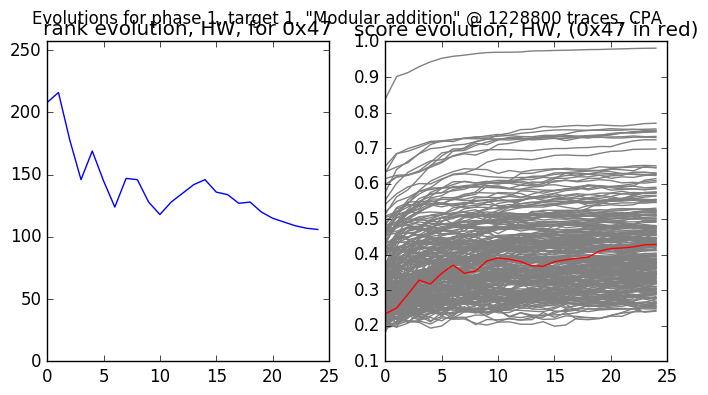

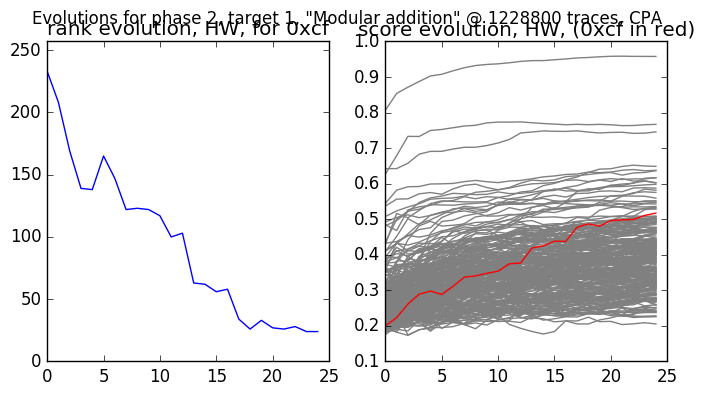

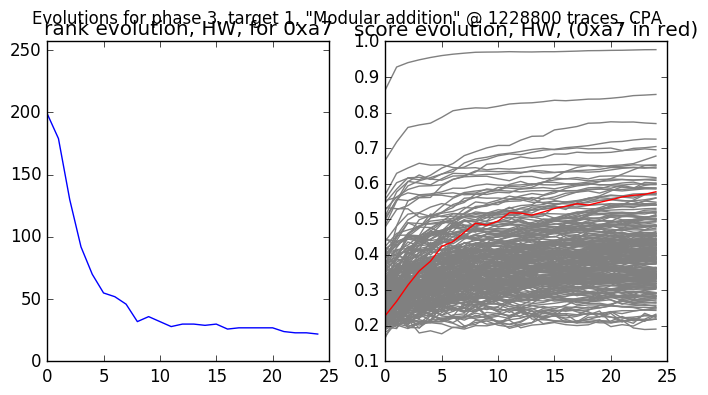

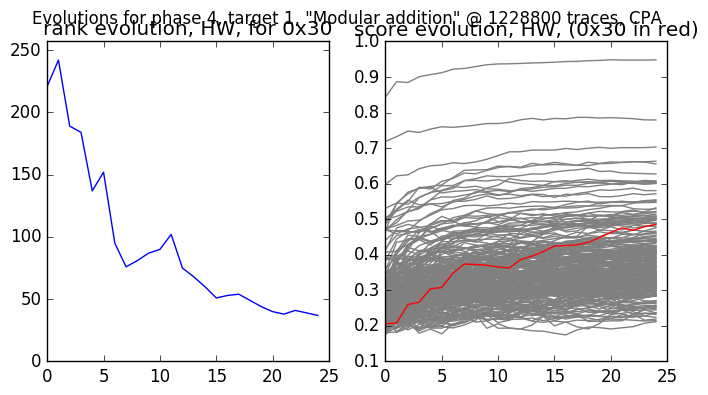

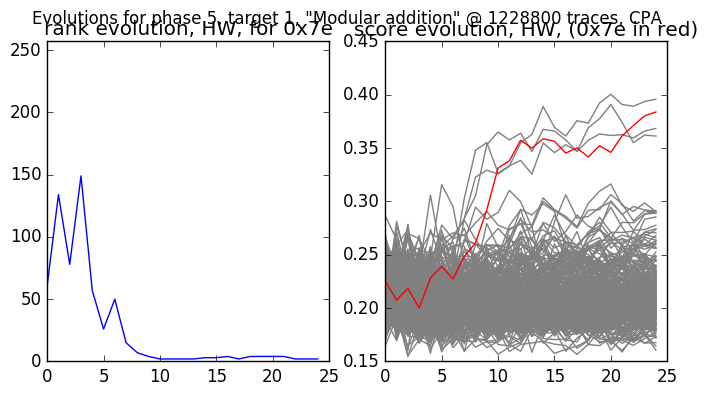

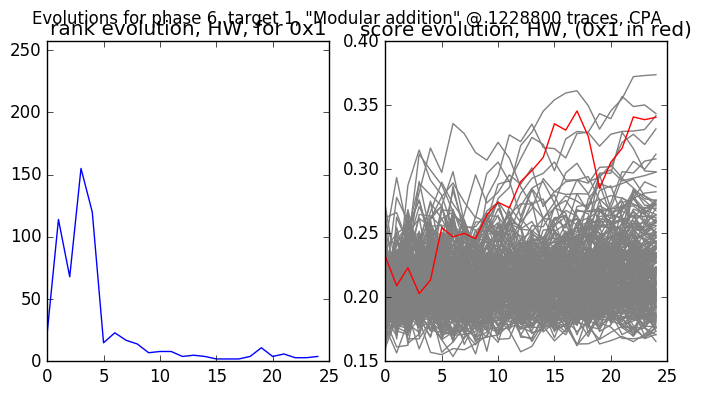

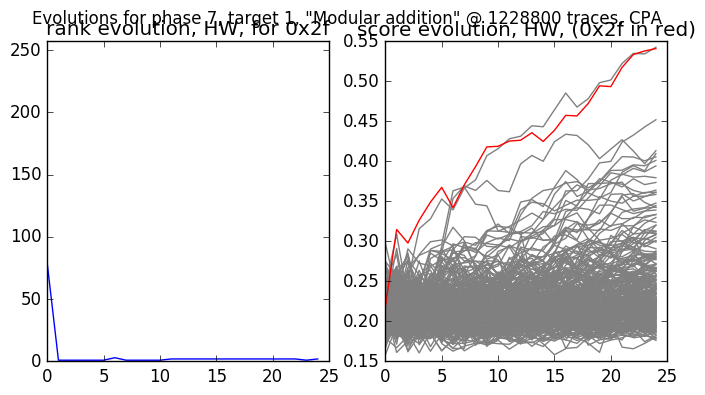

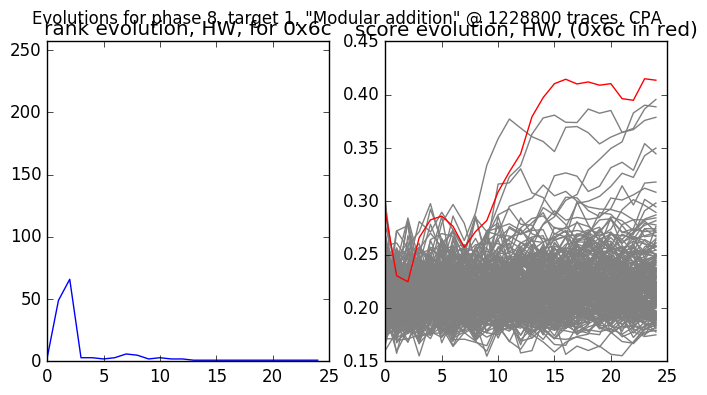

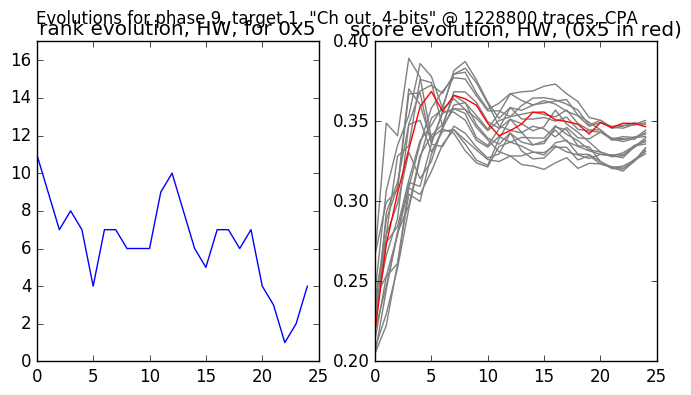

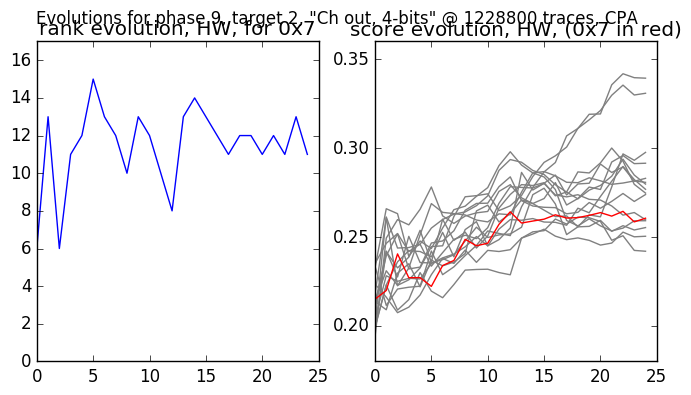

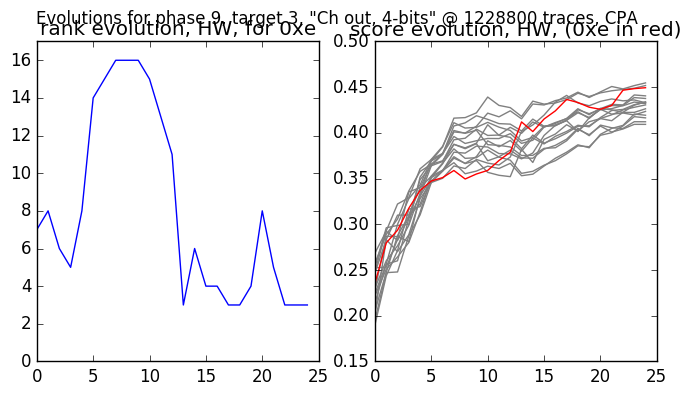

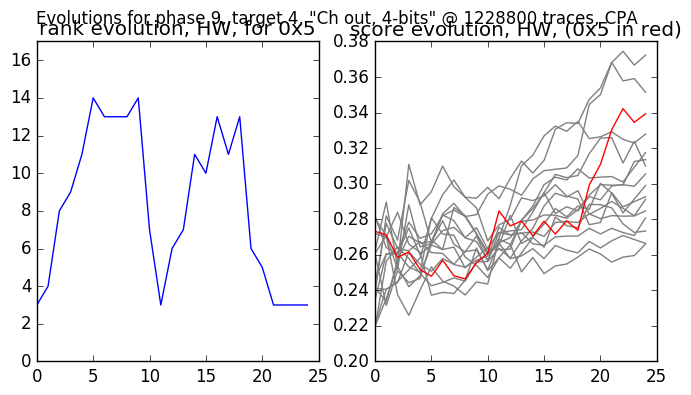

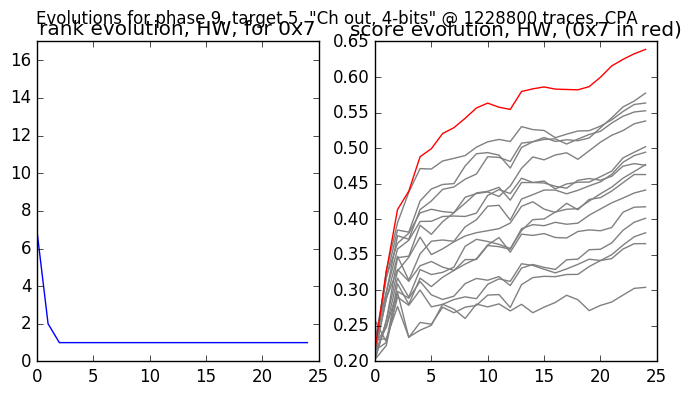

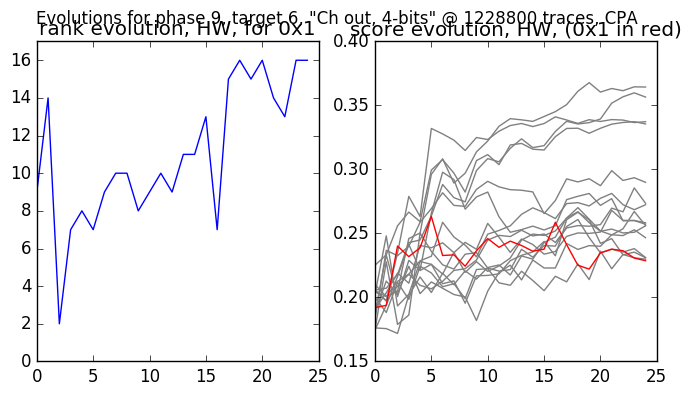

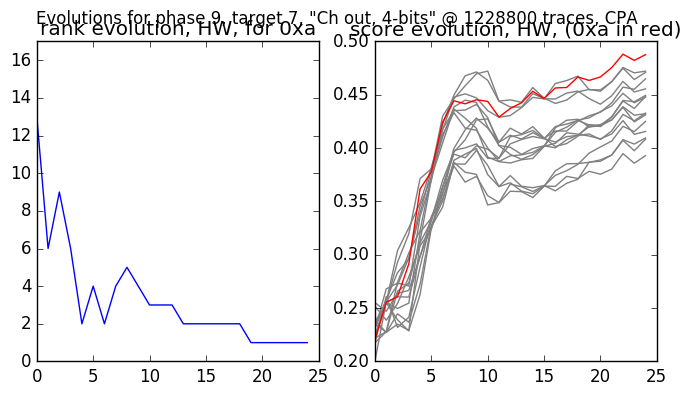

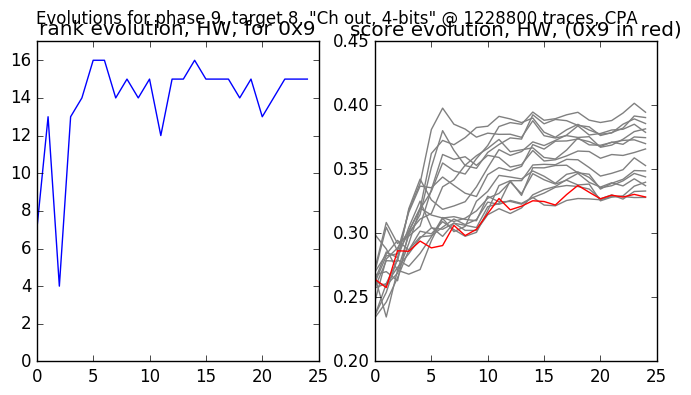

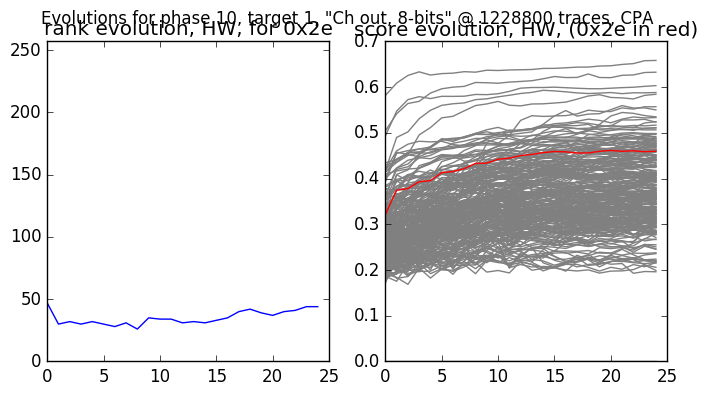

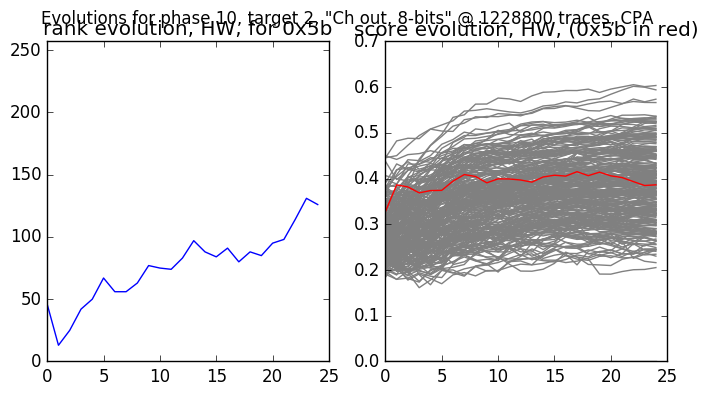

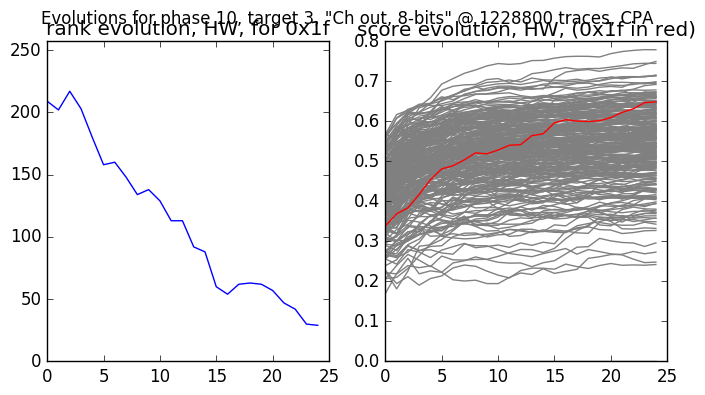

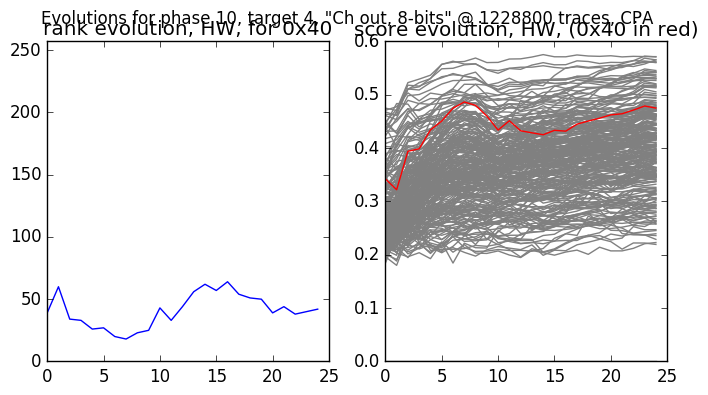

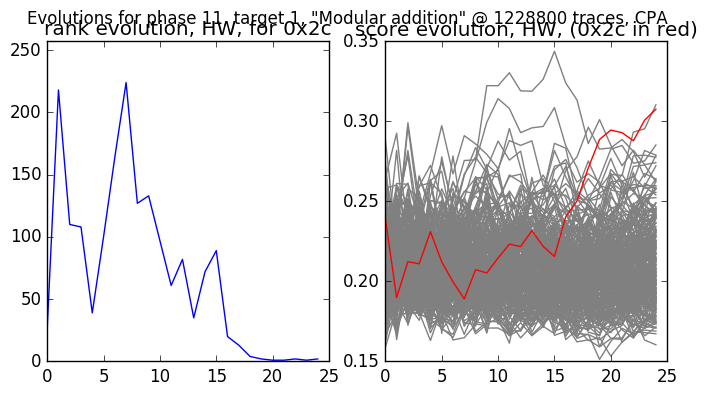

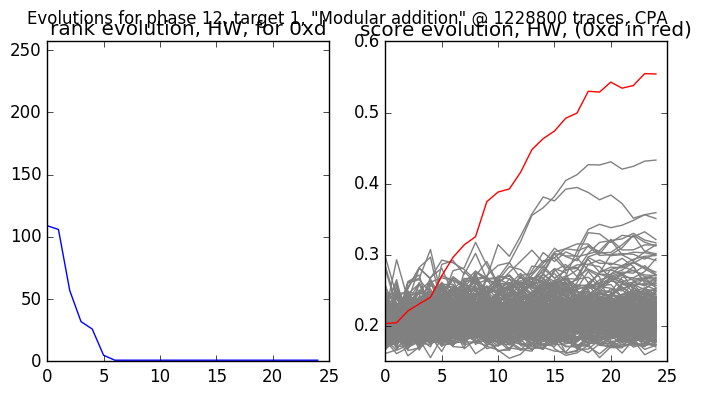

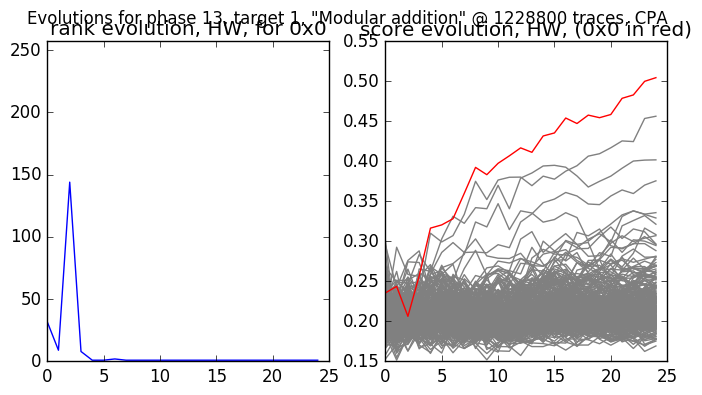

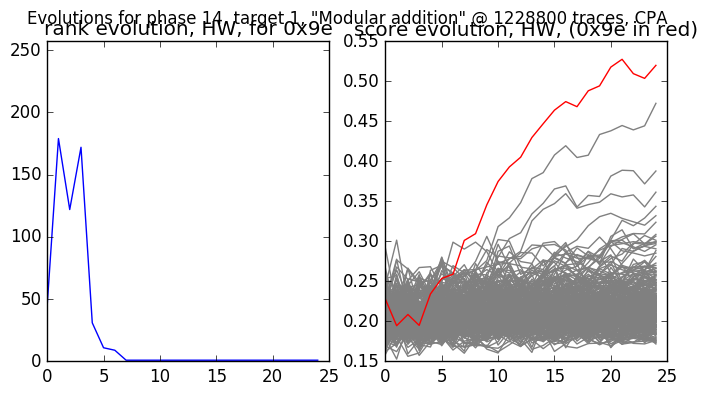

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [14]:
plotAllEvolutions(condavgparams,condavgrankData)

As you can see, it's not all bad for DPA 2 (phases 5-8) and 5 (phases 11-14). Unfortunately, the very first DPA 1 is not very good at all. Since all these DPA attacks depend on the success of the previous attack, it's not very hopeful. DPA 1 is bad because the difference between target output T0 and SHA input W0 is a constant. For DPA attacks 2 and 5 this is not the case. For example, in DPA 2 target function inputs "W1" and "Rot(T0, 5)" are added to a constant to produce T1. As a result, T1 is not a constant value away from W1, which means less ghost peaks.

The attacks on the Ch outputs (phases 8 and 9) also do not perform well, except for some targets. I focused mostly on modular addition, so I don't know what's happening there.

Besides the rank and score evolution, we also recorded the (last) score matrix per sample for each phase,target,leakage. For example, let's see where phase 5 target 1 (byte 0 of DPA 2) leaks.

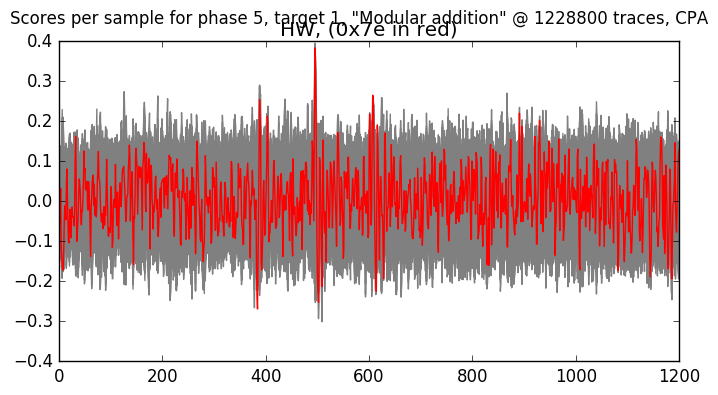

In [15]:
plotScoresPerSample(condavgcorrMatrices,condavgrankData,condavgparams,5,1)

Next, we run the same attack but with incremental correlation. 

In [16]:
doinccpa()


Jlsca running in Julia version: 0.6.1, 3 processes/2 workers/10 threads per worker

DPA parameters
attack:       Sha1 input
T xor:        false
analysis:     Incremental CPA
leakages:     HW
maximization: abs global max
data at:      1
known key:    685d79d6007d6cb9437d9393ce6eacdefbf69a0a

phase: 1 / 14, #targets 1

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.146651 @ 138
rank:   2, candidate: 0x10, peak: 0.112754 @ 138
rank:   3, candidate: 0x40, peak: 0.109811 @ 138
rank:   4, candidate: 0xf0, peak: 0.106691 @ 138
rank: 192, correct  : 0x47, peak: 0.027862 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.135989 @ 138
rank:   2, candidate: 0x10, peak: 0.103962 @ 138
rank:   3, candidate: 0x40, peak: 0.100458 @ 138
rank:   4, candidate: 0xc0, peak: 0.099836 @ 138
rank: 170, correct  : 0x47, peak: 0.027734 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.134567 @ 138
rank:   2, candidate: 0x10, peak: 0.101032 @ 138
rank:   3, candidate: 0x40, peak: 0.098207 @ 138
rank:   4, candidate: 0xc0, peak: 0.097788 @ 138
rank: 161, correct  : 0x47, peak: 0.030332 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132173 @ 138
rank:   2, candidate: 0x10, peak: 0.099774 @ 138
rank:   3, candidate: 0xc0, peak: 0.097199 @ 138
rank:   4, candidate: 0x40, peak: 0.097023 @ 138
rank: 164, correct  : 0x47, peak: 0.029498 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132874 @ 138
rank:   2, candidate: 0x10, peak: 0.100332 @ 138
rank:   3, candidate: 0xc0, peak: 0.098433 @ 138
rank:   4, candidate: 0x40, peak: 0.097290 @ 138
rank: 170, correct  : 0x47, peak: 0.028208 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06Processing traces 250001:300000..  68%|████████████     |  ETA: 0:00:02


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.133447 @ 138
rank:   2, candidate: 0x10, peak: 0.101396 @ 138
rank:   3, candidate: 0xc0, peak: 0.098771 @ 138
rank:   4, candidate: 0xf0, peak: 0.097426 @ 138
rank: 163, correct  : 0x47, peak: 0.029179 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.135514 @ 138
rank:   2, candidate: 0x10, peak: 0.102493 @ 138
rank:   3, candidate: 0xc0, peak: 0.099897 @ 138
rank:   4, candidate: 0x40, peak: 0.099320 @ 138
rank: 166, correct  : 0x47, peak: 0.029264 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  98%|█████████████████|  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.136567 @ 138
rank:   2, candidate: 0x10, peak: 0.102885 @ 138
rank:   3, candidate: 0xc0, peak: 0.100117 @ 138
rank:   4, candidate: 0xf0, peak: 0.099355 @ 138
rank: 162, correct  : 0x47, peak: 0.030625 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:06
Processing traces 400001:450000..  92%|████████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:06


Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.137011 @ 138
rank:   2, candidate: 0x10, peak: 0.102204 @ 138
rank:   3, candidate: 0xc0, peak: 0.100456 @ 138
rank:   4, candidate: 0x40, peak: 0.099522 @ 138
rank: 164, correct  : 0x47, peak: 0.030550 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.135498 @ 138
rank:   2, candidate: 0x10, peak: 0.100826 @ 138
rank:   3, candidate: 0xc0, peak: 0.099789 @ 138
rank:   4, candidate: 0xf0, peak: 0.098508 @ 138
rank: 163, correct  : 0x47, peak: 0.030768 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.134173 @ 138
rank:   2, candidate: 0x10, peak: 0.099209 @ 138
rank:   3, candidate: 0xc0, peak: 0.098091 @ 138
rank:   4, candidate: 0xf0, peak: 0.097702 @ 138
rank: 160, correct  : 0x47, peak: 0.031001 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.133118 @ 138
rank:   2, candidate: 0x10, peak: 0.098131 @ 138
rank:   3, candidate: 0xc0, peak: 0.096903 @ 138
rank:   4, candidate: 0xf0, peak: 0.096798 @ 138
rank: 161, correct  : 0x47, peak: 0.030372 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132613 @ 138
rank:   2, candidate: 0x10, peak: 0.097432 @ 138
rank:   3, candidate: 0xc0, peak: 0.096806 @ 138
rank:   4, candidate: 0xf0, peak: 0.096217 @ 138
rank: 163, correct  : 0x47, peak: 0.029641 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.131885 @ 138
rank:   2, candidate: 0x10, peak: 0.096880 @ 138
rank:   3, candidate: 0xc0, peak: 0.096235 @ 138
rank:   4, candidate: 0xf0, peak: 0.095987 @ 138
rank: 162, correct  : 0x47, peak: 0.030081 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.131504 @ 138
rank:   2, candidate: 0x10, peak: 0.095972 @ 138
rank:   3, candidate: 0xc0, peak: 0.095812 @ 138
rank:   4, candidate: 0xf0, peak: 0.095376 @ 138
rank: 161, correct  : 0x47, peak: 0.030251 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.131574 @ 138
rank:   2, candidate: 0xc0, peak: 0.096228 @ 138
rank:   3, candidate: 0x10, peak: 0.095921 @ 138
rank:   4, candidate: 0xf0, peak: 0.095526 @ 138
rank: 158, correct  : 0x47, peak: 0.030821 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132273 @ 138
rank:   2, candidate: 0xc0, peak: 0.096718 @ 138
rank:   3, candidate: 0x10, peak: 0.096222 @ 138
rank:   4, candidate: 0xf0, peak: 0.096031 @ 138
rank: 163, correct  : 0x47, peak: 0.030266 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132172 @ 138
rank:   2, candidate: 0xc0, peak: 0.096926 @ 138
rank:   3, candidate: 0x10, peak: 0.096012 @ 138
rank:   4, candidate: 0xf0, peak: 0.095868 @ 138
rank: 163, correct  : 0x47, peak: 0.030029 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132290 @ 138
rank:   2, candidate: 0xc0, peak: 0.096822 @ 138
rank:   3, candidate: 0x10, peak: 0.096523 @ 138
rank:   4, candidate: 0xf0, peak: 0.095999 @ 138
rank: 164, correct  : 0x47, peak: 0.029733 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132937 @ 138
rank:   2, candidate: 0xc0, peak: 0.097016 @ 138
rank:   3, candidate: 0x10, peak: 0.096970 @ 138
rank:   4, candidate: 0xf0, peak: 0.096537 @ 138
rank: 164, correct  : 0x47, peak: 0.029473 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.133332 @ 138
rank:   2, candidate: 0xc0, peak: 0.097330 @ 138
rank:   3, candidate: 0x10, peak: 0.097155 @ 138
rank:   4, candidate: 0xf0, peak: 0.096860 @ 138
rank: 164, correct  : 0x47, peak: 0.029492 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132866 @ 138
rank:   2, candidate: 0x10, peak: 0.096875 @ 138
rank:   3, candidate: 0xc0, peak: 0.096694 @ 138
rank:   4, candidate: 0xf0, peak: 0.096691 @ 138
rank: 164, correct  : 0x47, peak: 0.029336 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132438 @ 138
rank:   2, candidate: 0x10, peak: 0.096947 @ 138
rank:   3, candidate: 0xf0, peak: 0.096496 @ 138
rank:   4, candidate: 0xc0, peak: 0.096284 @ 138
rank: 166, correct  : 0x47, peak: 0.029197 @ 138
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06Processing traces 1150001:1200000..  51%|████████       |  ETA: 0:00:03


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132113 @ 138
rank:   2, candidate: 0x10, peak: 0.096422 @ 138
rank:   3, candidate: 0xc0, peak: 0.096120 @ 138
rank:   4, candidate: 0xf0, peak: 0.095982 @ 138
rank: 167, correct  : 0x47, peak: 0.028836 @ 138
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes


Processing traces 1200001:1228800..  96%|██████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 1, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.132001 @ 138
rank:   2, candidate: 0x10, peak: 0.096528 @ 138
rank:   3, candidate: 0xf0, peak: 0.096020 @ 138
rank:   4, candidate: 0xc0, peak: 0.095887 @ 138
rank: 167, correct  : 0x47, peak: 0.028898 @ 138
recovered key material: 00


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03



phase: 2 / 14, #targets 1
phase input: 47

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.104895 @ 103
rank:   2, candidate: 0xff, peak: 0.081853 @ 138
rank:   3, candidate: 0x80, peak: 0.079931 @ 138
rank:   4, candidate: 0xfe, peak: 0.067441 @ 103
rank: 256, correct  : 0xcf, peak: 0.013396 @ 387
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.097721 @ 138
rank:   2, candidate: 0x80, peak: 0.076286 @ 138
rank:   3, candidate: 0xff, peak: 0.073407 @ 138
rank:   4, candidate: 0xc0, peak: 0.061062 @ 138
rank: 255, correct  : 0xcf, peak: 0.010908 @ 387
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.093933 @ 138
rank:   2, candidate: 0x80, peak: 0.073357 @ 157
rank:   3, candidate: 0xff, peak: 0.070778 @ 138
rank:   4, candidate: 0xc0, peak: 0.059209 @ 138
rank: 240, correct  : 0xcf, peak: 0.011266 @ 498
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06Processing traces 150001:200000..  13%|██               |  ETA: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.093048 @ 138
rank:   2, candidate: 0x80, peak: 0.072727 @ 157
rank:   3, candidate: 0xff, peak: 0.071490 @ 138
rank:   4, candidate: 0xc0, peak: 0.058780 @ 138
rank: 238, correct  : 0xcf, peak: 0.011044 @ 497
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.093763 @ 138
rank:   2, candidate: 0x80, peak: 0.074767 @ 157
rank:   3, candidate: 0xff, peak: 0.071564 @ 138
rank:   4, candidate: 0xc0, peak: 0.059851 @ 138
rank: 243, correct  : 0xcf, peak: 0.010176 @ 497
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.093869 @ 138
rank:   2, candidate: 0x80, peak: 0.075441 @ 157
rank:   3, candidate: 0xff, peak: 0.071348 @ 138
rank:   4, candidate: 0xc0, peak: 0.059101 @ 138
rank: 234, correct  : 0xcf, peak: 0.011426 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094476 @ 138
rank:   2, candidate: 0x80, peak: 0.075429 @ 157
rank:   3, candidate: 0xff, peak: 0.072021 @ 138
rank:   4, candidate: 0xfe, peak: 0.059042 @ 156
rank: 233, correct  : 0xcf, peak: 0.011588 @ 144
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  87%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.095206 @ 138
rank:   2, candidate: 0x80, peak: 0.076356 @ 157
rank:   3, candidate: 0xff, peak: 0.072653 @ 138
rank:   4, candidate: 0xfe, peak: 0.060129 @ 156
rank: 221, correct  : 0xcf, peak: 0.012528 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:06
Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.095773 @ 138
rank:   2, candidate: 0x80, peak: 0.076084 @ 157
rank:   3, candidate: 0xff, peak: 0.072653 @ 138
rank:   4, candidate: 0xfe, peak: 0.059973 @ 156
rank: 221, correct  : 0xcf, peak: 0.012910 @ 144
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.095572 @ 138
rank:   2, candidate: 0x80, peak: 0.075867 @ 157
rank:   3, candidate: 0xff, peak: 0.073131 @ 138
rank:   4, candidate: 0xfe, peak: 0.059472 @ 156
rank: 222, correct  : 0xcf, peak: 0.012763 @ 144
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094475 @ 138
rank:   2, candidate: 0x80, peak: 0.074793 @ 157
rank:   3, candidate: 0xff, peak: 0.072594 @ 138
rank:   4, candidate: 0xc0, peak: 0.058648 @ 138
rank: 220, correct  : 0xcf, peak: 0.012443 @ 144
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094249 @ 138
rank:   2, candidate: 0x80, peak: 0.074337 @ 157
rank:   3, candidate: 0xff, peak: 0.071877 @ 138
rank:   4, candidate: 0xc0, peak: 0.058539 @ 138
rank: 220, correct  : 0xcf, peak: 0.012329 @ 144
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094096 @ 138
rank:   2, candidate: 0x80, peak: 0.074189 @ 157
rank:   3, candidate: 0xff, peak: 0.071574 @ 138
rank:   4, candidate: 0xc0, peak: 0.058124 @ 138
rank: 219, correct  : 0xcf, peak: 0.012359 @ 144
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094372 @ 138
rank:   2, candidate: 0x80, peak: 0.073949 @ 157
rank:   3, candidate: 0xff, peak: 0.071254 @ 138
rank:   4, candidate: 0xc0, peak: 0.058768 @ 138
rank: 220, correct  : 0xcf, peak: 0.012200 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.093864 @ 138
rank:   2, candidate: 0x80, peak: 0.073854 @ 157
rank:   3, candidate: 0xff, peak: 0.071099 @ 138
rank:   4, candidate: 0xfe, peak: 0.058262 @ 156
rank: 219, correct  : 0xcf, peak: 0.012082 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094152 @ 138
rank:   2, candidate: 0x80, peak: 0.073813 @ 157
rank:   3, candidate: 0xff, peak: 0.071597 @ 138
rank:   4, candidate: 0xfe, peak: 0.058567 @ 156
rank: 218, correct  : 0xcf, peak: 0.012090 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094092 @ 138
rank:   2, candidate: 0x80, peak: 0.073888 @ 157
rank:   3, candidate: 0xff, peak: 0.071070 @ 138
rank:   4, candidate: 0xfe, peak: 0.058887 @ 156
rank: 216, correct  : 0xcf, peak: 0.012464 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.093998 @ 138
rank:   2, candidate: 0x80, peak: 0.073922 @ 157
rank:   3, candidate: 0xff, peak: 0.071269 @ 138
rank:   4, candidate: 0xfe, peak: 0.059074 @ 156
rank: 214, correct  : 0xcf, peak: 0.012682 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094154 @ 138
rank:   2, candidate: 0x80, peak: 0.073862 @ 157
rank:   3, candidate: 0xff, peak: 0.071784 @ 138
rank:   4, candidate: 0xfe, peak: 0.059658 @ 156
rank: 212, correct  : 0xcf, peak: 0.012992 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094546 @ 138
rank:   2, candidate: 0x80, peak: 0.073936 @ 157
rank:   3, candidate: 0xff, peak: 0.071988 @ 138
rank:   4, candidate: 0xfe, peak: 0.059861 @ 156
rank: 214, correct  : 0xcf, peak: 0.012916 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094696 @ 138
rank:   2, candidate: 0x80, peak: 0.073703 @ 157
rank:   3, candidate: 0xff, peak: 0.072023 @ 138
rank:   4, candidate: 0xfe, peak: 0.059972 @ 156
rank: 214, correct  : 0xcf, peak: 0.012806 @ 144
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06Processing traces 1050001:1100000..  13%|██             |  ETA: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094363 @ 138
rank:   2, candidate: 0x80, peak: 0.073229 @ 157
rank:   3, candidate: 0xff, peak: 0.071403 @ 138
rank:   4, candidate: 0xfe, peak: 0.059792 @ 156
rank: 215, correct  : 0xcf, peak: 0.012751 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.094114 @ 138
rank:   2, candidate: 0x80, peak: 0.072957 @ 157
rank:   3, candidate: 0xff, peak: 0.071329 @ 138
rank:   4, candidate: 0xfe, peak: 0.059778 @ 156
rank: 216, correct  : 0xcf, peak: 0.012748 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  86%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.093849 @ 138
rank:   2, candidate: 0x80, peak: 0.073025 @ 157
rank:   3, candidate: 0xff, peak: 0.071091 @ 138
rank:   4, candidate: 0xfe, peak: 0.059526 @ 156
rank: 217, correct  : 0xcf, peak: 0.012621 @ 144
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06
Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 2, "Modular addition"
rank:   1, candidate: 0x00, peak: 0.093779 @ 138
rank:   2, candidate: 0x80, peak: 0.072906 @ 157
rank:   3, candidate: 0xff, peak: 0.070792 @ 138
rank:   4, candidate: 0xfe, peak: 0.059443 @ 156
rank: 218, correct  : 0xcf, peak: 0.012465 @ 144
recovered key material: 00

phase: 3 / 14, #targets 1
phase input: 47cf

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.132629 @ 138
rank:   2, candidate: 0x7f, peak: 0.102473 @ 138
rank:   3, candidate: 0x00, peak: 0.085861 @ 138
rank:   4, candidate: 0xbf, peak: 0.084201 @ 138
rank: 248, correct  : 0xa7, peak: 0.016236 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.125866 @ 138
rank:   2, candidate: 0x7f, peak: 0.097268 @ 138
rank:   3, candidate: 0xbf, peak: 0.079262 @ 138
rank:   4, candidate: 0x00, peak: 0.077178 @ 138
rank: 236, correct  : 0xa7, peak: 0.015198 @ 140
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.122107 @ 138
rank:   2, candidate: 0x7f, peak: 0.096353 @ 138
rank:   3, candidate: 0xbf, peak: 0.077746 @ 138
rank:   4, candidate: 0x3f, peak: 0.075091 @ 138
rank: 235, correct  : 0xa7, peak: 0.015114 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.122456 @ 138
rank:   2, candidate: 0x7f, peak: 0.096568 @ 138
rank:   3, candidate: 0xbf, peak: 0.077348 @ 138
rank:   4, candidate: 0x00, peak: 0.075880 @ 138
rank: 228, correct  : 0xa7, peak: 0.014935 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124022 @ 138
rank:   2, candidate: 0x7f, peak: 0.097441 @ 138
rank:   3, candidate: 0x00, peak: 0.077948 @ 138
rank:   4, candidate: 0xbf, peak: 0.077837 @ 138
rank: 220, correct  : 0xa7, peak: 0.015245 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.126763 @ 138
rank:   2, candidate: 0x7f, peak: 0.099991 @ 138
rank:   3, candidate: 0x00, peak: 0.079463 @ 138
rank:   4, candidate: 0xbf, peak: 0.079316 @ 138
rank: 216, correct  : 0xa7, peak: 0.015898 @ 497
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.128326 @ 138
rank:   2, candidate: 0x7f, peak: 0.101724 @ 138
rank:   3, candidate: 0xbf, peak: 0.080414 @ 138
rank:   4, candidate: 0x00, peak: 0.079469 @ 138
rank: 218, correct  : 0xa7, peak: 0.015654 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  81%|██████████████   |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.128767 @ 138
rank:   2, candidate: 0x7f, peak: 0.101640 @ 138
rank:   3, candidate: 0xbf, peak: 0.081185 @ 138
rank:   4, candidate: 0x00, peak: 0.079764 @ 138
rank: 219, correct  : 0xa7, peak: 0.015575 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:07
Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.129803 @ 138
rank:   2, candidate: 0x7f, peak: 0.102192 @ 138
rank:   3, candidate: 0xbf, peak: 0.082540 @ 138
rank:   4, candidate: 0x3f, peak: 0.079803 @ 138
rank: 212, correct  : 0xa7, peak: 0.015788 @ 497
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.128160 @ 138
rank:   2, candidate: 0x7f, peak: 0.100742 @ 138
rank:   3, candidate: 0xbf, peak: 0.081452 @ 138
rank:   4, candidate: 0x00, peak: 0.079128 @ 138
rank: 220, correct  : 0xa7, peak: 0.015232 @ 497
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.127035 @ 138
rank:   2, candidate: 0x7f, peak: 0.099432 @ 138
rank:   3, candidate: 0xbf, peak: 0.080636 @ 138
rank:   4, candidate: 0x00, peak: 0.078743 @ 138
rank: 216, correct  : 0xa7, peak: 0.015260 @ 497
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.126298 @ 138
rank:   2, candidate: 0x7f, peak: 0.098613 @ 138
rank:   3, candidate: 0xbf, peak: 0.079472 @ 138
rank:   4, candidate: 0x00, peak: 0.078378 @ 138
rank: 212, correct  : 0xa7, peak: 0.016071 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.125312 @ 138
rank:   2, candidate: 0x7f, peak: 0.098059 @ 138
rank:   3, candidate: 0xbf, peak: 0.078654 @ 138
rank:   4, candidate: 0x00, peak: 0.078079 @ 138
rank: 209, correct  : 0xa7, peak: 0.015962 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124298 @ 138
rank:   2, candidate: 0x7f, peak: 0.097447 @ 138
rank:   3, candidate: 0xbf, peak: 0.078090 @ 138
rank:   4, candidate: 0x00, peak: 0.077407 @ 138
rank: 209, correct  : 0xa7, peak: 0.015725 @ 497
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124057 @ 138
rank:   2, candidate: 0x7f, peak: 0.096917 @ 138
rank:   3, candidate: 0xbf, peak: 0.077386 @ 138
rank:   4, candidate: 0x00, peak: 0.077231 @ 138
rank: 208, correct  : 0xa7, peak: 0.015665 @ 497
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  88%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124202 @ 138
rank:   2, candidate: 0x7f, peak: 0.096940 @ 138
rank:   3, candidate: 0xbf, peak: 0.077605 @ 138
rank:   4, candidate: 0x00, peak: 0.077408 @ 138
rank: 208, correct  : 0xa7, peak: 0.015637 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06
Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124121 @ 138
rank:   2, candidate: 0x7f, peak: 0.097155 @ 138
rank:   3, candidate: 0xbf, peak: 0.078004 @ 138
rank:   4, candidate: 0x00, peak: 0.077107 @ 138
rank: 208, correct  : 0xa7, peak: 0.015735 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000..  86%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:06


Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124053 @ 138
rank:   2, candidate: 0x7f, peak: 0.096999 @ 138
rank:   3, candidate: 0xbf, peak: 0.078127 @ 138
rank:   4, candidate: 0x3f, peak: 0.076994 @ 138
rank: 208, correct  : 0xa7, peak: 0.015867 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124715 @ 138
rank:   2, candidate: 0x7f, peak: 0.097600 @ 138
rank:   3, candidate: 0xbf, peak: 0.078545 @ 138
rank:   4, candidate: 0x3f, peak: 0.077341 @ 138
rank: 212, correct  : 0xa7, peak: 0.015432 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.125420 @ 138
rank:   2, candidate: 0x7f, peak: 0.098548 @ 138
rank:   3, candidate: 0xbf, peak: 0.078964 @ 138
rank:   4, candidate: 0x00, peak: 0.077703 @ 138
rank: 209, correct  : 0xa7, peak: 0.015636 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.125390 @ 138
rank:   2, candidate: 0x7f, peak: 0.098582 @ 138
rank:   3, candidate: 0xbf, peak: 0.079168 @ 138
rank:   4, candidate: 0x3f, peak: 0.077597 @ 138
rank: 209, correct  : 0xa7, peak: 0.015778 @ 497
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.125091 @ 138
rank:   2, candidate: 0x7f, peak: 0.098148 @ 138
rank:   3, candidate: 0xbf, peak: 0.078744 @ 138
rank:   4, candidate: 0x00, peak: 0.077439 @ 138
rank: 209, correct  : 0xa7, peak: 0.015929 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124587 @ 138
rank:   2, candidate: 0x7f, peak: 0.097648 @ 138
rank:   3, candidate: 0xbf, peak: 0.078379 @ 138
rank:   4, candidate: 0x3f, peak: 0.077205 @ 138
rank: 207, correct  : 0xa7, peak: 0.016163 @ 497
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  88%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124208 @ 138
rank:   2, candidate: 0x7f, peak: 0.097091 @ 138
rank:   3, candidate: 0xbf, peak: 0.077886 @ 138
rank:   4, candidate: 0x00, peak: 0.076783 @ 138
rank: 204, correct  : 0xa7, peak: 0.016212 @ 497
recovered key material: ff


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06


	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes


Processing traces 1200001:1228800..  97%|██████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 3, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.124229 @ 138
rank:   2, candidate: 0x7f, peak: 0.097198 @ 138
rank:   3, candidate: 0xbf, peak: 0.077779 @ 138
rank:   4, candidate: 0x00, peak: 0.076727 @ 138
rank: 203, correct  : 0xa7, peak: 0.016415 @ 497
recovered key material: ff

phase: 4 / 14, #targets 1
phase input: 47cfa7

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03
Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.146318 @ 157
rank:   2, candidate: 0x00, peak: 0.124441 @ 157
rank:   3, candidate: 0x7f, peak: 0.101236 @ 157
rank:   4, candidate: 0xfe, peak: 0.086791 @ 157
rank: 237, correct  : 0x30, peak: 0.016013 @ 157
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.137244 @ 157
rank:   2, candidate: 0x00, peak: 0.113787 @ 157
rank:   3, candidate: 0x7f, peak: 0.095301 @ 157
rank:   4, candidate: 0xfe, peak: 0.080149 @ 157
rank: 228, correct  : 0x30, peak: 0.015036 @ 157
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.131639 @ 157
rank:   2, candidate: 0x00, peak: 0.111606 @ 157
rank:   3, candidate: 0x7f, peak: 0.088564 @ 157
rank:   4, candidate: 0xfe, peak: 0.079382 @ 157
rank: 176, correct  : 0x30, peak: 0.018384 @ 157
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.132785 @ 157
rank:   2, candidate: 0x00, peak: 0.110990 @ 157
rank:   3, candidate: 0x7f, peak: 0.089243 @ 157
rank:   4, candidate: 0xfe, peak: 0.079338 @ 157
rank: 197, correct  : 0x30, peak: 0.016367 @ 157
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.132451 @ 157
rank:   2, candidate: 0x00, peak: 0.109122 @ 157
rank:   3, candidate: 0x7f, peak: 0.090279 @ 157
rank:   4, candidate: 0x01, peak: 0.078581 @ 157
rank: 205, correct  : 0x30, peak: 0.015176 @ 157
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.134319 @ 157
rank:   2, candidate: 0x00, peak: 0.109665 @ 157
rank:   3, candidate: 0x7f, peak: 0.092021 @ 157
rank:   4, candidate: 0x01, peak: 0.079731 @ 157
rank: 205, correct  : 0x30, peak: 0.015032 @ 150
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.137134 @ 157
rank:   2, candidate: 0x00, peak: 0.112061 @ 157
rank:   3, candidate: 0x7f, peak: 0.093901 @ 157
rank:   4, candidate: 0x01, peak: 0.081078 @ 157
rank: 199, correct  : 0x30, peak: 0.015757 @ 157
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  94%|████████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.138935 @ 157
rank:   2, candidate: 0x00, peak: 0.112979 @ 157
rank:   3, candidate: 0x7f, peak: 0.094724 @ 157
rank:   4, candidate: 0xfe, peak: 0.081930 @ 157
rank: 204, correct  : 0x30, peak: 0.015330 @ 157
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:07
Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.138952 @ 157
rank:   2, candidate: 0x00, peak: 0.113057 @ 157
rank:   3, candidate: 0x7f, peak: 0.094339 @ 157
rank:   4, candidate: 0xfe, peak: 0.082009 @ 157
rank: 206, correct  : 0x30, peak: 0.015081 @ 157
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.138005 @ 157
rank:   2, candidate: 0x00, peak: 0.111985 @ 157
rank:   3, candidate: 0x7f, peak: 0.093967 @ 157
rank:   4, candidate: 0xfe, peak: 0.081951 @ 157
rank: 200, correct  : 0x30, peak: 0.015432 @ 150
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.137180 @ 157
rank:   2, candidate: 0x00, peak: 0.111125 @ 157
rank:   3, candidate: 0x7f, peak: 0.093416 @ 157
rank:   4, candidate: 0xfe, peak: 0.081605 @ 157
rank: 204, correct  : 0x30, peak: 0.014906 @ 150
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136237 @ 157
rank:   2, candidate: 0x00, peak: 0.110210 @ 157
rank:   3, candidate: 0x7f, peak: 0.093003 @ 157
rank:   4, candidate: 0xfe, peak: 0.080475 @ 157
rank: 201, correct  : 0x30, peak: 0.014883 @ 150
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.135897 @ 157
rank:   2, candidate: 0x00, peak: 0.110151 @ 157
rank:   3, candidate: 0x7f, peak: 0.092562 @ 157
rank:   4, candidate: 0xfe, peak: 0.080477 @ 157
rank: 203, correct  : 0x30, peak: 0.014893 @ 150
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.135596 @ 157
rank:   2, candidate: 0x00, peak: 0.109427 @ 157
rank:   3, candidate: 0x7f, peak: 0.092305 @ 157
rank:   4, candidate: 0xfe, peak: 0.080113 @ 157
rank: 205, correct  : 0x30, peak: 0.014421 @ 150
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.135414 @ 157
rank:   2, candidate: 0x00, peak: 0.109659 @ 157
rank:   3, candidate: 0x7f, peak: 0.092140 @ 157
rank:   4, candidate: 0xfe, peak: 0.080483 @ 157
rank: 208, correct  : 0x30, peak: 0.014228 @ 150
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  83%|██████████████   |  ETA: 0:00:01Processing traces 750001:800000..  13%|██               |  ETA: 0:00:07

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.135684 @ 157
rank:   2, candidate: 0x00, peak: 0.109880 @ 157
rank:   3, candidate: 0x7f, peak: 0.092324 @ 157
rank:   4, candidate: 0xfe, peak: 0.080905 @ 157
rank: 207, correct  : 0x30, peak: 0.014442 @ 158
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06
Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136224 @ 157
rank:   2, candidate: 0x00, peak: 0.110140 @ 157
rank:   3, candidate: 0x7f, peak: 0.092637 @ 157
rank:   4, candidate: 0xfe, peak: 0.080966 @ 157
rank: 204, correct  : 0x30, peak: 0.014633 @ 158
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136405 @ 157
rank:   2, candidate: 0x00, peak: 0.110444 @ 157
rank:   3, candidate: 0x7f, peak: 0.092861 @ 157
rank:   4, candidate: 0xfe, peak: 0.080861 @ 157
rank: 205, correct  : 0x30, peak: 0.014646 @ 158
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000..  84%|██████████████   |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136521 @ 157
rank:   2, candidate: 0x00, peak: 0.110445 @ 157
rank:   3, candidate: 0x7f, peak: 0.093212 @ 157
rank:   4, candidate: 0xfe, peak: 0.080967 @ 157
rank: 208, correct  : 0x30, peak: 0.014657 @ 158
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06
Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136665 @ 157
rank:   2, candidate: 0x00, peak: 0.110498 @ 157
rank:   3, candidate: 0x7f, peak: 0.093407 @ 157
rank:   4, candidate: 0xfe, peak: 0.081059 @ 157
rank: 210, correct  : 0x30, peak: 0.014356 @ 158
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136623 @ 157
rank:   2, candidate: 0x00, peak: 0.110441 @ 157
rank:   3, candidate: 0x7f, peak: 0.093335 @ 157
rank:   4, candidate: 0xfe, peak: 0.080955 @ 157
rank: 208, correct  : 0x30, peak: 0.014484 @ 158
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136428 @ 157
rank:   2, candidate: 0x00, peak: 0.110551 @ 157
rank:   3, candidate: 0x7f, peak: 0.093077 @ 157
rank:   4, candidate: 0xfe, peak: 0.081180 @ 157
rank: 210, correct  : 0x30, peak: 0.014439 @ 158
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136173 @ 157
rank:   2, candidate: 0x00, peak: 0.110293 @ 157
rank:   3, candidate: 0x7f, peak: 0.093172 @ 157
rank:   4, candidate: 0xfe, peak: 0.080876 @ 157
rank: 208, correct  : 0x30, peak: 0.014502 @ 158
recovered key material: ff
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  85%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136209 @ 157
rank:   2, candidate: 0x00, peak: 0.110222 @ 157
rank:   3, candidate: 0x7f, peak: 0.093159 @ 157
rank:   4, candidate: 0xfe, peak: 0.080917 @ 157
rank: 207, correct  : 0x30, peak: 0.014628 @ 158
recovered key material: ff
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06
Processing traces 1200001:1228800..  93%|██████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 4, "Modular addition"
rank:   1, candidate: 0xff, peak: 0.136241 @ 157
rank:   2, candidate: 0x00, peak: 0.110323 @ 157
rank:   3, candidate: 0x7f, peak: 0.093147 @ 157
rank:   4, candidate: 0xfe, peak: 0.081132 @ 157
rank: 208, correct  : 0x30, peak: 0.014490 @ 158
recovered key material: ff


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03



phase: 5 / 14, #targets 1
phase input: 47cfa730

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x98, peak: 0.019549 @ 705
rank:   2, candidate: 0xf3, peak: 0.019458 @ 1060
rank:   3, candidate: 0x11, peak: 0.019414 @ 320
rank:   4, candidate: 0x63, peak: 0.019343 @ 70
rank:  39, correct  : 0x7e, peak: 0.016892 @ 615
recovered key material: 98
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x04, peak: 0.014969 @ 502
rank:   2, candidate: 0xa0, peak: 0.014320 @ 567
rank:   3, candidate: 0xd5, peak: 0.013552 @ 274
rank:   4, candidate: 0xe8, peak: 0.013321 @ 288
rank: 122, correct  : 0x7e, peak: 0.010794 @ 144
recovered key material: 04
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xd3, peak: 0.012032 @ 84
rank:   2, candidate: 0x95, peak: 0.011801 @ 274
rank:   3, candidate: 0x53, peak: 0.011400 @ 84
rank:   4, candidate: 0x11, peak: 0.011115 @ 385
rank: 120, correct  : 0x7e, peak: 0.008738 @ 144
recovered key material: d3
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xc2, peak: 0.009571 @ 777
rank:   2, candidate: 0xa0, peak: 0.009569 @ 567
rank:   3, candidate: 0x90, peak: 0.009439 @ 690
rank:   4, candidate: 0x60, peak: 0.009434 @ 566
rank: 149, correct  : 0x7e, peak: 0.007229 @ 1146
recovered key material: c2
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x37, peak: 0.009243 @ 36
rank:   2, candidate: 0x8b, peak: 0.008764 @ 142
rank:   3, candidate: 0xc2, peak: 0.008588 @ 777
rank:   4, candidate: 0x1c, peak: 0.008491 @ 525
rank:  42, correct  : 0x7e, peak: 0.007590 @ 497
recovered key material: 37
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xdc, peak: 0.009494 @ 563
rank:   2, candidate: 0xfe, peak: 0.008491 @ 497
rank:   3, candidate: 0xe4, peak: 0.008343 @ 65
rank:   4, candidate: 0x02, peak: 0.008106 @ 497
rank:  19, correct  : 0x7e, peak: 0.007335 @ 497
recovered key material: dc
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xdc, peak: 0.008164 @ 563
rank:   2, candidate: 0xfe, peak: 0.007627 @ 497
rank:   3, candidate: 0x3e, peak: 0.007470 @ 1186
rank:   4, candidate: 0x14, peak: 0.007433 @ 54
rank:  27, correct  : 0x7e, peak: 0.006562 @ 497
recovered key material: dc
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.008114 @ 497
rank:   2, candidate: 0x82, peak: 0.007652 @ 497
rank:   3, candidate: 0xfe, peak: 0.007571 @ 497
rank:   4, candidate: 0xc8, peak: 0.007382 @ 878
rank:  13, correct  : 0x7e, peak: 0.006650 @ 497
recovered key material: 02
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.008674 @ 497
rank:   2, candidate: 0x82, peak: 0.008074 @ 497
rank:   3, candidate: 0xfe, peak: 0.007577 @ 497
rank:   4, candidate: 0x42, peak: 0.007311 @ 497
rank:   7, correct  : 0x7e, peak: 0.006491 @ 497
recovered key material: 02
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.008403 @ 497
rank:   2, candidate: 0xfe, peak: 0.007880 @ 497
rank:   3, candidate: 0x82, peak: 0.007796 @ 497
rank:   4, candidate: 0xc2, peak: 0.007061 @ 777
rank:   5, correct  : 0x7e, peak: 0.006810 @ 497
recovered key material: 02
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.007619 @ 496
rank:   2, candidate: 0x02, peak: 0.007355 @ 497
rank:   3, candidate: 0x82, peak: 0.007341 @ 497
rank:   4, correct  : 0x7e, peak: 0.007055 @ 497
rank:   5, candidate: 0x42, peak: 0.006654 @ 498
recovered key material: fe
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06Processing traces 550001:600000..  13%|██               |  ETA: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.007616 @ 497
rank:   2, candidate: 0x02, peak: 0.007307 @ 497
rank:   3, candidate: 0x82, peak: 0.007299 @ 497
rank:   4, correct  : 0x7e, peak: 0.007047 @ 497
rank:   5, candidate: 0x42, peak: 0.006742 @ 498
recovered key material: fe
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.007459 @ 497
rank:   2, candidate: 0x82, peak: 0.007456 @ 497
rank:   3, candidate: 0x02, peak: 0.007169 @ 497
rank:   4, correct  : 0x7e, peak: 0.007138 @ 496
rank:   5, candidate: 0x42, peak: 0.006282 @ 498
recovered key material: fe
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.007172 @ 497
rank:   2, correct  : 0x7e, peak: 0.006853 @ 496
rank:   3, candidate: 0xfe, peak: 0.006835 @ 497
rank:   4, candidate: 0x02, peak: 0.006683 @ 497
rank:   5, candidate: 0xc2, peak: 0.005711 @ 497
recovered key material: 82
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.007393 @ 496
rank:   2, candidate: 0xfe, peak: 0.006995 @ 496
rank:   3, candidate: 0x02, peak: 0.006990 @ 497
rank:   4, correct  : 0x7e, peak: 0.006828 @ 496
rank:   5, candidate: 0xc2, peak: 0.005988 @ 497
recovered key material: 82
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.006943 @ 497
rank:   2, candidate: 0x82, peak: 0.006840 @ 497
rank:   3, candidate: 0x02, peak: 0.006538 @ 497
rank:   4, correct  : 0x7e, peak: 0.006521 @ 496
rank:   5, candidate: 0xc2, peak: 0.005523 @ 497
recovered key material: fe
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.006710 @ 497
rank:   2, candidate: 0x02, peak: 0.006626 @ 497
rank:   3, candidate: 0x82, peak: 0.006610 @ 496
rank:   4, correct  : 0x7e, peak: 0.006316 @ 496
rank:   5, candidate: 0xc2, peak: 0.005361 @ 497
recovered key material: fe
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.006769 @ 496
rank:   2, candidate: 0x02, peak: 0.006597 @ 497
rank:   3, candidate: 0xfe, peak: 0.006591 @ 497
rank:   4, correct  : 0x7e, peak: 0.006310 @ 496
rank:   5, candidate: 0xc2, peak: 0.005245 @ 497
recovered key material: 82
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.006903 @ 497
rank:   2, candidate: 0xfe, peak: 0.006682 @ 497
rank:   3, candidate: 0x82, peak: 0.006665 @ 497
rank:   4, correct  : 0x7e, peak: 0.006051 @ 496
rank:   5, candidate: 0xc2, peak: 0.005575 @ 497
recovered key material: 02
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.007020 @ 497
rank:   2, candidate: 0x82, peak: 0.006884 @ 496
rank:   3, candidate: 0xfe, peak: 0.006751 @ 497
rank:   4, correct  : 0x7e, peak: 0.006176 @ 496
rank:   5, candidate: 0xc2, peak: 0.005753 @ 497
recovered key material: 02
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.007036 @ 497
rank:   2, candidate: 0x82, peak: 0.006852 @ 496
rank:   3, candidate: 0xfe, peak: 0.006505 @ 497
rank:   4, correct  : 0x7e, peak: 0.005905 @ 496
rank:   5, candidate: 0xc2, peak: 0.005690 @ 497
recovered key material: 02
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.006605 @ 497
rank:   2, candidate: 0x82, peak: 0.006569 @ 496
rank:   3, candidate: 0xfe, peak: 0.006385 @ 497
rank:   4, correct  : 0x7e, peak: 0.006058 @ 496
rank:   5, candidate: 0xc2, peak: 0.005228 @ 497
recovered key material: 02
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.006422 @ 496
rank:   2, candidate: 0xfe, peak: 0.006318 @ 497
rank:   3, candidate: 0x02, peak: 0.006266 @ 497
rank:   4, correct  : 0x7e, peak: 0.006109 @ 496
rank:   5, candidate: 0xc2, peak: 0.005128 @ 497
recovered key material: 82
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  87%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.006364 @ 496
rank:   2, candidate: 0xfe, peak: 0.006277 @ 497
rank:   3, candidate: 0x02, peak: 0.006227 @ 497
rank:   4, correct  : 0x7e, peak: 0.006131 @ 496
rank:   5, candidate: 0xc2, peak: 0.005131 @ 497
recovered key material: 82
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06
Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 5, "Modular addition"
rank:   1, candidate: 0x82, peak: 0.006294 @ 496
rank:   2, candidate: 0xfe, peak: 0.006199 @ 497
rank:   3, candidate: 0x02, peak: 0.006095 @ 497
rank:   4, correct  : 0x7e, peak: 0.006088 @ 496
rank:   5, candidate: 0xc2, peak: 0.004895 @ 497
recovered key material: 82

phase: 6 / 14, #targets 1
phase input: 47cfa7307e

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x80, peak: 0.020345 @ 282
rank:   2, candidate: 0xed, peak: 0.019094 @ 1157
rank:   3, candidate: 0x12, peak: 0.018755 @ 1165
rank:   4, candidate: 0xff, peak: 0.018667 @ 141
rank:  16, correct  : 0x01, peak: 0.017255 @ 327
recovered key material: 80
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x92, peak: 0.015311 @ 389
rank:   2, candidate: 0x12, peak: 0.013867 @ 389
rank:   3, candidate: 0xf7, peak: 0.013843 @ 876
rank:   4, candidate: 0x61, peak: 0.013453 @ 281
rank:  67, correct  : 0x01, peak: 0.011173 @ 946
recovered key material: 92
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x02, peak: 0.011933 @ 498
rank:   2, candidate: 0x83, peak: 0.011362 @ 615
rank:   3, candidate: 0x5d, peak: 0.011190 @ 639
rank:   4, candidate: 0x37, peak: 0.011065 @ 281
rank:  25, correct  : 0x01, peak: 0.010158 @ 1084
recovered key material: 02
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 150001:200000..  89%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x87, peak: 0.011338 @ 626
rank:   2, candidate: 0x02, peak: 0.010867 @ 498
rank:   3, candidate: 0x92, peak: 0.010551 @ 389
rank:   4, candidate: 0x07, peak: 0.010456 @ 626
rank: 112, correct  : 0x01, peak: 0.007623 @ 1084
recovered key material: 87
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.010584 @ 641
rank:   2, candidate: 0x83, peak: 0.009207 @ 614
rank:   3, candidate: 0x97, peak: 0.009166 @ 627
rank:   4, candidate: 0x87, peak: 0.009135 @ 626
rank: 154, correct  : 0x01, peak: 0.006616 @ 608
recovered key material: 2d
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.009085 @ 641
rank:   2, candidate: 0x27, peak: 0.009064 @ 375
rank:   3, candidate: 0x03, peak: 0.008450 @ 614
rank:   4, candidate: 0x87, peak: 0.008422 @ 626
rank:   8, correct  : 0x01, peak: 0.007836 @ 617
recovered key material: 2d
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.009369 @ 641
rank:   2, candidate: 0x2e, peak: 0.008227 @ 641
rank:   3, candidate: 0x98, peak: 0.008101 @ 640
rank:   4, candidate: 0x4d, peak: 0.008086 @ 628
rank:  23, correct  : 0x01, peak: 0.006736 @ 617
recovered key material: 2d
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.008262 @ 641
rank:   2, candidate: 0x03, peak: 0.007183 @ 615
rank:   3, candidate: 0x06, peak: 0.007154 @ 504
rank:   4, candidate: 0x27, peak: 0.007152 @ 375
rank:  29, correct  : 0x01, peak: 0.006194 @ 617
recovered key material: 2d
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.007550 @ 641
rank:   2, candidate: 0x06, peak: 0.007539 @ 504
rank:   3, candidate: 0x03, peak: 0.006550 @ 615
rank:   4, candidate: 0xb7, peak: 0.006491 @ 880
rank:  28, correct  : 0x01, peak: 0.005787 @ 617
recovered key material: 2d
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000..  88%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x03, peak: 0.007067 @ 615
rank:   2, candidate: 0x2d, peak: 0.007030 @ 641
rank:   3, candidate: 0x06, peak: 0.006669 @ 504
rank:   4, candidate: 0x98, peak: 0.006319 @ 640
rank:  12, correct  : 0x01, peak: 0.006022 @ 503
recovered key material: 03
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06
Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x2d, peak: 0.007022 @ 641
rank:   2, candidate: 0x03, peak: 0.006808 @ 615
rank:   3, candidate: 0x06, peak: 0.006616 @ 504
rank:   4, candidate: 0x02, peak: 0.006422 @ 504
rank:   7, correct  : 0x01, peak: 0.006057 @ 503
recovered key material: 2d
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.006699 @ 504
rank:   2, candidate: 0x02, peak: 0.006565 @ 498
rank:   3, candidate: 0x81, peak: 0.006442 @ 609
rank:   4, candidate: 0x2d, peak: 0.006200 @ 641
rank:   8, correct  : 0x01, peak: 0.005829 @ 608
recovered key material: 06
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006878 @ 609
rank:   2, candidate: 0x06, peak: 0.006369 @ 504
rank:   3, candidate: 0x03, peak: 0.006328 @ 615
rank:   4, correct  : 0x01, peak: 0.006310 @ 608
rank:   5, candidate: 0x02, peak: 0.006302 @ 497
recovered key material: 81
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006814 @ 609
rank:   2, candidate: 0x03, peak: 0.006564 @ 615
rank:   3, candidate: 0x02, peak: 0.006446 @ 497
rank:   4, candidate: 0x06, peak: 0.006411 @ 504
rank:   5, correct  : 0x01, peak: 0.006295 @ 608
recovered key material: 81
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006907 @ 609
rank:   2, candidate: 0x03, peak: 0.006306 @ 615
rank:   3, correct  : 0x01, peak: 0.006232 @ 608
rank:   4, candidate: 0x02, peak: 0.006004 @ 497
rank:   5, candidate: 0x54, peak: 0.005990 @ 608
recovered key material: 81
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  86%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.007079 @ 609
rank:   2, correct  : 0x01, peak: 0.006612 @ 608
rank:   3, candidate: 0x54, peak: 0.006034 @ 608
rank:   4, candidate: 0x02, peak: 0.005825 @ 497
rank:   5, candidate: 0x03, peak: 0.005669 @ 615
recovered key material: 81
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06
Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.007090 @ 609
rank:   2, correct  : 0x01, peak: 0.006484 @ 608
rank:   3, candidate: 0x03, peak: 0.006098 @ 615
rank:   4, candidate: 0x54, peak: 0.005734 @ 608
rank:   5, candidate: 0x83, peak: 0.005605 @ 615
recovered key material: 81
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.007050 @ 609
rank:   2, correct  : 0x01, peak: 0.006617 @ 608
rank:   3, candidate: 0x03, peak: 0.006177 @ 615
rank:   4, candidate: 0x02, peak: 0.005771 @ 504
rank:   5, candidate: 0x83, peak: 0.005718 @ 615
recovered key material: 81
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006653 @ 609
rank:   2, correct  : 0x01, peak: 0.005999 @ 608
rank:   3, candidate: 0x03, peak: 0.005946 @ 615
rank:   4, candidate: 0x02, peak: 0.005553 @ 504
rank:   5, candidate: 0x54, peak: 0.005423 @ 608
recovered key material: 81
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006235 @ 609
rank:   2, candidate: 0x02, peak: 0.005771 @ 504
rank:   3, candidate: 0x03, peak: 0.005541 @ 615
rank:   4, correct  : 0x01, peak: 0.005151 @ 608
rank:   5, candidate: 0x83, peak: 0.005129 @ 615
recovered key material: 81
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006505 @ 609
rank:   2, candidate: 0x03, peak: 0.005640 @ 615
rank:   3, candidate: 0x02, peak: 0.005618 @ 504
rank:   4, correct  : 0x01, peak: 0.005511 @ 608
rank:   5, candidate: 0x83, peak: 0.005236 @ 615
recovered key material: 81
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006484 @ 609
rank:   2, candidate: 0x02, peak: 0.005750 @ 504
rank:   3, correct  : 0x01, peak: 0.005561 @ 608
rank:   4, candidate: 0x03, peak: 0.005558 @ 615
rank:   5, candidate: 0xa1, peak: 0.005459 @ 609
recovered key material: 81
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006513 @ 609
rank:   2, correct  : 0x01, peak: 0.005765 @ 608
rank:   3, candidate: 0x02, peak: 0.005619 @ 504
rank:   4, candidate: 0x03, peak: 0.005408 @ 615
rank:   5, candidate: 0xa1, peak: 0.005212 @ 609
recovered key material: 81
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  88%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006481 @ 609
rank:   2, correct  : 0x01, peak: 0.005636 @ 608
rank:   3, candidate: 0x02, peak: 0.005454 @ 504
rank:   4, candidate: 0xa1, peak: 0.005334 @ 609
rank:   5, candidate: 0x03, peak: 0.005289 @ 615
recovered key material: 81
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06
Processing traces 1200001:1228800..  96%|██████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 6, "Modular addition"
rank:   1, candidate: 0x81, peak: 0.006420 @ 609
rank:   2, correct  : 0x01, peak: 0.005608 @ 608
rank:   3, candidate: 0x03, peak: 0.005415 @ 615
rank:   4, candidate: 0x02, peak: 0.005343 @ 504
rank:   5, candidate: 0xa1, peak: 0.005319 @ 609
recovered key material: 81

phase: 7 / 14, #targets 1
phase input: 47cfa7307e01

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03
Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xab, peak: 0.021624 @ 1174
rank:   2, candidate: 0x8b, peak: 0.021368 @ 316
rank:   3, candidate: 0x76, peak: 0.020759 @ 72
rank:   4, candidate: 0xf6, peak: 0.020309 @ 72
rank:  83, correct  : 0x2f, peak: 0.015475 @ 625
recovered key material: ab
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xf3, peak: 0.016113 @ 636
rank:   2, candidate: 0x0b, peak: 0.014842 @ 636
rank:   3, correct  : 0x2f, peak: 0.014729 @ 609
rank:   4, candidate: 0x13, peak: 0.014636 @ 636
rank:   5, candidate: 0x76, peak: 0.014011 @ 72
recovered key material: f3
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.012263 @ 609
rank:   2, candidate: 0xf6, peak: 0.012220 @ 72
rank:   3, candidate: 0x76, peak: 0.012174 @ 72
rank:   4, candidate: 0x71, peak: 0.011420 @ 681
rank:   5, candidate: 0xec, peak: 0.011332 @ 608
recovered key material: 2f
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.012286 @ 609
rank:   2, candidate: 0xaf, peak: 0.011880 @ 609
rank:   3, candidate: 0x4f, peak: 0.011200 @ 608
rank:   4, candidate: 0x84, peak: 0.010521 @ 615
rank:   5, candidate: 0xec, peak: 0.010040 @ 608
recovered key material: 2f
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.011786 @ 609
rank:   2, candidate: 0xaf, peak: 0.011094 @ 609
rank:   3, candidate: 0x4f, peak: 0.010175 @ 608
rank:   4, candidate: 0xec, peak: 0.009453 @ 608
rank:   5, candidate: 0x27, peak: 0.009095 @ 609
recovered key material: 2f
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.011803 @ 608
rank:   2, correct  : 0x2f, peak: 0.011754 @ 609
rank:   3, candidate: 0x4f, peak: 0.010034 @ 608
rank:   4, candidate: 0xb3, peak: 0.009357 @ 608
rank:   5, candidate: 0x33, peak: 0.009300 @ 609
recovered key material: af
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010524 @ 608
rank:   2, correct  : 0x2f, peak: 0.010347 @ 609
rank:   3, candidate: 0x37, peak: 0.010061 @ 498
rank:   4, candidate: 0xb7, peak: 0.009793 @ 498
rank:   5, candidate: 0x4f, peak: 0.009143 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  87%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010690 @ 608
rank:   2, correct  : 0x2f, peak: 0.010641 @ 609
rank:   3, candidate: 0xb7, peak: 0.009653 @ 498
rank:   4, candidate: 0x37, peak: 0.009593 @ 498
rank:   5, candidate: 0x4f, peak: 0.008742 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:06
Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.010926 @ 609
rank:   2, candidate: 0xaf, peak: 0.010452 @ 608
rank:   3, candidate: 0xb7, peak: 0.009407 @ 498
rank:   4, candidate: 0x37, peak: 0.008936 @ 498
rank:   5, candidate: 0x4f, peak: 0.008218 @ 608
recovered key material: 2f
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.011490 @ 609
rank:   2, candidate: 0xaf, peak: 0.011185 @ 609
rank:   3, candidate: 0xb7, peak: 0.009350 @ 498
rank:   4, candidate: 0x4f, peak: 0.008569 @ 608
rank:   5, candidate: 0x37, peak: 0.008530 @ 498
recovered key material: 2f
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.010859 @ 609
rank:   2, candidate: 0xaf, peak: 0.010783 @ 609
rank:   3, candidate: 0xb7, peak: 0.008487 @ 498
rank:   4, candidate: 0x4f, peak: 0.008131 @ 608
rank:   5, candidate: 0xcf, peak: 0.007936 @ 608
recovered key material: 2f
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010726 @ 609
rank:   2, correct  : 0x2f, peak: 0.010695 @ 609
rank:   3, candidate: 0xb7, peak: 0.008119 @ 498
rank:   4, candidate: 0xcf, peak: 0.007789 @ 608
rank:   5, candidate: 0x4f, peak: 0.007776 @ 608
recovered key material: af
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010776 @ 609
rank:   2, correct  : 0x2f, peak: 0.010643 @ 609
rank:   3, candidate: 0xb7, peak: 0.008307 @ 498
rank:   4, candidate: 0xcf, peak: 0.008004 @ 608
rank:   5, candidate: 0xa7, peak: 0.007706 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010385 @ 609
rank:   2, correct  : 0x2f, peak: 0.010269 @ 609
rank:   3, candidate: 0xb7, peak: 0.008099 @ 498
rank:   4, candidate: 0xcf, peak: 0.007805 @ 608
rank:   5, candidate: 0xa7, peak: 0.007505 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010206 @ 609
rank:   2, correct  : 0x2f, peak: 0.009916 @ 609
rank:   3, candidate: 0xa7, peak: 0.007790 @ 608
rank:   4, candidate: 0xb7, peak: 0.007609 @ 498
rank:   5, candidate: 0xcf, peak: 0.007497 @ 608
recovered key material: af
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010453 @ 608
rank:   2, correct  : 0x2f, peak: 0.009868 @ 609
rank:   3, candidate: 0xcf, peak: 0.008063 @ 608
rank:   4, candidate: 0xb7, peak: 0.007843 @ 498
rank:   5, candidate: 0xa7, peak: 0.007595 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010851 @ 608
rank:   2, correct  : 0x2f, peak: 0.010288 @ 609
rank:   3, candidate: 0xcf, peak: 0.008363 @ 608
rank:   4, candidate: 0x0f, peak: 0.007844 @ 608
rank:   5, candidate: 0xa7, peak: 0.007670 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010173 @ 608
rank:   2, correct  : 0x2f, peak: 0.009929 @ 608
rank:   3, candidate: 0xcf, peak: 0.007717 @ 608
rank:   4, candidate: 0x27, peak: 0.007562 @ 608
rank:   5, candidate: 0x0f, peak: 0.007475 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010220 @ 608
rank:   2, correct  : 0x2f, peak: 0.010088 @ 608
rank:   3, candidate: 0x0f, peak: 0.007948 @ 608
rank:   4, candidate: 0x27, peak: 0.007778 @ 608
rank:   5, candidate: 0xcf, peak: 0.007713 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010226 @ 608
rank:   2, correct  : 0x2f, peak: 0.010146 @ 608
rank:   3, candidate: 0xcf, peak: 0.007736 @ 608
rank:   4, candidate: 0x27, peak: 0.007719 @ 608
rank:   5, candidate: 0x0f, peak: 0.007638 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010318 @ 608
rank:   2, correct  : 0x2f, peak: 0.010147 @ 608
rank:   3, candidate: 0x27, peak: 0.008016 @ 608
rank:   4, candidate: 0xa7, peak: 0.007967 @ 608
rank:   5, candidate: 0x0f, peak: 0.007671 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010818 @ 608
rank:   2, correct  : 0x2f, peak: 0.010713 @ 608
rank:   3, candidate: 0x27, peak: 0.008077 @ 608
rank:   4, candidate: 0xa7, peak: 0.007971 @ 608
rank:   5, candidate: 0x0f, peak: 0.007684 @ 608
recovered key material: af
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.011038 @ 608
rank:   2, correct  : 0x2f, peak: 0.011001 @ 608
rank:   3, candidate: 0x27, peak: 0.008187 @ 608
rank:   4, candidate: 0xa7, peak: 0.008112 @ 608
rank:   5, candidate: 0xcf, peak: 0.007771 @ 608
recovered key material: af
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  87%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, correct  : 0x2f, peak: 0.010892 @ 608
rank:   2, candidate: 0xaf, peak: 0.010825 @ 608
rank:   3, candidate: 0x27, peak: 0.008013 @ 608
rank:   4, candidate: 0xa7, peak: 0.007877 @ 608
rank:   5, candidate: 0xcf, peak: 0.007481 @ 608
recovered key material: 2f
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06
Processing traces 1200001:1228800..  94%|██████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 7, "Modular addition"
rank:   1, candidate: 0xaf, peak: 0.010922 @ 608
rank:   2, correct  : 0x2f, peak: 0.010885 @ 608
rank:   3, candidate: 0x27, peak: 0.008095 @ 608
rank:   4, candidate: 0xa7, peak: 0.007966 @ 608
rank:   5, candidate: 0xcf, peak: 0.007489 @ 608
recovered key material: af

phase: 8 / 14, #targets 1
phase input: 47cfa7307e012f

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03
Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x8a, peak: 0.021543 @ 1089
rank:   2, correct  : 0x6c, peak: 0.020765 @ 984
rank:   3, candidate: 0x9d, peak: 0.019746 @ 472
rank:   4, candidate: 0x1d, peak: 0.019296 @ 591
rank:   5, candidate: 0x85, peak: 0.018987 @ 654
recovered key material: 8a
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xd4, peak: 0.014306 @ 134
rank:   2, candidate: 0xf1, peak: 0.013673 @ 507
rank:   3, candidate: 0xf0, peak: 0.013661 @ 1111
rank:   4, candidate: 0xbb, peak: 0.013460 @ 681
rank:  89, correct  : 0x6c, peak: 0.011040 @ 984
recovered key material: d4
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xc6, peak: 0.012216 @ 805
rank:   2, candidate: 0xc5, peak: 0.011457 @ 329
rank:   3, candidate: 0x7d, peak: 0.011439 @ 784
rank:   4, candidate: 0x6d, peak: 0.011291 @ 1010
rank:  39, correct  : 0x6c, peak: 0.009704 @ 608
recovered key material: c6
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.010213 @ 609
rank:   2, candidate: 0x8d, peak: 0.010001 @ 1010
rank:   3, candidate: 0x8c, peak: 0.009987 @ 138
rank:   4, candidate: 0xec, peak: 0.009853 @ 608
rank:   5, candidate: 0x39, peak: 0.009537 @ 491
recovered key material: 6c
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x8d, peak: 0.010523 @ 1010
rank:   2, candidate: 0x3f, peak: 0.009826 @ 166
rank:   3, correct  : 0x6c, peak: 0.009716 @ 609
rank:   4, candidate: 0xec, peak: 0.009462 @ 608
rank:   5, candidate: 0xbd, peak: 0.009171 @ 797
recovered key material: 8d
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.008802 @ 609
rank:   2, candidate: 0x8c, peak: 0.008562 @ 138
rank:   3, candidate: 0x65, peak: 0.008368 @ 69
rank:   4, candidate: 0x37, peak: 0.008266 @ 167
rank:   5, candidate: 0x8d, peak: 0.008134 @ 1010
recovered key material: 6c
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x65, peak: 0.008610 @ 69
rank:   2, correct  : 0x6c, peak: 0.008518 @ 609
rank:   3, candidate: 0xec, peak: 0.008202 @ 608
rank:   4, candidate: 0x37, peak: 0.007968 @ 168
rank:   5, candidate: 0x4a, peak: 0.007794 @ 994
recovered key material: 65
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  85%|██████████████   |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0x65, peak: 0.007456 @ 69
rank:   2, correct  : 0x6c, peak: 0.007229 @ 609
rank:   3, candidate: 0xec, peak: 0.007141 @ 608
rank:   4, candidate: 0x37, peak: 0.006904 @ 168
rank:   5, candidate: 0xac, peak: 0.006854 @ 385
recovered key material: 65
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:06
Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.007376 @ 609
rank:   2, candidate: 0xac, peak: 0.007067 @ 385
rank:   3, candidate: 0x96, peak: 0.007011 @ 965
rank:   4, candidate: 0xec, peak: 0.006764 @ 608
rank:   5, candidate: 0x8e, peak: 0.006696 @ 1077
recovered key material: 6c
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xac, peak: 0.007803 @ 385
rank:   2, correct  : 0x6c, peak: 0.007086 @ 609
rank:   3, candidate: 0xec, peak: 0.006514 @ 608
rank:   4, candidate: 0x7c, peak: 0.006403 @ 743
rank:   5, candidate: 0x96, peak: 0.006320 @ 965
recovered key material: ac
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xac, peak: 0.008030 @ 385
rank:   2, correct  : 0x6c, peak: 0.007428 @ 608
rank:   3, candidate: 0xec, peak: 0.007118 @ 608
rank:   4, candidate: 0xf2, peak: 0.006588 @ 327
rank:   5, candidate: 0x6d, peak: 0.006222 @ 608
recovered key material: ac
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000..  87%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, candidate: 0xac, peak: 0.008089 @ 385
rank:   2, correct  : 0x6c, peak: 0.007725 @ 608
rank:   3, candidate: 0xec, peak: 0.007639 @ 608
rank:   4, candidate: 0xf2, peak: 0.006522 @ 327
rank:   5, candidate: 0xcc, peak: 0.006340 @ 385
recovered key material: ac
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06
Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.007713 @ 608
rank:   2, candidate: 0xac, peak: 0.007580 @ 385
rank:   3, candidate: 0xec, peak: 0.007479 @ 608
rank:   4, candidate: 0xf2, peak: 0.006526 @ 327
rank:   5, candidate: 0x37, peak: 0.006320 @ 635
recovered key material: 6c
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.008215 @ 608
rank:   2, candidate: 0xec, peak: 0.007884 @ 608
rank:   3, candidate: 0xac, peak: 0.007178 @ 385
rank:   4, candidate: 0x6d, peak: 0.006179 @ 608
rank:   5, candidate: 0xcc, peak: 0.006036 @ 385
recovered key material: 6c
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.008320 @ 608
rank:   2, candidate: 0xec, peak: 0.007936 @ 608
rank:   3, candidate: 0xac, peak: 0.006867 @ 385
rank:   4, candidate: 0x6e, peak: 0.006278 @ 608
rank:   5, candidate: 0xcc, peak: 0.006081 @ 385
recovered key material: 6c
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.008509 @ 609
rank:   2, candidate: 0xec, peak: 0.007903 @ 608
rank:   3, candidate: 0x6e, peak: 0.006715 @ 608
rank:   4, candidate: 0xac, peak: 0.006443 @ 385
rank:   5, candidate: 0xee, peak: 0.006056 @ 608
recovered key material: 6c
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.008318 @ 608
rank:   2, candidate: 0xec, peak: 0.007516 @ 608
rank:   3, candidate: 0xac, peak: 0.006732 @ 385
rank:   4, candidate: 0x6e, peak: 0.006556 @ 608
rank:   5, candidate: 0xee, peak: 0.005681 @ 608
recovered key material: 6c
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.007925 @ 608
rank:   2, candidate: 0xec, peak: 0.007233 @ 608
rank:   3, candidate: 0xac, peak: 0.006815 @ 385
rank:   4, candidate: 0x6e, peak: 0.006254 @ 608
rank:   5, candidate: 0x8c, peak: 0.005587 @ 385
recovered key material: 6c
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.007934 @ 608
rank:   2, candidate: 0xec, peak: 0.007449 @ 608
rank:   3, candidate: 0xac, peak: 0.006438 @ 385
rank:   4, candidate: 0x6e, peak: 0.005954 @ 608
rank:   5, candidate: 0x6b, peak: 0.005581 @ 498
recovered key material: 6c
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.007536 @ 608
rank:   2, candidate: 0xec, peak: 0.007056 @ 608
rank:   3, candidate: 0xac, peak: 0.006224 @ 385
rank:   4, candidate: 0x6e, peak: 0.005780 @ 608
rank:   5, candidate: 0x6b, peak: 0.005566 @ 498
recovered key material: 6c
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.007368 @ 608
rank:   2, candidate: 0xec, peak: 0.006921 @ 608
rank:   3, candidate: 0xac, peak: 0.006191 @ 385
rank:   4, candidate: 0x6e, peak: 0.005939 @ 608
rank:   5, candidate: 0x6b, peak: 0.005672 @ 497
recovered key material: 6c
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.006902 @ 608
rank:   2, candidate: 0xec, peak: 0.006349 @ 608
rank:   3, candidate: 0xac, peak: 0.006051 @ 385
rank:   4, candidate: 0x6e, peak: 0.005855 @ 608
rank:   5, candidate: 0x6b, peak: 0.005594 @ 497
recovered key material: 6c
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.006655 @ 608
rank:   2, candidate: 0xec, peak: 0.006293 @ 608
rank:   3, candidate: 0xac, peak: 0.006019 @ 385
rank:   4, candidate: 0x6b, peak: 0.005953 @ 497
rank:   5, candidate: 0x6e, peak: 0.005631 @ 608
recovered key material: 6c
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  86%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.007030 @ 608
rank:   2, candidate: 0xec, peak: 0.006370 @ 608
rank:   3, candidate: 0xac, peak: 0.006089 @ 385
rank:   4, candidate: 0x6e, peak: 0.005995 @ 608
rank:   5, candidate: 0x6b, peak: 0.005899 @ 497
recovered key material: 6c
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06
Processing traces 1200001:1228800..  96%|██████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 8, "Modular addition"
rank:   1, correct  : 0x6c, peak: 0.006933 @ 608
rank:   2, candidate: 0xec, peak: 0.006354 @ 608
rank:   3, candidate: 0xac, peak: 0.006194 @ 385
rank:   4, candidate: 0x6b, peak: 0.005799 @ 497
rank:   5, candidate: 0x6e, peak: 0.005771 @ 608
recovered key material: 6c

phase: 9 / 14, #targets 8
phase input: 47cfa7307e012f6c

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03
Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x02, peak: 0.023136 @ 107
rank:   2, candidate: 0x0b, peak: 0.023075 @ 112
rank:   3, candidate: 0x00, peak: 0.023038 @ 107
rank:   4, candidate: 0x09, peak: 0.022525 @ 112
rank:  12, correct  : 0x05, peak: 0.020380 @ 112
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x05, peak: 0.021071 @ 103
rank:   2, candidate: 0x0d, peak: 0.020549 @ 103
rank:   3, candidate: 0x01, peak: 0.018617 @ 103
rank:   4, candidate: 0x09, peak: 0.018090 @ 103
rank:  12, correct  : 0x07, peak: 0.015989 @ 103
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x02, peak: 0.022673 @ 144
rank:   2, candidate: 0x06, peak: 0.021903 @ 144
rank:   3, candidate: 0x0a, peak: 0.020883 @ 144
rank:   4, correct  : 0x0e, peak: 0.020133 @ 144
rank:   5, candidate: 0x00, peak: 0.019659 @ 144
target: 4, ph

Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x02, peak: 0.022788 @ 107
rank:   2, candidate: 0x00, peak: 0.021115 @ 107
rank:   3, candidate: 0x03, peak: 0.020534 @ 107
rank:   4, candidate: 0x06, peak: 0.020485 @ 107
rank:   9, correct  : 0x05, peak: 0.018538 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0e, peak: 0.020228 @ 112
rank:   2, candidate: 0x0d, peak: 0.020111 @ 103
rank:   3, candidate: 0x09, peak: 0.019748 @ 103
rank:   4, candidate: 0x0c, peak: 0.019134 @ 112
rank:  13, correct  : 0x07, peak: 0.017594 @ 112
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0b, peak: 0.018176 @ 157
rank:   2, candidate: 0x03, peak: 0.018016 @ 157
rank:   3, candidate: 0x00, peak: 0.016855 @ 144
rank:   4, candidate: 0x02, peak: 0.016754 @ 144
rank:  11, correct  : 0x0e, peak: 0.016027 @ 144
target: 4, 

Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x02, peak: 0.020979 @ 107
rank:   2, candidate: 0x00, peak: 0.019671 @ 107
rank:   3, candidate: 0x06, peak: 0.019668 @ 107
rank:   4, candidate: 0x03, peak: 0.019258 @ 142
rank:  11, correct  : 0x05, peak: 0.017510 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017671 @ 103
rank:   2, candidate: 0x09, peak: 0.017259 @ 156
rank:   3, candidate: 0x05, peak: 0.016882 @ 103
rank:   4, candidate: 0x08, peak: 0.016370 @ 156
rank:  10, correct  : 0x07, peak: 0.014882 @ 112
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x04, peak: 0.015138 @ 144
rank:   2, candidate: 0x0c, peak: 0.014623 @ 144
rank:   3, candidate: 0x06, peak: 0.014440 @ 144
rank:   4, candidate: 0x05, peak: 0.014102 @ 144
rank:   7, correct  : 0x0e, peak: 0.013919 @ 144
target: 4, 

Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x02, peak: 0.021112 @ 107
rank:   2, candidate: 0x06, peak: 0.020883 @ 107
rank:   3, candidate: 0x03, peak: 0.020689 @ 107
rank:   4, candidate: 0x00, peak: 0.020576 @ 107
rank:   8, correct  : 0x05, peak: 0.019902 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.018543 @ 156
rank:   2, candidate: 0x0b, peak: 0.017552 @ 156
rank:   3, candidate: 0x08, peak: 0.017193 @ 156
rank:   4, candidate: 0x0d, peak: 0.016467 @ 156
rank:  15, correct  : 0x07, peak: 0.012838 @ 112
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x06, peak: 0.014825 @ 144
rank:   2, candidate: 0x07, peak: 0.014728 @ 144
rank:   3, candidate: 0x04, peak: 0.014391 @ 144
rank:   4, candidate: 0x05, peak: 0.014314 @ 144
rank:   5, correct  : 0x0e, peak: 0.014062 @ 144
target: 4, 

Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.020474 @ 107
rank:   2, candidate: 0x01, peak: 0.020162 @ 107
rank:   3, candidate: 0x02, peak: 0.019804 @ 107
rank:   4, candidate: 0x07, peak: 0.019752 @ 107
rank:   6, correct  : 0x05, peak: 0.019442 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.017084 @ 156
rank:   2, candidate: 0x0b, peak: 0.016764 @ 156
rank:   3, candidate: 0x0d, peak: 0.016663 @ 156
rank:   4, candidate: 0x0f, peak: 0.016464 @ 157
rank:  13, correct  : 0x07, peak: 0.013634 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x04, peak: 0.015313 @ 144
rank:   2, candidate: 0x06, peak: 0.015284 @ 144
rank:   3, candidate: 0x00, peak: 0.015025 @ 144
rank:   4, candidate: 0x02, peak: 0.014972 @ 144
rank:   8, correct  : 0x0e, peak: 0.014396 @ 144
target: 4, 

Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.019829 @ 107
rank:   2, candidate: 0x01, peak: 0.019696 @ 107
rank:   3, candidate: 0x07, peak: 0.018836 @ 107
rank:   4, correct  : 0x05, peak: 0.018701 @ 107
rank:   5, candidate: 0x02, peak: 0.018359 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017308 @ 156
rank:   2, candidate: 0x09, peak: 0.016952 @ 156
rank:   3, candidate: 0x0f, peak: 0.016927 @ 156
rank:   4, candidate: 0x0c, peak: 0.016837 @ 156
rank:  11, correct  : 0x07, peak: 0.014611 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x00, peak: 0.015503 @ 144
rank:   2, candidate: 0x01, peak: 0.015491 @ 144
rank:   3, candidate: 0x04, peak: 0.015481 @ 144
rank:   4, candidate: 0x05, peak: 0.015469 @ 144
rank:  14, correct  : 0x0e, peak: 0.014567 @ 144
target: 4, 

Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:08


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0f, peak: 0.018257 @ 142
rank:   2, candidate: 0x07, peak: 0.018209 @ 142
rank:   3, candidate: 0x0b, peak: 0.017822 @ 142
rank:   4, candidate: 0x03, peak: 0.017738 @ 142
rank:   8, correct  : 0x05, peak: 0.017600 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018072 @ 156
rank:   2, candidate: 0x09, peak: 0.017873 @ 156
rank:   3, candidate: 0x0f, peak: 0.017555 @ 156
rank:   4, candidate: 0x0b, peak: 0.017346 @ 156
rank:  11, correct  : 0x07, peak: 0.015833 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.015606 @ 144
rank:   2, candidate: 0x05, peak: 0.015563 @ 144
rank:   3, candidate: 0x03, peak: 0.015331 @ 144
rank:   4, candidate: 0x00, peak: 0.015308 @ 144
rank:  16, correct  : 0x0e, peak: 0.014266 @ 144
target: 4, 

Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.018727 @ 142
rank:   2, candidate: 0x0b, peak: 0.018644 @ 142
rank:   3, candidate: 0x07, peak: 0.018592 @ 142
rank:   4, candidate: 0x0f, peak: 0.018471 @ 142
rank:   7, correct  : 0x05, peak: 0.017887 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018917 @ 156
rank:   2, candidate: 0x09, peak: 0.018349 @ 156
rank:   3, candidate: 0x0f, peak: 0.018301 @ 156
rank:   4, candidate: 0x0c, peak: 0.018010 @ 156
rank:  11, correct  : 0x07, peak: 0.016604 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.016881 @ 144
rank:   2, candidate: 0x05, peak: 0.016626 @ 144
rank:   3, candidate: 0x00, peak: 0.016552 @ 144
rank:   4, candidate: 0x03, peak: 0.016324 @ 144
rank:  16, correct  : 0x0e, peak: 0.014601 @ 144
target: 4, 

Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.018592 @ 142
rank:   2, candidate: 0x07, peak: 0.018348 @ 142
rank:   3, candidate: 0x0b, peak: 0.018295 @ 142
rank:   4, candidate: 0x0f, peak: 0.018024 @ 142
rank:   6, correct  : 0x05, peak: 0.017404 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018863 @ 156
rank:   2, candidate: 0x0f, peak: 0.018493 @ 156
rank:   3, candidate: 0x09, peak: 0.018181 @ 156
rank:   4, candidate: 0x0b, peak: 0.017804 @ 156
rank:   9, correct  : 0x07, peak: 0.016901 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.016621 @ 144
rank:   2, candidate: 0x00, peak: 0.016411 @ 144
rank:   3, candidate: 0x05, peak: 0.016121 @ 144
rank:   4, candidate: 0x03, peak: 0.015988 @ 144
rank:  16, correct  : 0x0e, peak: 0.013973 @ 144
target: 4, 

Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.017438 @ 142
rank:   2, candidate: 0x07, peak: 0.017322 @ 142
rank:   3, candidate: 0x0b, peak: 0.017083 @ 142
rank:   4, candidate: 0x0f, peak: 0.016942 @ 142
rank:   6, correct  : 0x05, peak: 0.016656 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018667 @ 156
rank:   2, candidate: 0x0f, peak: 0.018258 @ 156
rank:   3, candidate: 0x09, peak: 0.018043 @ 156
rank:   4, candidate: 0x0c, peak: 0.017845 @ 156
rank:  10, correct  : 0x07, peak: 0.016481 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.016690 @ 144
rank:   2, candidate: 0x00, peak: 0.016585 @ 144
rank:   3, candidate: 0x03, peak: 0.016157 @ 144
rank:   4, candidate: 0x02, peak: 0.016062 @ 144
rank:  16, correct  : 0x0e, peak: 0.014082 @ 144
target: 4, 

Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.016066 @ 142
rank:   2, candidate: 0x07, peak: 0.016013 @ 142
rank:   3, candidate: 0x0b, peak: 0.015882 @ 142
rank:   4, candidate: 0x0f, peak: 0.015810 @ 142
rank:   7, correct  : 0x05, peak: 0.015457 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018286 @ 156
rank:   2, candidate: 0x09, peak: 0.017896 @ 156
rank:   3, candidate: 0x0f, peak: 0.017591 @ 156
rank:   4, candidate: 0x0c, peak: 0.017266 @ 156
rank:  11, correct  : 0x07, peak: 0.015975 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.016765 @ 144
rank:   2, candidate: 0x03, peak: 0.016145 @ 144
rank:   3, candidate: 0x00, peak: 0.015850 @ 144
rank:   4, candidate: 0x05, peak: 0.015684 @ 144
rank:  16, correct  : 0x0e, peak: 0.013020 @ 144
target: 4, 

Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0b, peak: 0.016044 @ 142
rank:   2, candidate: 0x0f, peak: 0.015800 @ 142
rank:   3, candidate: 0x09, peak: 0.015777 @ 142
rank:   4, candidate: 0x03, peak: 0.015606 @ 142
rank:   6, correct  : 0x05, peak: 0.015426 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018560 @ 156
rank:   2, candidate: 0x09, peak: 0.018278 @ 156
rank:   3, candidate: 0x0f, peak: 0.017677 @ 156
rank:   4, candidate: 0x0b, peak: 0.017394 @ 156
rank:   9, correct  : 0x07, peak: 0.016370 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.016062 @ 144
rank:   2, candidate: 0x03, peak: 0.015647 @ 144
rank:   3, candidate: 0x00, peak: 0.015344 @ 144
rank:   4, candidate: 0x05, peak: 0.015155 @ 144
rank:  16, correct  : 0x0e, peak: 0.012816 @ 144
target: 4, 

Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.016096 @ 142
rank:   2, candidate: 0x0b, peak: 0.016087 @ 142
rank:   3, candidate: 0x03, peak: 0.015689 @ 142
rank:   4, candidate: 0x01, peak: 0.015688 @ 142
rank:   9, correct  : 0x05, peak: 0.015292 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018758 @ 156
rank:   2, candidate: 0x09, peak: 0.018323 @ 156
rank:   3, candidate: 0x0f, peak: 0.017913 @ 156
rank:   4, candidate: 0x0b, peak: 0.017477 @ 156
rank:   8, correct  : 0x07, peak: 0.016545 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.015757 @ 144
rank:   2, candidate: 0x03, peak: 0.015674 @ 144
rank:   3, candidate: 0x00, peak: 0.015111 @ 144
rank:   4, candidate: 0x02, peak: 0.015038 @ 144
rank:  16, correct  : 0x0e, peak: 0.012909 @ 144
target: 4, 

Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.015987 @ 142
rank:   2, candidate: 0x0b, peak: 0.015730 @ 142
rank:   3, candidate: 0x0d, peak: 0.015660 @ 107
rank:   4, candidate: 0x01, peak: 0.015469 @ 142
rank:   5, correct  : 0x05, peak: 0.015334 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018435 @ 156
rank:   2, candidate: 0x09, peak: 0.018232 @ 156
rank:   3, candidate: 0x05, peak: 0.017454 @ 156
rank:   4, candidate: 0x0f, peak: 0.017282 @ 156
rank:   9, correct  : 0x07, peak: 0.016288 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.015188 @ 144
rank:   2, candidate: 0x03, peak: 0.015131 @ 144
rank:   3, candidate: 0x00, peak: 0.014627 @ 144
rank:   4, candidate: 0x02, peak: 0.014582 @ 144
rank:  16, correct  : 0x0e, peak: 0.012300 @ 144
target: 4, 

Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.015847 @ 142
rank:   2, candidate: 0x0d, peak: 0.015613 @ 142
rank:   3, candidate: 0x01, peak: 0.015458 @ 142
rank:   4, candidate: 0x0b, peak: 0.015454 @ 142
rank:   5, correct  : 0x05, peak: 0.015245 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018144 @ 156
rank:   2, candidate: 0x09, peak: 0.017939 @ 156
rank:   3, candidate: 0x05, peak: 0.017277 @ 156
rank:   4, candidate: 0x0f, peak: 0.017100 @ 156
rank:   9, correct  : 0x07, peak: 0.016219 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.015540 @ 144
rank:   2, candidate: 0x03, peak: 0.015456 @ 144
rank:   3, candidate: 0x00, peak: 0.014843 @ 144
rank:   4, candidate: 0x02, peak: 0.014771 @ 144
rank:  16, correct  : 0x0e, peak: 0.012016 @ 144
target: 4, 

Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.015842 @ 142
rank:   2, candidate: 0x0d, peak: 0.015495 @ 142
rank:   3, candidate: 0x01, peak: 0.015462 @ 142
rank:   4, candidate: 0x0b, peak: 0.015359 @ 142
rank:   5, correct  : 0x05, peak: 0.015132 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.018064 @ 156
rank:   2, candidate: 0x09, peak: 0.017789 @ 156
rank:   3, candidate: 0x05, peak: 0.017278 @ 156
rank:   4, candidate: 0x01, peak: 0.017012 @ 156
rank:   9, correct  : 0x07, peak: 0.016202 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.015162 @ 144
rank:   2, candidate: 0x03, peak: 0.015155 @ 144
rank:   3, candidate: 0x02, peak: 0.014315 @ 144
rank:   4, candidate: 0x00, peak: 0.014313 @ 144
rank:  16, correct  : 0x0e, peak: 0.011961 @ 144
target: 4, 

Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.015852 @ 142
rank:   2, candidate: 0x0d, peak: 0.015402 @ 142
rank:   3, candidate: 0x0b, peak: 0.015364 @ 142
rank:   4, candidate: 0x01, peak: 0.015311 @ 142
rank:   7, correct  : 0x05, peak: 0.014878 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017947 @ 156
rank:   2, candidate: 0x09, peak: 0.017608 @ 156
rank:   3, candidate: 0x05, peak: 0.016957 @ 156
rank:   4, candidate: 0x0f, peak: 0.016921 @ 156
rank:   9, correct  : 0x07, peak: 0.015921 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.015412 @ 144
rank:   2, candidate: 0x01, peak: 0.015293 @ 144
rank:   3, candidate: 0x07, peak: 0.014555 @ 144
rank:   4, candidate: 0x02, peak: 0.014540 @ 144
rank:  15, correct  : 0x0e, peak: 0.012311 @ 144
target: 4, 

Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:08


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.015613 @ 142
rank:   2, candidate: 0x0b, peak: 0.015430 @ 142
rank:   3, candidate: 0x0d, peak: 0.015318 @ 142
rank:   4, candidate: 0x01, peak: 0.015138 @ 142
rank:   6, correct  : 0x05, peak: 0.015102 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017850 @ 156
rank:   2, candidate: 0x09, peak: 0.017436 @ 156
rank:   3, candidate: 0x05, peak: 0.016998 @ 156
rank:   4, candidate: 0x0f, peak: 0.016766 @ 156
rank:   9, correct  : 0x07, peak: 0.015906 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.015411 @ 144
rank:   2, candidate: 0x01, peak: 0.015328 @ 144
rank:   3, candidate: 0x02, peak: 0.014634 @ 144
rank:   4, candidate: 0x07, peak: 0.014604 @ 144
rank:  15, correct  : 0x0e, peak: 0.012542 @ 144
target: 4, 

Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.015174 @ 142
rank:   2, correct  : 0x05, peak: 0.014944 @ 107
rank:   3, candidate: 0x0d, peak: 0.014932 @ 142
rank:   4, candidate: 0x01, peak: 0.014798 @ 142
rank:   5, candidate: 0x0b, peak: 0.014789 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017807 @ 156
rank:   2, candidate: 0x09, peak: 0.017321 @ 156
rank:   3, candidate: 0x05, peak: 0.017143 @ 156
rank:   4, candidate: 0x0f, peak: 0.016692 @ 156
rank:   9, correct  : 0x07, peak: 0.016021 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.015518 @ 144
rank:   2, candidate: 0x01, peak: 0.015463 @ 144
rank:   3, candidate: 0x02, peak: 0.014895 @ 144
rank:   4, candidate: 0x00, peak: 0.014831 @ 144
rank:  15, correct  : 0x0e, peak: 0.012884 @ 144
target: 4, 

Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, correct  : 0x05, peak: 0.014848 @ 107
rank:   2, candidate: 0x0d, peak: 0.014824 @ 107
rank:   3, candidate: 0x07, peak: 0.014643 @ 107
rank:   4, candidate: 0x0f, peak: 0.014616 @ 107
rank:   5, candidate: 0x09, peak: 0.014590 @ 142
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017929 @ 156
rank:   2, candidate: 0x09, peak: 0.017553 @ 156
rank:   3, candidate: 0x05, peak: 0.017204 @ 156
rank:   4, candidate: 0x0f, peak: 0.016926 @ 156
rank:   9, correct  : 0x07, peak: 0.016195 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x01, peak: 0.015197 @ 144
rank:   2, candidate: 0x03, peak: 0.015178 @ 144
rank:   3, candidate: 0x00, peak: 0.014546 @ 144
rank:   4, candidate: 0x02, peak: 0.014534 @ 144
rank:  16, correct  : 0x0e, peak: 0.012627 @ 144
target: 4

Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.014804 @ 107
rank:   2, candidate: 0x0f, peak: 0.014644 @ 107
rank:   3, correct  : 0x05, peak: 0.014639 @ 107
rank:   4, candidate: 0x09, peak: 0.014582 @ 107
rank:   5, candidate: 0x07, peak: 0.014481 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017775 @ 156
rank:   2, candidate: 0x09, peak: 0.017414 @ 156
rank:   3, candidate: 0x05, peak: 0.017130 @ 156
rank:   4, candidate: 0x01, peak: 0.016775 @ 156
rank:   9, correct  : 0x07, peak: 0.016027 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.015236 @ 144
rank:   2, candidate: 0x01, peak: 0.015180 @ 144
rank:   3, candidate: 0x02, peak: 0.014631 @ 144
rank:   4, candidate: 0x07, peak: 0.014600 @ 144
rank:  15, correct  : 0x0e, peak: 0.013030 @ 144
target: 4

Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x09, peak: 0.014623 @ 107
rank:   2, candidate: 0x0d, peak: 0.014561 @ 107
rank:   3, candidate: 0x08, peak: 0.014455 @ 107
rank:   4, candidate: 0x01, peak: 0.014449 @ 107
rank:   5, correct  : 0x05, peak: 0.014400 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017611 @ 156
rank:   2, candidate: 0x09, peak: 0.017346 @ 156
rank:   3, candidate: 0x05, peak: 0.016839 @ 156
rank:   4, candidate: 0x01, peak: 0.016580 @ 156
rank:   9, correct  : 0x07, peak: 0.015613 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.015355 @ 144
rank:   2, candidate: 0x01, peak: 0.015174 @ 144
rank:   3, candidate: 0x07, peak: 0.014686 @ 144
rank:   4, candidate: 0x05, peak: 0.014503 @ 144
rank:  15, correct  : 0x0e, peak: 0.012927 @ 144
target: 4

Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.014501 @ 107
rank:   2, correct  : 0x05, peak: 0.014493 @ 107
rank:   3, candidate: 0x09, peak: 0.014471 @ 107
rank:   4, candidate: 0x01, peak: 0.014450 @ 107
rank:   5, candidate: 0x04, peak: 0.014328 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017534 @ 156
rank:   2, candidate: 0x09, peak: 0.017196 @ 156
rank:   3, candidate: 0x05, peak: 0.016524 @ 156
rank:   4, candidate: 0x0f, peak: 0.016509 @ 156
rank:   9, correct  : 0x07, peak: 0.015492 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.015168 @ 144
rank:   2, candidate: 0x01, peak: 0.015139 @ 144
rank:   3, candidate: 0x07, peak: 0.014570 @ 144
rank:   4, candidate: 0x05, peak: 0.014540 @ 144
rank:  15, correct  : 0x0e, peak: 0.012946 @ 144
target: 4

Processing traces 1150001:1200000..  85%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.014356 @ 107
rank:   2, candidate: 0x0c, peak: 0.014339 @ 107
rank:   3, correct  : 0x05, peak: 0.014328 @ 107
rank:   4, candidate: 0x04, peak: 0.014318 @ 107
rank:   5, candidate: 0x09, peak: 0.014217 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017571 @ 156
rank:   2, candidate: 0x09, peak: 0.017171 @ 156
rank:   3, candidate: 0x05, peak: 0.016585 @ 156
rank:   4, candidate: 0x0f, peak: 0.016524 @ 156
rank:   9, correct  : 0x07, peak: 0.015533 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.014979 @ 144
rank:   2, candidate: 0x01, peak: 0.014880 @ 144
rank:   3, candidate: 0x07, peak: 0.014638 @ 144
rank:   4, candidate: 0x05, peak: 0.014538 @ 144
rank:  15, correct  : 0x0e, peak: 0.012982 @ 144
target: 4

Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06
Processing traces 1200001:1228800..  86%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 128) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.014322 @ 107
rank:   2, candidate: 0x09, peak: 0.014279 @ 107
rank:   3, candidate: 0x0c, peak: 0.014260 @ 107
rank:   4, candidate: 0x08, peak: 0.014216 @ 107
rank:   6, correct  : 0x05, peak: 0.014152 @ 107
target: 2, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x0d, peak: 0.017700 @ 156
rank:   2, candidate: 0x09, peak: 0.017436 @ 156
rank:   3, candidate: 0x0c, peak: 0.016735 @ 156
rank:   4, candidate: 0x05, peak: 0.016614 @ 156
rank:  11, correct  : 0x07, peak: 0.015476 @ 156
target: 3, phase: 9, "Ch out, 4-bits"
rank:   1, candidate: 0x03, peak: 0.014948 @ 144
rank:   2, candidate: 0x01, peak: 0.014855 @ 144
rank:   3, candidate: 0x07, peak: 0.014483 @ 144
rank:   4, candidate: 0x05, peak: 0.014389 @ 144
rank:  15, correct  : 0x0e, peak: 0.012862 @ 144
target: 4

Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:04


	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.103416 @ 138
rank:   2, candidate: 0x34, peak: 0.087811 @ 138
rank:   3, candidate: 0x76, peak: 0.072887 @ 138
rank:   4, candidate: 0x64, peak: 0.071601 @ 138
rank:  70, correct  : 0x2e, peak: 0.043776 @ 144
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x52, peak: 0.057269 @ 138
rank:   2, candidate: 0x51, peak: 0.057104 @ 138
rank:   3, candidate: 0x53, peak: 0.056866 @ 138
rank:   4, candidate: 0x50, peak: 0.055867 @ 138
rank:  21, correct  : 0x5b, peak: 0.041855 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.087510 @ 138
rank:   2, candidate: 0x78, peak: 0.085523 @ 138
rank:   3, candidate: 0xb8, peak: 0.083354 @ 138
rank:   4, candidate: 0x18, peak: 0.082526 @ 138
rank: 194, correct  : 0x1f, peak: 0.043902 @ 138
target: 4

Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.098000 @ 138
rank:   2, candidate: 0x34, peak: 0.083579 @ 138
rank:   3, candidate: 0x76, peak: 0.070035 @ 138
rank:   4, candidate: 0x36, peak: 0.068819 @ 138
rank:  63, correct  : 0x2e, peak: 0.039794 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.052153 @ 103
rank:   2, candidate: 0x51, peak: 0.048691 @ 138
rank:   3, candidate: 0x52, peak: 0.047495 @ 138
rank:   4, candidate: 0x73, peak: 0.046764 @ 103
rank:  12, correct  : 0x5b, peak: 0.041769 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.084052 @ 138
rank:   2, candidate: 0x78, peak: 0.082538 @ 138
rank:   3, candidate: 0xb8, peak: 0.080331 @ 138
rank:   4, candidate: 0xf8, peak: 0.079721 @ 138
rank: 206, correct  : 0x1f, peak: 0.040157 @ 157
target:

Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:18


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.097944 @ 138
rank:   2, candidate: 0x34, peak: 0.083770 @ 138
rank:   3, candidate: 0x76, peak: 0.071809 @ 138
rank:   4, candidate: 0x36, peak: 0.070474 @ 138
rank:  44, correct  : 0x2e, peak: 0.042188 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.048833 @ 103
rank:   2, candidate: 0x51, peak: 0.048637 @ 138
rank:   3, candidate: 0x52, peak: 0.045687 @ 138
rank:   4, candidate: 0x50, peak: 0.044810 @ 138
rank:  15, correct  : 0x5b, peak: 0.037948 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.081660 @ 138
rank:   2, candidate: 0x78, peak: 0.080213 @ 138
rank:   3, candidate: 0xb8, peak: 0.078383 @ 138
rank:   4, candidate: 0xf8, peak: 0.077793 @ 138
rank: 201, correct  : 0x1f, peak: 0.039768 @ 102
target:

Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.097061 @ 138
rank:   2, candidate: 0x34, peak: 0.081250 @ 138
rank:   3, candidate: 0x76, peak: 0.070630 @ 138
rank:   4, candidate: 0x36, peak: 0.067954 @ 138
rank:  49, correct  : 0x2e, peak: 0.039707 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x51, peak: 0.047575 @ 138
rank:   2, candidate: 0x53, peak: 0.047544 @ 138
rank:   3, candidate: 0x52, peak: 0.045661 @ 138
rank:   4, candidate: 0x50, peak: 0.044635 @ 138
rank:  23, correct  : 0x5b, peak: 0.033777 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.082636 @ 138
rank:   2, candidate: 0x78, peak: 0.081136 @ 138
rank:   3, candidate: 0xb8, peak: 0.079753 @ 138
rank:   4, candidate: 0xf8, peak: 0.079088 @ 138
rank: 212, correct  : 0x1f, peak: 0.038760 @ 102
target:

Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:17


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.095872 @ 138
rank:   2, candidate: 0x34, peak: 0.080413 @ 138
rank:   3, candidate: 0x76, peak: 0.070875 @ 138
rank:   4, candidate: 0x36, peak: 0.068154 @ 138
rank:  47, correct  : 0x2e, peak: 0.040235 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.048268 @ 138
rank:   2, candidate: 0x51, peak: 0.047853 @ 138
rank:   3, candidate: 0x52, peak: 0.046414 @ 138
rank:   4, candidate: 0x50, peak: 0.044841 @ 138
rank:  25, correct  : 0x5b, peak: 0.033764 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.083118 @ 138
rank:   2, candidate: 0x78, peak: 0.081253 @ 138
rank:   3, candidate: 0xb8, peak: 0.080230 @ 138
rank:   4, candidate: 0xf8, peak: 0.079234 @ 138
rank: 212, correct  : 0x1f, peak: 0.038456 @ 102
target:

Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.096560 @ 138
rank:   2, candidate: 0x34, peak: 0.081024 @ 138
rank:   3, candidate: 0x76, peak: 0.071168 @ 138
rank:   4, candidate: 0x36, peak: 0.068536 @ 138
rank:  47, correct  : 0x2e, peak: 0.040884 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.047694 @ 138
rank:   2, candidate: 0x51, peak: 0.047079 @ 138
rank:   3, candidate: 0x52, peak: 0.045938 @ 138
rank:   4, candidate: 0x50, peak: 0.044127 @ 138
rank:  26, correct  : 0x5b, peak: 0.033484 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.083751 @ 138
rank:   2, candidate: 0x78, peak: 0.082115 @ 138
rank:   3, candidate: 0xb8, peak: 0.080498 @ 138
rank:   4, candidate: 0xf8, peak: 0.079754 @ 138
rank: 206, correct  : 0x1f, peak: 0.039422 @ 138
target:

Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.097774 @ 138
rank:   2, candidate: 0x34, peak: 0.082184 @ 138
rank:   3, candidate: 0x76, peak: 0.071800 @ 138
rank:   4, candidate: 0x36, peak: 0.069311 @ 138
rank:  46, correct  : 0x2e, peak: 0.041602 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.047455 @ 138
rank:   2, candidate: 0x51, peak: 0.047034 @ 138
rank:   3, candidate: 0x52, peak: 0.045930 @ 138
rank:   4, candidate: 0x50, peak: 0.044326 @ 138
rank:  26, correct  : 0x5b, peak: 0.033187 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.085374 @ 138
rank:   2, candidate: 0x78, peak: 0.083058 @ 138
rank:   3, candidate: 0xb8, peak: 0.082002 @ 138
rank:   4, candidate: 0x18, peak: 0.080827 @ 138
rank: 203, correct  : 0x1f, peak: 0.040083 @ 138
target:

Processing traces 350001:400000..  96%|████████████████ |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.099035 @ 138
rank:   2, candidate: 0x34, peak: 0.083545 @ 

Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:16


138
rank:   3, candidate: 0x76, peak: 0.072597 @ 138
rank:   4, candidate: 0x36, peak: 0.070337 @ 138
rank:  45, correct  : 0x2e, peak: 0.042491 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.048485 @ 157
rank:   2, candidate: 0x51, peak: 0.047516 @ 138
rank:   3, candidate: 0x52, peak: 0.046827 @ 157
rank:   4, candidate: 0x50, peak: 0.044776 @ 138
rank:  25, correct  : 0x5b, peak: 0.033378 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.085890 @ 138
rank:   2, candidate: 0x78, peak: 0.083771 @ 138
rank:   3, candidate: 0xb8, peak: 0.082530 @ 138
rank:   4, candidate: 0x18, peak: 0.081422 @ 138
rank: 203, correct  : 0x1f, peak: 0.040340 @ 138
target: 4, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0xd1, peak: 0.068773 @ 157
rank:   2, candidate: 0xd0, peak: 0.068630 @ 157
rank:   3, candidate: 0x51, peak: 0.068293 @ 157
rank:   4, candidate: 0xd2, peak: 0.067605 @ 157
rank:  56, correct  : 0x40, peak: 0.039160 @ 1

Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.098880 @ 138
rank:   2, candidate: 0x34, peak: 0.083215 @ 138
rank:   3, candidate: 0x76, peak: 0.071821 @ 138
rank:   4, candidate: 0x64, peak: 0.069509 @ 138
rank:  48, correct  : 0x2e, peak: 0.042162 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.048946 @ 138
rank:   2, candidate: 0x51, peak: 0.048404 @ 138
rank:   3, candidate: 0x52, peak: 0.047044 @ 138
rank:   4, candidate: 0x50, peak: 0.045331 @ 138
rank:  24, correct  : 0x5b, peak: 0.033881 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.086011 @ 138
rank:   2, candidate: 0x78, peak: 0.083921 @ 138
rank:   3, candidate: 0xb8, peak: 0.082713 @ 138
rank:   4, candidate: 0x18, peak: 0.082113 @ 138
rank: 202, correct  : 0x1f, peak: 0.040425 @ 138
target:

Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.098389 @ 138
rank:   2, candidate: 0x34, peak: 0.082727 @ 138
rank:   3, candidate: 0x76, peak: 0.071154 @ 138
rank:   4, candidate: 0x64, peak: 0.069255 @ 138
rank:  45, correct  : 0x2e, peak: 0.042146 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.048306 @ 157
rank:   2, candidate: 0x51, peak: 0.048211 @ 138
rank:   3, candidate: 0x52, peak: 0.046434 @ 157
rank:   4, candidate: 0x50, peak: 0.045185 @ 138
rank:  24, correct  : 0x5b, peak: 0.033880 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.085015 @ 138
rank:   2, candidate: 0x78, peak: 0.083000 @ 138
rank:   3, candidate: 0xb8, peak: 0.081974 @ 138
rank:   4, candidate: 0xf8, peak: 0.080870 @ 138
rank: 205, correct  : 0x1f, peak: 0.039671 @ 138
target:

Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.097074 @ 138
rank:   2, candidate: 0x34, peak: 0.082083 @ 138
rank:   3, candidate: 0x76, peak: 0.070188 @ 138
rank:   4, candidate: 0x64, peak: 0.068445 @ 138
rank:  49, correct  : 0x2e, peak: 0.041552 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.047463 @ 157
rank:   2, candidate: 0x51, peak: 0.046980 @ 138
rank:   3, candidate: 0x52, peak: 0.045628 @ 157
rank:   4, candidate: 0x50, peak: 0.044170 @ 138
rank:  25, correct  : 0x5b, peak: 0.033129 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.083643 @ 138
rank:   2, candidate: 0x78, peak: 0.081667 @ 138
rank:   3, candidate: 0xb8, peak: 0.080841 @ 138
rank:   4, candidate: 0xf8, peak: 0.079760 @ 138
rank: 206, correct  : 0x1f, peak: 0.039001 @ 138
target:

Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.096316 @ 138
rank:   2, candidate: 0x34, peak: 0.081723 @ 138
rank:   3, candidate: 0x76, peak: 0.069637 @ 138
rank:   4, candidate: 0x36, peak: 0.067999 @ 138
rank:  43, correct  : 0x2e, peak: 0.041816 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046673 @ 138
rank:   2, candidate: 0x51, peak: 0.046655 @ 138
rank:   3, candidate: 0x52, peak: 0.044776 @ 138
rank:   4, candidate: 0x50, peak: 0.043754 @ 138
rank:  25, correct  : 0x5b, peak: 0.032640 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.083163 @ 138
rank:   2, candidate: 0x78, peak: 0.081158 @ 138
rank:   3, candidate: 0xb8, peak: 0.080451 @ 138
rank:   4, candidate: 0xf8, peak: 0.079335 @ 138
rank: 213, correct  : 0x1f, peak: 0.038501 @ 138
target:

Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.095699 @ 138
rank:   2, candidate: 0x34, peak: 0.080909 @ 138
rank:   3, candidate: 0x76, peak: 0.069659 @ 138
rank:   4, candidate: 0x36, peak: 0.067696 @ 138
rank:  46, correct  : 0x2e, peak: 0.041107 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046810 @ 138
rank:   2, candidate: 0x51, peak: 0.046658 @ 138
rank:   3, candidate: 0x52, peak: 0.044731 @ 138
rank:   4, candidate: 0x50, peak: 0.043580 @ 138
rank:  29, correct  : 0x5b, peak: 0.031670 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.082205 @ 138
rank:   2, candidate: 0x78, peak: 0.080282 @ 138
rank:   3, candidate: 0xb8, peak: 0.079337 @ 138
rank:   4, candidate: 0xf8, peak: 0.078304 @ 138
rank: 212, correct  : 0x1f, peak: 0.038431 @ 138
target:

Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:17


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.095313 @ 138
rank:   2, candidate: 0x34, peak: 0.080526 @ 138
rank:   3, candidate: 0x76, peak: 0.069220 @ 138
rank:   4, candidate: 0x36, peak: 0.067237 @ 138
rank:  46, correct  : 0x2e, peak: 0.040999 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046850 @ 138
rank:   2, candidate: 0x51, peak: 0.046709 @ 138
rank:   3, candidate: 0x52, peak: 0.044485 @ 138
rank:   4, candidate: 0x50, peak: 0.043388 @ 138
rank:  30, correct  : 0x5b, peak: 0.031088 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.081610 @ 138
rank:   2, candidate: 0x78, peak: 0.079493 @ 138
rank:   3, candidate: 0xb8, peak: 0.078893 @ 138
rank:   4, candidate: 0xf8, peak: 0.077658 @ 138
rank: 213, correct  : 0x1f, peak: 0.038056 @ 138
target:

Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:18


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.094658 @ 138
rank:   2, candidate: 0x34, peak: 0.080185 @ 138
rank:   3, candidate: 0x76, peak: 0.068508 @ 138
rank:   4, candidate: 0x36, peak: 0.066744 @ 138
rank:  46, correct  : 0x2e, peak: 0.040599 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046642 @ 138
rank:   2, candidate: 0x51, peak: 0.046526 @ 138
rank:   3, candidate: 0x52, peak: 0.044416 @ 138
rank:   4, candidate: 0x50, peak: 0.043327 @ 138
rank:  31, correct  : 0x5b, peak: 0.030741 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.081155 @ 138
rank:   2, candidate: 0x78, peak: 0.079092 @ 138
rank:   3, candidate: 0xb8, peak: 0.078457 @ 138
rank:   4, candidate: 0xf8, peak: 0.077269 @ 138
rank: 212, correct  : 0x1f, peak: 0.037912 @ 138
target:

Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.095428 @ 138
rank:   2, candidate: 0x34, peak: 0.080450 @ 138
rank:   3, candidate: 0x76, peak: 0.068419 @ 138
rank:   4, candidate: 0x64, peak: 0.067174 @ 138
rank:  46, correct  : 0x2e, peak: 0.040490 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046937 @ 138
rank:   2, candidate: 0x51, peak: 0.046695 @ 138
rank:   3, candidate: 0x52, peak: 0.044972 @ 138
rank:   4, candidate: 0x50, peak: 0.043685 @ 138
rank:  31, correct  : 0x5b, peak: 0.030623 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.080996 @ 138
rank:   2, candidate: 0x78, peak: 0.078874 @ 138
rank:   3, candidate: 0xb8, peak: 0.078363 @ 138
rank:   4, candidate: 0xf8, peak: 0.077113 @ 138
rank: 209, correct  : 0x1f, peak: 0.038037 @ 138
target:

Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:15


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.096182 @ 138
rank:   2, candidate: 0x34, peak: 0.080863 @ 138
rank:   3, candidate: 0x76, peak: 0.069161 @ 138
rank:   4, candidate: 0x64, peak: 0.067473 @ 138
rank:  46, correct  : 0x2e, peak: 0.040826 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046826 @ 157
rank:   2, candidate: 0x51, peak: 0.046492 @ 138
rank:   3, candidate: 0x52, peak: 0.044786 @ 138
rank:   4, candidate: 0x50, peak: 0.043483 @ 138
rank:  31, correct  : 0x5b, peak: 0.030657 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.081402 @ 138
rank:   2, candidate: 0x78, peak: 0.079159 @ 138
rank:   3, candidate: 0xb8, peak: 0.078821 @ 138
rank:   4, candidate: 0xf8, peak: 0.077463 @ 138
rank: 205, correct  : 0x1f, peak: 0.038618 @ 138
target:

Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:18


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.096237 @ 138
rank:   2, candidate: 0x34, peak: 0.080703 @ 138
rank:   3, candidate: 0x76, peak: 0.069084 @ 138
rank:   4, candidate: 0x64, peak: 0.067239 @ 138
rank:  47, correct  : 0x2e, peak: 0.040729 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046575 @ 138
rank:   2, candidate: 0x51, peak: 0.046377 @ 138
rank:   3, candidate: 0x52, peak: 0.044774 @ 138
rank:   4, candidate: 0x50, peak: 0.043526 @ 138
rank:  31, correct  : 0x5b, peak: 0.030865 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.081488 @ 138
rank:   2, candidate: 0x78, peak: 0.079140 @ 138
rank:   3, candidate: 0xb8, peak: 0.078851 @ 138
rank:   4, candidate: 0xf8, peak: 0.077404 @ 138
rank: 204, correct  : 0x1f, peak: 0.038547 @ 138
target:

Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.095972 @ 138
rank:   2, candidate: 0x34, peak: 0.080640 @ 138
rank:   3, candidate: 0x76, peak: 0.069059 @ 138
rank:   4, candidate: 0x64, peak: 0.066902 @ 138
rank:  48, correct  : 0x2e, peak: 0.040668 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046807 @ 138
rank:   2, candidate: 0x51, peak: 0.046778 @ 138
rank:   3, candidate: 0x52, peak: 0.045173 @ 138
rank:   4, candidate: 0x50, peak: 0.044082 @ 138
rank:  30, correct  : 0x5b, peak: 0.031202 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.081969 @ 138
rank:   2, candidate: 0x78, peak: 0.079605 @ 138
rank:   3, candidate: 0xb8, peak: 0.079415 @ 138
rank:   4, candidate: 0xf8, peak: 0.077951 @ 138
rank: 203, correct  : 0x1f, peak: 0.039173 @ 138
target:

Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.096088 @ 138
rank:   2, candidate: 0x34, peak: 0.081050 @ 138
rank:   3, candidate: 0x76, peak: 0.069231 @ 138
rank:   4, candidate: 0x36, peak: 0.067229 @ 138
rank:  47, correct  : 0x2e, peak: 0.040926 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x51, peak: 0.046996 @ 138
rank:   2, candidate: 0x53, peak: 0.046847 @ 138
rank:   3, candidate: 0x52, peak: 0.045105 @ 138
rank:   4, candidate: 0x50, peak: 0.044247 @ 138
rank:  31, correct  : 0x5b, peak: 0.031086 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.082527 @ 138
rank:   2, candidate: 0x78, peak: 0.080201 @ 138
rank:   3, candidate: 0xb8, peak: 0.079855 @ 138
rank:   4, candidate: 0x18, peak: 0.078488 @ 138
rank: 200, correct  : 0x1f, peak: 0.039640 @ 138
targe

Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.096147 @ 138
rank:   2, candidate: 0x34, peak: 0.081111 @ 138
rank:   3, candidate: 0x76, peak: 0.069525 @ 138
rank:   4, candidate: 0x36, peak: 0.067475 @ 138
rank:  46, correct  : 0x2e, peak: 0.041098 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x51, peak: 0.047142 @ 138
rank:   2, candidate: 0x53, peak: 0.046997 @ 138
rank:   3, candidate: 0x52, peak: 0.045204 @ 138
rank:   4, candidate: 0x50, peak: 0.044343 @ 138
rank:  31, correct  : 0x5b, peak: 0.031192 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.082606 @ 138
rank:   2, candidate: 0x78, peak: 0.080245 @ 138
rank:   3, candidate: 0xb8, peak: 0.079808 @ 138
rank:   4, candidate: 0x18, peak: 0.078683 @ 138
rank: 200, correct  : 0x1f, peak: 0.039416 @ 138
targe

Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.095744 @ 138
rank:   2, candidate: 0x34, peak: 0.080936 @ 138
rank:   3, candidate: 0x76, peak: 0.069227 @ 138
rank:   4, candidate: 0x36, peak: 0.067315 @ 138
rank:  46, correct  : 0x2e, peak: 0.041006 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x51, peak: 0.046863 @ 138
rank:   2, candidate: 0x53, peak: 0.046846 @ 138
rank:   3, candidate: 0x52, peak: 0.044811 @ 138
rank:   4, candidate: 0x50, peak: 0.043852 @ 138
rank:  30, correct  : 0x5b, peak: 0.031157 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.082336 @ 138
rank:   2, candidate: 0x78, peak: 0.080031 @ 138
rank:   3, candidate: 0xb8, peak: 0.079636 @ 138
rank:   4, candidate: 0x18, peak: 0.078354 @ 138
rank: 201, correct  : 0x1f, peak: 0.039245 @ 138
targe

Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:16


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.095433 @ 138
rank:   2, candidate: 0x34, peak: 0.080714 @ 138
rank:   3, candidate: 0x76, peak: 0.068949 @ 138
rank:   4, candidate: 0x36, peak: 0.067093 @ 138
rank:  47, correct  : 0x2e, peak: 0.040797 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x51, peak: 0.046738 @ 138
rank:   2, candidate: 0x53, peak: 0.046719 @ 138
rank:   3, candidate: 0x52, peak: 0.044725 @ 138
rank:   4, candidate: 0x50, peak: 0.043766 @ 138
rank:  30, correct  : 0x5b, peak: 0.031062 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.081968 @ 138
rank:   2, candidate: 0x78, peak: 0.079785 @ 138
rank:   3, candidate: 0xb8, peak: 0.079498 @ 138
rank:   4, candidate: 0xf8, peak: 0.078204 @ 138
rank: 202, correct  : 0x1f, peak: 0.039221 @ 138
targe

Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:18


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.095019 @ 138
rank:   2, candidate: 0x34, peak: 0.080196 @ 138
rank:   3, candidate: 0x76, peak: 0.068633 @ 138
rank:   4, candidate: 0x36, peak: 0.066649 @ 138
rank:  49, correct  : 0x2e, peak: 0.040389 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046584 @ 138
rank:   2, candidate: 0x51, peak: 0.046583 @ 138
rank:   3, candidate: 0x52, peak: 0.044567 @ 138
rank:   4, candidate: 0x50, peak: 0.043593 @ 138
rank:  30, correct  : 0x5b, peak: 0.030887 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.081696 @ 138
rank:   2, candidate: 0x78, peak: 0.079665 @ 138
rank:   3, candidate: 0xb8, peak: 0.079296 @ 138
rank:   4, candidate: 0xf8, peak: 0.078132 @ 138
rank: 203, correct  : 0x1f, peak: 0.039172 @ 138
targe

Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:09


Incremental CPA on range 1:1201 produced (1201, 1024) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x74, peak: 0.094978 @ 138
rank:   2, candidate: 0x34, peak: 0.080249 @ 138
rank:   3, candidate: 0x76, peak: 0.068531 @ 138
rank:   4, candidate: 0x36, peak: 0.066637 @ 138
rank:  49, correct  : 0x2e, peak: 0.040402 @ 138
target: 2, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x53, peak: 0.046637 @ 138
rank:   2, candidate: 0x51, peak: 0.046500 @ 138
rank:   3, candidate: 0x52, peak: 0.044440 @ 138
rank:   4, candidate: 0x50, peak: 0.043342 @ 138
rank:  31, correct  : 0x5b, peak: 0.030732 @ 103
target: 3, phase: 10, "Ch out, 8-bits"
rank:   1, candidate: 0x38, peak: 0.081744 @ 138
rank:   2, candidate: 0x78, peak: 0.079819 @ 138
rank:   3, candidate: 0xb8, peak: 0.079452 @ 138
rank:   4, candidate: 0xf8, peak: 0.078377 @ 138
rank: 203, correct  : 0x1f, peak: 0.039077 @ 138
targe

Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0xf0, peak: 0.021710 @ 126
rank:   2, candidate: 0xce, peak: 0.020105 @ 582
rank:   3, candidate: 0xf8, peak: 0.019655 @ 914
rank:   4, candidate: 0xac, peak: 0.019637 @ 229
rank:  34, correct  : 0x2c, peak: 0.016833 @ 243
recovered key material: f0
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x05, peak: 0.013631 @ 143
rank:   2, candidate: 0x0e, peak: 0.013546 @ 49
rank:   3, candidate: 0xa4, peak: 0.013524 @ 1195
rank:   4, candidate: 0x08, peak: 0.013522 @ 207
rank: 157, correct  : 0x2c, peak: 0.010133 @ 203
recovered key material: 05
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.012145 @ 49
rank:   2, candidate: 0xcf, peak: 0.011795 @ 438
rank:   3, candidate: 0x05, peak: 0.011370 @ 143
rank:   4, candidate: 0x0a, peak: 0.011215 @ 865
rank: 105, correct  : 0x2c, peak: 0.008893 @ 1140
recovered key material: fe
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x3d, peak: 0.009915 @ 733
rank:   2, candidate: 0xbd, peak: 0.009472 @ 733
rank:   3, candidate: 0xe6, peak: 0.009188 @ 1196
rank:   4, candidate: 0x35, peak: 0.009082 @ 49
rank: 156, correct  : 0x2c, peak: 0.007186 @ 587
recovered key material: 3d
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x62, peak: 0.008930 @ 607
rank:   2, candidate: 0x5a, peak: 0.008689 @ 607
rank:   3, candidate: 0x03, peak: 0.008405 @ 430
rank:   4, candidate: 0xd2, peak: 0.008376 @ 205
rank:  22, correct  : 0x2c, peak: 0.007758 @ 587
recovered key material: 62
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x32, peak: 0.008355 @ 599
rank:   2, candidate: 0xd5, peak: 0.008284 @ 575
rank:   3, candidate: 0x62, peak: 0.007971 @ 607
rank:   4, candidate: 0xd2, peak: 0.007915 @ 205
rank:  36, correct  : 0x2c, peak: 0.006736 @ 607
recovered key material: 32
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x66, peak: 0.007703 @ 621
rank:   2, candidate: 0xa0, peak: 0.007153 @ 1106
rank:   3, candidate: 0x32, peak: 0.006986 @ 599
rank:   4, candidate: 0x30, peak: 0.006973 @ 25
rank: 125, correct  : 0x2c, peak: 0.005624 @ 607
recovered key material: 66
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  88%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x32, peak: 0.007259 @ 599
rank:   2, candidate: 0x06, peak: 0.006963 @ 468
rank:   3, candidate: 0x7a, peak: 0.006787 @ 358
rank:   4, candidate: 0x28, peak: 0.006753 @ 976
rank: 142, correct  : 0x2c, peak: 0.005173 @ 1001
recovered key material: 32
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:06
Processing traces 400001:450000..  93%|████████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:05


Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x32, peak: 0.006865 @ 599
rank:   2, candidate: 0x2d, peak: 0.006737 @ 85
rank:   3, candidate: 0x28, peak: 0.006620 @ 976
rank:   4, candidate: 0x06, peak: 0.006582 @ 468
rank:  99, correct  : 0x2c, peak: 0.005125 @ 587
recovered key material: 32
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.007346 @ 468
rank:   2, candidate: 0x86, peak: 0.006855 @ 468
rank:   3, candidate: 0x32, peak: 0.006392 @ 599
rank:   4, candidate: 0xc6, peak: 0.006238 @ 468
rank: 100, correct  : 0x2c, peak: 0.004868 @ 1062
recovered key material: 06
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.007125 @ 468
rank:   2, candidate: 0x86, peak: 0.006962 @ 468
rank:   3, candidate: 0x66, peak: 0.006411 @ 621
rank:   4, candidate: 0xd5, peak: 0.006285 @ 575
rank:  89, correct  : 0x2c, peak: 0.004715 @ 1062
recovered key material: 06
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.006887 @ 468
rank:   2, candidate: 0x86, peak: 0.006431 @ 468
rank:   3, candidate: 0x32, peak: 0.006206 @ 599
rank:   4, candidate: 0xb0, peak: 0.006060 @ 25
rank:  80, correct  : 0x2c, peak: 0.004578 @ 587
recovered key material: 06
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.006385 @ 468
rank:   2, candidate: 0x32, peak: 0.005949 @ 599
rank:   3, candidate: 0x86, peak: 0.005860 @ 468
rank:   4, candidate: 0x66, peak: 0.005615 @ 621
rank:  71, correct  : 0x2c, peak: 0.004529 @ 739
recovered key material: 06
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:08


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.006068 @ 468
rank:   2, candidate: 0x32, peak: 0.005733 @ 599
rank:   3, candidate: 0x86, peak: 0.005633 @ 468
rank:   4, candidate: 0x45, peak: 0.005257 @ 293
rank:  32, correct  : 0x2c, peak: 0.004529 @ 739
recovered key material: 06
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06Processing traces 700001:750000..  13%|██               |  ETA: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.005924 @ 468
rank:   2, candidate: 0x86, peak: 0.005396 @ 468
rank:   3, candidate: 0x32, peak: 0.005119 @ 599
rank:   4, candidate: 0x05, peak: 0.005043 @ 408
rank:  53, correct  : 0x2c, peak: 0.004235 @ 739
recovered key material: 06
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  87%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.005879 @ 468
rank:   2, candidate: 0x86, peak: 0.005293 @ 468
rank:   3, candidate: 0x26, peak: 0.005160 @ 628
rank:   4, candidate: 0x05, peak: 0.0

Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06


05145 @ 408
rank:  83, correct  : 0x2c, peak: 0.003874 @ 739
recovered key material: 06
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes


Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.005330 @ 468
rank:   2, candidate: 0x26, peak: 0.004961 @ 628
rank:   3, candidate: 0x97, peak: 0.004954 @ 390
rank:   4, candidate: 0xc7, peak: 0.004866 @ 376
rank:  16, correct  : 0x2c, peak: 0.004317 @ 739
recovered key material: 06
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes


Processing traces 850001:900000..  87%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.004932 @ 468
rank:   2, candidate: 0xb3, peak: 0.004695 @ 705
rank:   3, candidate: 0x97, peak: 0.004659 @ 390
rank:   4, candidate: 0xc7, peak: 0.004501 @ 376
rank:   7, correct  : 0x2c, peak: 0.004372 @ 739
recovered key material: 06
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:06
Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, candidate: 0xb3, peak: 0.004892 @ 705
rank:   2, candidate: 0x97, peak: 0.004585 @ 390
rank:   3, correct  : 0x2c, peak: 0.004549 @ 739
rank:   4, candidate: 0xc7, peak: 0.004464 @ 376
rank:   5, candidate: 0x06, peak: 0.004451 @ 468
recovered key material: b3
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, correct  : 0x2c, peak: 0.004714 @ 739
rank:   2, candidate: 0xb3, peak: 0.004552 @ 705
rank:   3, candidate: 0x06, peak: 0.004504 @ 468
rank:   4, candidate: 0x97, peak: 0.004499 @ 390
rank:   5, candidate: 0xac, peak: 0.004290 @ 739
recovered key material: 2c
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, correct  : 0x2c, peak: 0.004693 @ 739
rank:   2, candidate: 0x97, peak: 0.004520 @ 390
rank:   3, candidate: 0xac, peak: 0.004495 @ 739
rank:   4, candidate: 0xb3, peak: 0.004473 @ 705
rank:   5, candidate: 0xc8, peak: 0.004452 @ 948
recovered key material: 2c
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, correct  : 0x2c, peak: 0.004517 @ 739
rank:   2, candidate: 0xb3, peak: 0.004402 @ 705
rank:   3, candidate: 0xac, peak: 0.004384 @ 739
rank:   4, candidate: 0x97, peak: 0.004150 @ 390
rank:   5, candidate: 0x48, peak: 0.004124 @ 948
recovered key material: 2c
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:06Processing traces 1100001:1150000..  13%|██             |  ETA: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, correct  : 0x2c, peak: 0.004399 @ 739
rank:   2, candidate: 0xb3, peak: 0.004265 @ 705
rank:   3, candidate: 0x2a, peak: 0.004257 @ 502
rank:   4, candidate: 0xac, peak: 0.004175 @ 739
rank:   5, candidate: 0x92, peak: 0.004047 @ 202
recovered key material: 2c
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, correct  : 0x2c, peak: 0.004521 @ 739
rank:   2, candidate: 0x2a, peak: 0.004232 @ 502
rank:   3, candidate: 0x26, peak: 0.004137 @ 613
rank:   4, candidate: 0xac, peak: 0.004129 @ 739
rank:   5, candidate: 0x92, peak: 0.004028 @ 202
recovered key material: 2c
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes


Processing traces 1200001:1228800..  96%|██████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 11, "Modular addition"
rank:   1, correct  : 0x2c, peak: 0.004608 @ 739
rank:   2, candidate: 0x2a, peak: 0.004396 @ 502
rank:   3, candidate: 0xac, peak: 0.004266 @ 739
rank:   4, candidate: 0xc7, peak: 0.004153 @ 726
rank:   5, candidate: 0xb3, peak: 0.004107 @ 705
recovered key material: 2c

phase: 12 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03
Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x30, peak: 0.022694 @ 288
rank:   2, candidate: 0xb0, peak: 0.021695 @ 288
rank:   3, candidate: 0x61, peak: 0.019459 @ 1091
rank:   4, candidate: 0x45, peak: 0.019414 @ 206
rank:  76, correct  : 0x0d, peak: 0.015013 @ 133
recovered key material: 30
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x36, peak: 0.013949 @ 860
rank:   2, candidate: 0x54, peak: 0.013873 @ 693
rank:   3, candidate: 0xd9, peak: 0.013361 @ 289
rank:   4, candidate: 0x70, peak: 0.012789 @ 288
rank: 159, correct  : 0x0d, peak: 0.009834 @ 703
recovered key material: 36
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x53, peak: 0.011638 @ 18
rank:   2, candidate: 0xee, peak: 0.011323 @ 609
rank:   3, candidate: 0x33, peak: 0.010798 @ 18
rank:   4, candidate: 0x3a, peak: 0.010723 @ 805
rank:  84, correct  : 0x0d, peak: 0.008905 @ 703
recovered key material: 53
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0xee, peak: 0.010176 @ 609
rank:   2, candidate: 0x33, peak: 0.010094 @ 19
rank:   3, candidate: 0x3a, peak: 0.010084 @ 805
rank:   4, candidate: 0xb3, peak: 0.009820 @ 307
rank:  30, correct  : 0x0d, peak: 0.008410 @ 734
recovered key material: ee
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x53, peak: 0.010158 @ 19
rank:   2, candidate: 0x33, peak: 0.009759 @ 19
rank:   3, candidate: 0x3a, peak: 0.008774 @ 805
rank:   4, candidate: 0xaf, peak: 0.008726 @ 1132
rank:  24, correct  : 0x0d, peak: 0.007876 @ 734
recovered key material: 53
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x43, peak: 0.008643 @ 820
rank:   2, candidate: 0x3a, peak: 0.008460 @ 805
rank:   3, candidate: 0xb7, peak: 0.008084 @ 163
rank:   4, candidate: 0xd2, peak: 0.008031 @ 955
rank:  14, correct  : 0x0d, peak: 0.007467 @ 733
recovered key material: 43
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, candidate: 0x3a, peak: 0.008333 @ 805
rank:   2, candidate: 0x43, peak: 0.008051 @ 820
rank:   3, correct  : 0x0d, peak: 0.007991 @ 733
rank:   4, candidate: 0xc7, peak: 0.007541 @ 123
rank:   5, candidate: 0x0e, peak: 0.007437 @ 735
recovered key material: 3a
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  87%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.007920 @ 733
rank:   2, candidate: 0x3a, peak: 0.007656 @ 805
rank:   3, candidate: 0xc7, peak: 0.007143 @ 123
rank:   4, candidate: 0x43, peak: 0.007119 @ 820
rank:   5, candidate: 0xa1, peak: 0.006968 @ 1183
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:06
Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.008101 @ 733
rank:   2, candidate: 0xc7, peak: 0.007685 @ 123
rank:   3, candidate: 0x43, peak: 0.007596 @ 820
rank:   4, candidate: 0x03, peak: 0.006960 @ 820
rank:   5, candidate: 0xaa, peak: 0.006863 @ 794
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000..  94%|████████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:07


Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.008689 @ 733
rank:   2, candidate: 0x82, peak: 0.006772 @ 998
rank:   3, candidate: 0xc7, peak: 0.006526 @ 123
rank:   4, candidate: 0xed, peak: 0.006486 @ 609
rank:   5, candidate: 0x03, peak: 0.006342 @ 820
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06Processing traces 500001:550000..  13%|██               |  ETA: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.008533 @ 733
rank:   2, candidate: 0x0f, peak: 0.006889 @ 734
rank:   3, candidate: 0x8d, peak: 0.006273 @ 733
rank:   4, candidate: 0x83, peak: 0.006093 @ 820
rank:   5, candidate: 0x43, peak: 0.006038 @ 820
recovered key material: 0d
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.008403 @ 733
rank:   2, candidate: 0x0f, peak: 0.006368 @ 734
rank:   3, candidate: 0x8d, peak: 0.006195 @ 733
rank:   4, candidate: 0x33, peak: 0.006053 @ 18
rank:   5, candidate: 0x03, peak: 0.005995 @ 463
recovered key material: 0d
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.008789 @ 733
rank:   2, candidate: 0x0f, peak: 0.006804 @ 734
rank:   3, candidate: 0x8d, peak: 0.006743 @ 733
rank:   4, candidate: 0x0e, peak: 0.006079 @ 734
rank:   5, candidate: 0x33, peak: 0.005720 @ 18
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009105 @ 733
rank:   2, candidate: 0x0f, peak: 0.007371 @ 734
rank:   3, candidate: 0x8d, peak: 0.007232 @ 733
rank:   4, candidate: 0x0e, peak: 0.006337 @ 734
rank:   5, candidate: 0x2d, peak: 0.005853 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009359 @ 733
rank:   2, candidate: 0x0f, peak: 0.007681 @ 734
rank:   3, candidate: 0x8d, peak: 0.007396 @ 733
rank:   4, candidate: 0x11, peak: 0.006095 @ 734
rank:   5, candidate: 0x62, peak: 0.005841 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  84%|██████████████   |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009317 @ 733
rank:   2, candidate: 0x8d, peak: 0.007509 @ 733
rank:   3, candidate: 0x0f, peak: 0.007499 @ 734
rank:   4, candidate: 0xcd, peak: 0.006065 @ 733
rank:   5, candidate: 0x2d, peak: 0.006047 @ 734
recovered key material: 0d
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06
Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009642 @ 733
rank:   2, candidate: 0x8d, peak: 0.007923 @ 733
rank:   3, candidate: 0x0f, peak: 0.007695 @ 734
rank:   4, candidate: 0x0e, peak: 0.006038 @ 733
rank:   5, candidate: 0x2d, peak: 0.006019 @ 734
recovered key material: 0d
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009533 @ 733
rank:   2, candidate: 0x8d, peak: 0.007875 @ 733
rank:   3, candidate: 0x0f, peak: 0.007613 @ 734
rank:   4, candidate: 0x0e, peak: 0.006100 @ 734
rank:   5, candidate: 0x2d, peak: 0.005885 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009964 @ 733
rank:   2, candidate: 0x8d, peak: 0.008023 @ 733
rank:   3, candidate: 0x0f, peak: 0.007334 @ 734
rank:   4, candidate: 0x2d, peak: 0.006301 @ 734
rank:   5, candidate: 0xed, peak: 0.006218 @ 733
recovered key material: 0d
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009999 @ 733
rank:   2, candidate: 0x8d, peak: 0.008054 @ 733
rank:   3, candidate: 0x0f, peak: 0.007160 @ 734
rank:   4, candidate: 0x2d, peak: 0.006475 @ 733
rank:   5, candidate: 0xed, peak: 0.006217 @ 733
recovered key material: 0d
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.010214 @ 733
rank:   2, candidate: 0x8d, peak: 0.008102 @ 733
rank:   3, candidate: 0x0f, peak: 0.007361 @ 734
rank:   4, candidate: 0x2d, peak: 0.006353 @ 733
rank:   5, candidate: 0x11, peak: 0.006153 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009733 @ 733
rank:   2, candidate: 0x8d, peak: 0.007651 @ 733
rank:   3, candidate: 0x0f, peak: 0.006991 @ 734
rank:   4, candidate: 0x2d, peak: 0.006221 @ 733
rank:   5, candidate: 0x1d, peak: 0.006031 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009689 @ 733
rank:   2, candidate: 0x8d, peak: 0.007638 @ 733
rank:   3, candidate: 0x0f, peak: 0.006515 @ 734
rank:   4, candidate: 0x2d, peak: 0.006269 @ 733
rank:   5, candidate: 0x1d, peak: 0.006092 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  85%|█████████████  |  ETA: 0:00:01Processing traces 1150001:1200000..  13%|██             |  ETA: 0:00:07

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009907 @ 733
rank:   2, candidate: 0x8d, peak: 0.007704 @ 733
rank:   3, candidate: 0x0f, peak: 0.006588 @ 734
rank:   4, candidate: 0x2d, peak: 0.006363 @ 733
rank:   5, candidate: 0xed, peak: 0.006139 @ 734
recovered key material: 0d
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06
Processing traces 1200001:1228800..  96%|██████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 12, "Modular addition"
rank:   1, correct  : 0x0d, peak: 0.009917 @ 733
rank:   2, candidate: 0x8d, peak: 0.007747 @ 733
rank:   3, candidate: 0x0f, peak: 0.006563 @ 734
rank:   4, candidate: 0x2d, peak: 0.006280 @ 733
rank:   5, candidate: 0xed, peak: 0.005859 @ 734
recovered key material: 0d

phase: 13 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c0d

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03
Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0xb0, peak: 0.022499 @ 9
rank:   2, candidate: 0x28, peak: 0.021982 @ 652
rank:   3, candidate: 0xaa, peak: 0.021484 @ 9
rank:   4, candidate: 0xae, peak: 0.020325 @ 9
rank:  32, correct  : 0x00, peak: 0.016898 @ 554
recovered key material: b0
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0x8e, peak: 0.014502 @ 574
rank:   2, candidate: 0x80, peak: 0.013450 @ 1003
rank:   3, candidate: 0xb4, peak: 0.013447 @ 989
rank:   4, candidate: 0xf1, peak: 0.013299 @ 42
rank:   9, correct  : 0x00, peak: 0.012590 @ 1003
recovered key material: 8e
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0x69, peak: 0.011329 @ 1114
rank:   2, candidate: 0xf1, peak: 0.011125 @ 42
rank:   3, candidate: 0x4f, peak: 0.011095 @ 122
rank:   4, candidate: 0xe0, peak: 0.011083 @ 1066
rank: 149, correct  : 0x00, peak: 0.008528 @ 570
recovered key material: 69
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0xf1, peak: 0.010539 @ 906
rank:   2, candidate: 0x84, peak: 0.010042 @ 881
rank:   3, candidate: 0xe0, peak: 0.009895 @ 1066
rank:   4, candidate: 0xfe, peak: 0.009522 @ 739
rank:   6, correct  : 0x00, peak: 0.009317 @ 733
recovered key material: f1
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.010077 @ 733
rank:   2, candidate: 0x80, peak: 0.009846 @ 733
rank:   3, candidate: 0x46, peak: 0.009155 @ 421
rank:   4, candidate: 0x8e, peak: 0.008407 @ 574
rank:   5, candidate: 0xeb, peak: 0.008362 @ 575
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.009188 @ 733
rank:   2, candidate: 0xfe, peak: 0.009013 @ 739
rank:   3, candidate: 0x80, peak: 0.008562 @ 733
rank:   4, candidate: 0x02, peak: 0.008561 @ 739
rank:   5, candidate: 0xd6, peak: 0.008050 @ 1170
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, candidate: 0xfe, peak: 0.008871 @ 739
rank:   2, correct  : 0x00, peak: 0.008660 @ 733
rank:   3, candidate: 0x80, peak: 0.008107 @ 733
rank:   4, candidate: 0x02, peak: 0.008026 @ 739
rank:   5, candidate: 0x7e, peak: 0.007298 @ 739
recovered key material: fe
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  92%|████████████████ |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.009291 @ 733
rank:   2, candidate: 0x80, peak: 0.008605 @ 733
rank:   3, candidate: 0xfe, peak: 0.008089 @ 739
rank:   4, candidate: 0xff, peak: 0.007420 @ 733
rank:   5, candidate: 0x02, peak: 0.007200 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:07
Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.009618 @ 733
rank:   2, candidate: 0x80, peak: 0.009183 @ 733
rank:   3, candidate: 0xfe, peak: 0.008089 @ 739
rank:   4, candidate: 0x7e, peak: 0.007674 @ 739
rank:   5, candidate: 0xff, peak: 0.007420 @ 733
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.009103 @ 733
rank:   2, candidate: 0x80, peak: 0.008365 @ 733
rank:   3, candidate: 0xfe, peak: 0.007658 @ 739
rank:   4, candidate: 0x7e, peak: 0.007161 @ 739
rank:   5, candidate: 0xff, peak: 0.006697 @ 733
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.009078 @ 733
rank:   2, candidate: 0x80, peak: 0.008609 @ 733
rank:   3, candidate: 0xfe, peak: 0.008056 @ 739
rank:   4, candidate: 0x7e, peak: 0.007556 @ 739
rank:   5, candidate: 0x02, peak: 0.006462 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008875 @ 733
rank:   2, candidate: 0x80, peak: 0.008305 @ 733
rank:   3, candidate: 0xfe, peak: 0.007156 @ 739
rank:   4, candidate: 0x7e, peak: 0.006602 @ 739
rank:   5, candidate: 0x02, peak: 0.006160 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008954 @ 733
rank:   2, candidate: 0x80, peak: 0.008186 @ 733
rank:   3, candidate: 0xfe, peak: 0.007756 @ 739
rank:   4, candidate: 0x7e, peak: 0.006908 @ 739
rank:   5, candidate: 0x02, peak: 0.006638 @ 739
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008575 @ 733
rank:   2, candidate: 0x80, peak: 0.007748 @ 733
rank:   3, candidate: 0xfe, peak: 0.007697 @ 739
rank:   4, candidate: 0x02, peak: 0.006695 @ 739
rank:   5, candidate: 0x7e, peak: 0.006683 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008538 @ 733
rank:   2, candidate: 0xfe, peak: 0.007725 @ 739
rank:   3, candidate: 0x80, peak: 0.007559 @ 733
rank:   4, candidate: 0x02, peak: 0.006850 @ 739
rank:   5, candidate: 0x7e, peak: 0.006335 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  88%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008453 @ 739
rank:   2, candidate: 0xfe, peak: 0.007623 @ 739
rank:   3, candidate: 0x80, peak: 0.007371 @ 733
rank:   4, candidate: 0x02, peak: 0.006839 @ 739
rank:   5, candidate: 0x7e, peak: 0.006307 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06
Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008640 @ 739
rank:   2, candidate: 0xfe, peak: 0.007423 @ 739
rank:   3, candidate: 0x80, peak: 0.007377 @ 739
rank:   4, candidate: 0x02, peak: 0.006867 @ 739
rank:   5, candidate: 0x7e, peak: 0.006344 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008536 @ 739
rank:   2, candidate: 0x80, peak: 0.007318 @ 733
rank:   3, candidate: 0xfe, peak: 0.007246 @ 739
rank:   4, candidate: 0x02, peak: 0.006801 @ 739
rank:   5, candidate: 0x7e, peak: 0.006258 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008498 @ 739
rank:   2, candidate: 0x80, peak: 0.007442 @ 733
rank:   3, candidate: 0xfe, peak: 0.006992 @ 739
rank:   4, candidate: 0x02, peak: 0.006619 @ 739
rank:   5, candidate: 0x7e, peak: 0.005692 @ 739
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008414 @ 739
rank:   2, candidate: 0x80, peak: 0.007353 @ 733
rank:   3, candidate: 0xfe, peak: 0.006908 @ 739
rank:   4, candidate: 0x02, peak: 0.006389 @ 739
rank:   5, candidate: 0x7e, peak: 0.005729 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008486 @ 739
rank:   2, candidate: 0x80, peak: 0.007364 @ 733
rank:   3, candidate: 0xfe, peak: 0.007105 @ 739
rank:   4, candidate: 0x02, peak: 0.006668 @ 739
rank:   5, candidate: 0x7e, peak: 0.005979 @ 739
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008420 @ 739
rank:   2, candidate: 0x80, peak: 0.007342 @ 733
rank:   3, candidate: 0xfe, peak: 0.007119 @ 739
rank:   4, candidate: 0x02, peak: 0.006646 @ 739
rank:   5, candidate: 0x7e, peak: 0.006051 @ 739
recovered key material: 00
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008319 @ 739
rank:   2, candidate: 0x80, peak: 0.007215 @ 733
rank:   3, candidate: 0xfe, peak: 0.007089 @ 739
rank:   4, candidate: 0x02, peak: 0.006385 @ 739
rank:   5, candidate: 0xff, peak: 0.005998 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  82%|████████████   |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008472 @ 733
rank:   2, candidate: 0x80, peak: 0.007698 @ 733
rank:   3, candidate: 0xfe, peak: 0.006948 @ 739
rank:   4, candidate: 0x02, peak: 0.006427 @ 739
rank:   5, candidate: 0x01, peak: 0.005789 @ 739
recovered key material: 00
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06
Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 13, "Modular addition"
rank:   1, correct  : 0x00, peak: 0.008476 @ 733
rank:   2, candidate: 0x80, peak: 0.007680 @ 733
rank:   3, candidate: 0xfe, peak: 0.006942 @ 739
rank:   4, candidate: 0x02, peak: 0.006506 @ 739
rank:   5, candidate: 0x7e, peak: 0.005803 @ 739
recovered key material: 00

phase: 14 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c0d00

	From worker 2:	Running processor "Incremental correlation" on trace range 1:1:25000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 25001:1:50000, 1 data passes, 2 sample passes


Processing traces 1:50000.. 100%|███████████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 50000 rows, 1201 cols (50000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x4c, peak: 0.020509 @ 239
rank:   2, candidate: 0x00, peak: 0.019686 @ 569
rank:   3, candidate: 0xdb, peak: 0.019679 @ 1088
rank:   4, candidate: 0x45, peak: 0.019451 @ 769
rank:  66, correct  : 0x9e, peak: 0.015814 @ 221
recovered key material: 4c
	From worker 2:	Running processor "Incremental correlation" on trace range 50001:1:75000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 75001:1:100000, 1 data passes, 2 sample passes


Processing traces 50001:100000.. 100%|██████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 100000 rows, 1201 cols (100000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x4b, peak: 0.015415 @ 40
rank:   2, candidate: 0x47, peak: 0.013744 @ 40
rank:   3, candidate: 0x02, peak: 0.013625 @ 481
rank:   4, candidate: 0xcb, peak: 0.013337 @ 853
rank: 198, correct  : 0x9e, peak: 0.009678 @ 363
recovered key material: 4b
	From worker 3:	Running processor "Incremental correlation" on trace range 125001:1:150000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 100001:1:125000, 1 data passes, 2 sample passes


Processing traces 100001:150000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 150000 rows, 1201 cols (150000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0xc8, peak: 0.011126 @ 1019
rank:   2, candidate: 0x02, peak: 0.010707 @ 481
rank:   3, candidate: 0x23, peak: 0.010635 @ 657
rank:   4, candidate: 0xab, peak: 0.010403 @ 975
rank:  88, correct  : 0x9e, peak: 0.008974 @ 739
recovered key material: c8
	From worker 3:	Running processor "Incremental correlation" on trace range 175001:1:200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 150001:1:175000, 1 data passes, 2 sample passes


Processing traces 150001:200000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 200000 rows, 1201 cols (200000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0xb1, peak: 0.009617 @ 25
rank:   2, candidate: 0x21, peak: 0.009525 @ 657
rank:   3, candidate: 0xd1, peak: 0.009500 @ 25
rank:   4, candidate: 0xe8, peak: 0.009223 @ 254
rank: 127, correct  : 0x9e, peak: 0.007236 @ 739
recovered key material: b1
	From worker 3:	Running processor "Incremental correlation" on trace range 225001:1:250000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 200001:1:225000, 1 data passes, 2 sample passes


Processing traces 200001:250000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 250000 rows, 1201 cols (250000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0xf9, peak: 0.008799 @ 364
rank:   2, candidate: 0x73, peak: 0.008583 @ 289
rank:   3, candidate: 0xc3, peak: 0.008283 @ 566
rank:   4, candidate: 0x37, peak: 0.008102 @ 380
rank:  18, correct  : 0x9e, peak: 0.007736 @ 733
recovered key material: f9
	From worker 3:	Running processor "Incremental correlation" on trace range 275001:1:300000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 250001:1:275000, 1 data passes, 2 sample passes


Processing traces 250001:300000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 300000 rows, 1201 cols (300000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x06, peak: 0.008389 @ 770
rank:   2, candidate: 0xf9, peak: 0.008175 @ 364
rank:   3, candidate: 0xe8, peak: 0.008026 @ 254
rank:   4, candidate: 0x0a, peak: 0.008020 @ 756
rank:   9, correct  : 0x9e, peak: 0.007591 @ 733
recovered key material: 06
	From worker 3:	Running processor "Incremental correlation" on trace range 325001:1:350000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 300001:1:325000, 1 data passes, 2 sample passes


Processing traces 300001:350000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 350000 rows, 1201 cols (350000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, candidate: 0x73, peak: 0.008332 @ 289
rank:   2, candidate: 0xd1, peak: 0.007532 @ 22
rank:   3, candidate: 0x4d, peak: 0.007491 @ 750
rank:   4, correct  : 0x9e, peak: 0.007440 @ 733
rank:   5, candidate: 0xba, peak: 0.007354 @ 674
recovered key material: 73
	From worker 2:	Running processor "Incremental correlation" on trace range 350001:1:375000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 375001:1:400000, 1 data passes, 2 sample passes


Processing traces 350001:400000..  87%|███████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 400000 rows, 1201 cols (400000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008179 @ 733
rank:   2, candidate: 0x73, peak: 0.007831 @ 289
rank:   3, candidate: 0xbe, peak: 0

Processing traces 350001:400000.. 100%|█████████████████| Time: 0:00:06


.007095 @ 733
rank:   4, candidate: 0x1e, peak: 0.006909 @ 755
rank:   5, candidate: 0x1a, peak: 0.006842 @ 755
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 400001:1:425000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 425001:1:450000, 1 data passes, 2 sample passes


Processing traces 400001:450000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 450000 rows, 1201 cols (450000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.007825 @ 733
rank:   2, candidate: 0x73, peak: 0.007508 @ 289
rank:   3, candidate: 0x1a, peak: 0.006782 @ 755
rank:   4, candidate: 0x1e, peak: 0.006754 @ 755
rank:   5, candidate: 0x03, peak: 0.006697 @ 566
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 450001:1:475000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 475001:1:500000, 1 data passes, 2 sample passes


Processing traces 450001:500000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 500000 rows, 1201 cols (500000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008132 @ 733
rank:   2, candidate: 0x73, peak: 0.007110 @ 290
rank:   3, candidate: 0xb8, peak: 0.006929 @ 1158
rank:   4, candidate: 0xbe, peak: 0.006840 @ 732
rank:   5, candidate: 0x1e, peak: 0.006529 @ 755
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 500001:1:525000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 525001:1:550000, 1 data passes, 2 sample passes


Processing traces 500001:550000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 550000 rows, 1201 cols (550000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008436 @ 733
rank:   2, candidate: 0x1e, peak: 0.007123 @ 733
rank:   3, candidate: 0xba, peak: 0.006522 @ 426
rank:   4, candidate: 0xbe, peak: 0.006300 @ 733
rank:   5, candidate: 0x1a, peak: 0.006218 @ 755
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 550001:1:575000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 575001:1:600000, 1 data passes, 2 sample passes


Processing traces 550001:600000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 600000 rows, 1201 cols (600000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008763 @ 733
rank:   2, candidate: 0x1e, peak: 0.007304 @ 733
rank:   3, candidate: 0xbe, peak: 0.006724 @ 732
rank:   4, candidate: 0x9a, peak: 0.006260 @ 755
rank:   5, candidate: 0xba, peak: 0.006243 @ 426
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 600001:1:625000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 625001:1:650000, 1 data passes, 2 sample passes


Processing traces 600001:650000.. 100%|█████████████████| Time: 0:00:07


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 650000 rows, 1201 cols (650000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008557 @ 733
rank:   2, candidate: 0x1e, peak: 0.007326 @ 733
rank:   3, candidate: 0xbe, peak: 0.006604 @ 732
rank:   4, candidate: 0x3e, peak: 0.006088 @ 733
rank:   5, candidate: 0xae, peak: 0.006082 @ 732
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 650001:1:675000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 675001:1:700000, 1 data passes, 2 sample passes


Processing traces 650001:700000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 700000 rows, 1201 cols (700000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008906 @ 733
rank:   2, candidate: 0x1e, peak: 0.007809 @ 733
rank:   3, candidate: 0xbe, peak: 0.006912 @ 733
rank:   4, candidate: 0x3e, peak: 0.006748 @ 733
rank:   5, candidate: 0x9a, peak: 0.006035 @ 755
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 700001:1:725000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 725001:1:750000, 1 data passes, 2 sample passes


Processing traces 700001:750000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 750000 rows, 1201 cols (750000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.009047 @ 733
rank:   2, candidate: 0x1e, peak: 0.007788 @ 733
rank:   3, candidate: 0xbe, peak: 0.007014 @ 733
rank:   4, candidate: 0x3e, peak: 0.006881 @ 733
rank:   5, candidate: 0x9a, peak: 0.005873 @ 755
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 750001:1:775000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 775001:1:800000, 1 data passes, 2 sample passes


Processing traces 750001:800000..  84%|██████████████   |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 800000 rows, 1201 cols (800000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.009048 @ 733
rank:   2, candidate: 0x1e, peak: 0.007935 @ 733
rank:   3, candidate: 0xbe, peak: 0.007114 @ 733
rank:   4, candidate: 0x3e, peak: 0.006775 @ 733
rank:   5, candidate: 0xae, peak: 0.005610 @ 732
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 800001:1:825000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 825001:1:850000, 1 data passes, 2 sample passes


Processing traces 750001:800000.. 100%|█████████████████| Time: 0:00:06
Processing traces 800001:850000.. 100%|█████████████████| Time: 0:00:05


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 850000 rows, 1201 cols (850000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008681 @ 733
rank:   2, candidate: 0x1e, peak: 0.007658 @ 733
rank:   3, candidate: 0xbe, peak: 0.006836 @ 732
rank:   4, candidate: 0x3e, peak: 0.006575 @ 733
rank:   5, candidate: 0xae, peak: 0.005521 @ 732
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 850001:1:875000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 875001:1:900000, 1 data passes, 2 sample passes


Processing traces 850001:900000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 900000 rows, 1201 cols (900000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008473 @ 733
rank:   2, candidate: 0x1e, peak: 0.007316 @ 733
rank:   3, candidate: 0xbe, peak: 0.006184 @ 733
rank:   4, candidate: 0x3e, peak: 0.006183 @ 733
rank:   5, candidate: 0x7e, peak: 0.005508 @ 733
recovered key material: 9e
	From worker 3:	Running processor "Incremental correlation" on trace range 925001:1:950000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 900001:1:925000, 1 data passes, 2 sample passes


Processing traces 900001:950000.. 100%|█████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 950000 rows, 1201 cols (950000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008698 @ 733
rank:   2, candidate: 0x1e, peak: 0.007252 @ 733
rank:   3, candidate: 0xbe, peak: 0.006349 @ 733
rank:   4, candidate: 0x3e, peak: 0.006163 @ 733
rank:   5, candidate: 0x7e, peak: 0.005735 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 950001:1:975000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 975001:1:1000000, 1 data passes, 2 sample passes


Processing traces 950001:1000000.. 100%|████████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1000000 rows, 1201 cols (1000000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008547 @ 733
rank:   2, candidate: 0x1e, peak: 0.007484 @ 733
rank:   3, candidate: 0xbe, peak: 0.006141 @ 733
rank:   4, candidate: 0x3e, peak: 0.006031 @ 733
rank:   5, candidate: 0x7e, peak: 0.005760 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 1000001:1:1025000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1025001:1:1050000, 1 data passes, 2 sample passes


Processing traces 1000001:1050000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1050000 rows, 1201 cols (1050000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008962 @ 733
rank:   2, candidate: 0x1e, peak: 0.007572 @ 733
rank:   3, candidate: 0xbe, peak: 0.006590 @ 733
rank:   4, candidate: 0x3e, peak: 0.006227 @ 733
rank:   5, candidate: 0x7e, peak: 0.005839 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 1050001:1:1075000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1075001:1:1100000, 1 data passes, 2 sample passes


Processing traces 1050001:1100000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1100000 rows, 1201 cols (1100000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.009050 @ 733
rank:   2, candidate: 0x1e, peak: 0.007622 @ 733
rank:   3, candidate: 0xbe, peak: 0.006663 @ 733
rank:   4, candidate: 0x3e, peak: 0.006106 @ 733
rank:   5, candidate: 0x7e, peak: 0.005678 @ 733
recovered key material: 9e
	From worker 2:	Running processor "Incremental correlation" on trace range 1100001:1:1125000, 1 data passes, 2 sample passes
	From worker 3:	Running processor "Incremental correlation" on trace range 1125001:1:1150000, 1 data passes, 2 sample passes


Processing traces 1100001:1150000.. 100%|███████████████| Time: 0:00:06


Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1150000 rows, 1201 cols (1150000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008571 @ 733
rank:   2, candidate: 0x1e, peak: 0.007384 @ 733
rank:   3, candidate: 0xbe, peak: 0.006525 @ 733
rank:   4, candidate: 0x3e, peak: 0.006029 @ 733
rank:   5, candidate: 0x7e, peak: 0.005490 @ 733
recovered key material: 9e
	From worker 3:	Running processor "Incremental correlation" on trace range 1175001:1:1200000, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1150001:1:1175000, 1 data passes, 2 sample passes


Processing traces 1150001:1200000..  85%|█████████████  |  ETA: 0:00:01

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix


Processing traces 1150001:1200000.. 100%|███████████████| Time: 0:00:06


Results @ 1200000 rows, 1201 cols (1200000 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008621 @ 733
rank:   2, candidate: 0x1e, peak: 0.007600 @ 733
rank:   3, candidate: 0xbe, peak: 0.006355 @ 733
rank:   4, candidate: 0x3e, peak: 0.005876 @ 733
rank:   5, candidate: 0xde, peak: 0.005630 @ 733
recovered key material: 9e
	From worker 3:	Running processor "Incremental correlation" on trace range 1214401:1:1228800, 1 data passes, 2 sample passes
	From worker 2:	Running processor "Incremental correlation" on trace range 1200001:1:1214400, 1 data passes, 2 sample passes


Processing traces 1200001:1228800..  96%|██████████████ |  ETA: 0:00:00

Incremental CPA on range 1:1201 produced (1201, 256) correlation matrix
Results @ 1228800 rows, 1201 cols (1228800 rows, 1201 cols, consumed)
target: 1, phase: 14, "Modular addition"
rank:   1, correct  : 0x9e, peak: 0.008948 @ 733
rank:   2, candidate: 0x1e, peak: 0.008126 @ 733
rank:   3, candidate: 0xbe, peak: 0.006668 @ 733
rank:   4, candidate: 0x3e, peak: 0.006229 @ 733
rank:   5, candidate: 0xde, peak: 0.005912 @ 733
recovered key material: 9e
recovered key: 29de4f7648e14dd3437d9393cff333f4a23f63eb
knownkey match: false
2364.375914 seconds (34.68 M allocations: 8.454 GiB, 0.15% gc time)


Processing traces 1200001:1228800.. 100%|███████████████| Time: 0:00:03


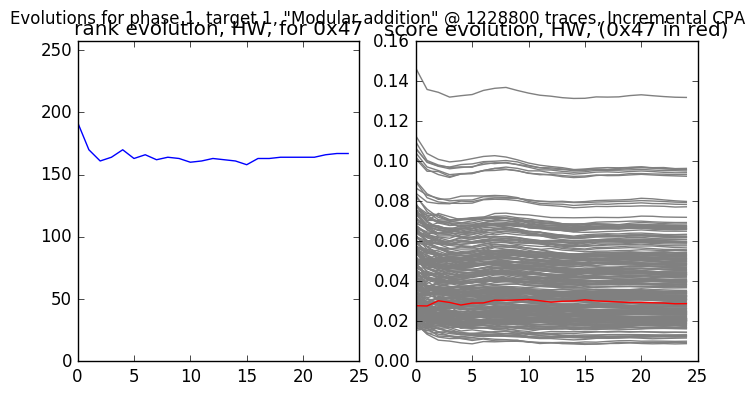

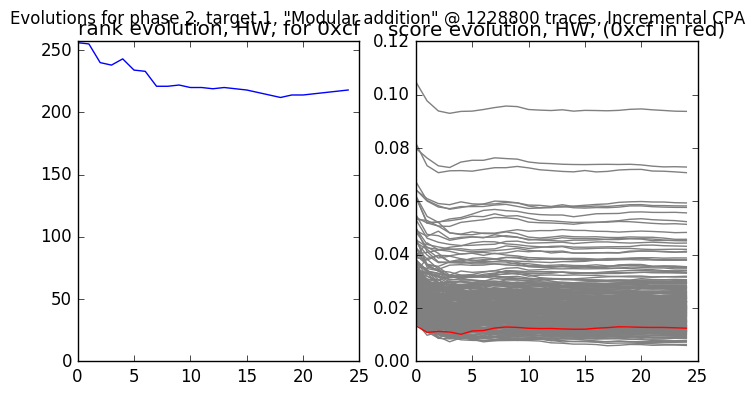

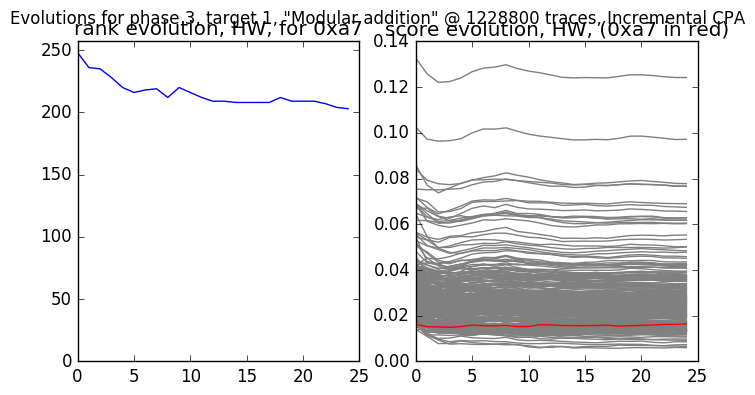

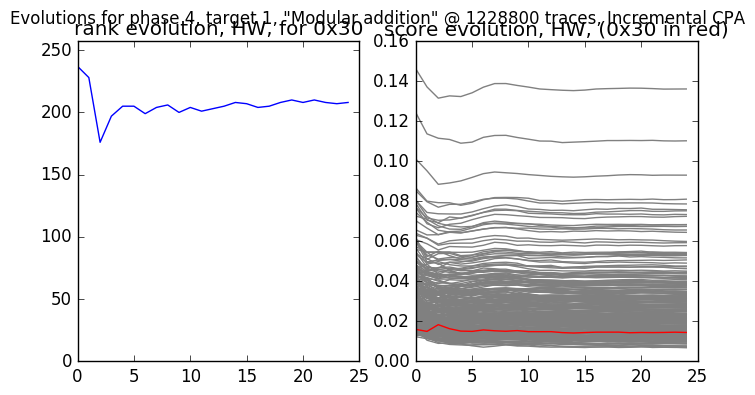

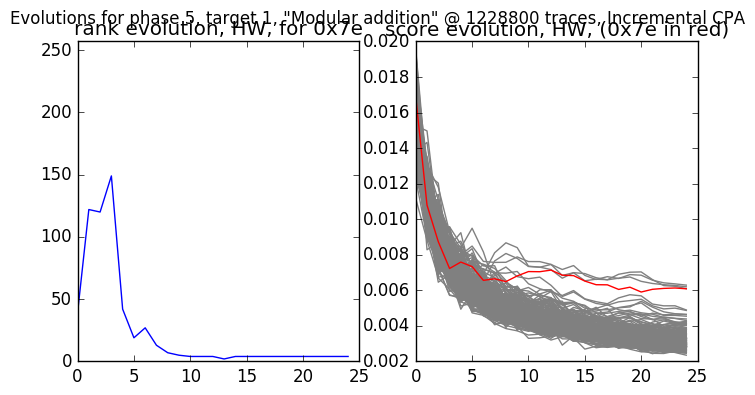

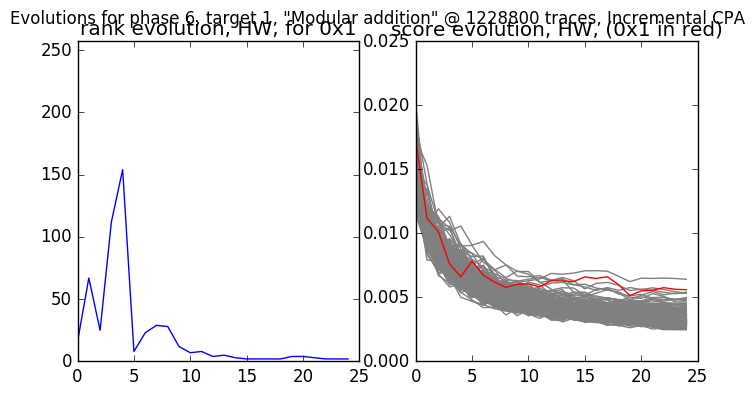

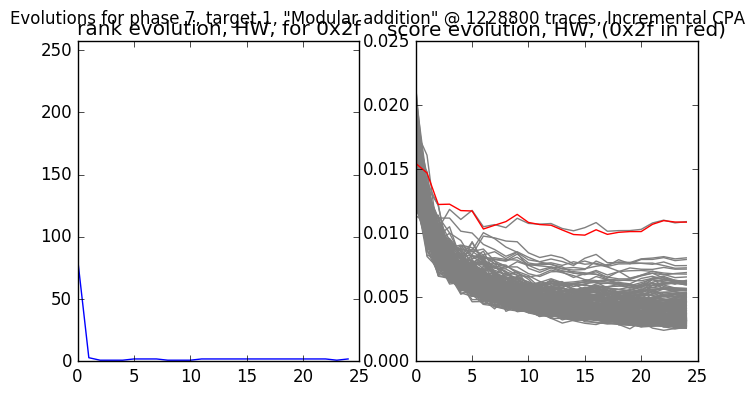

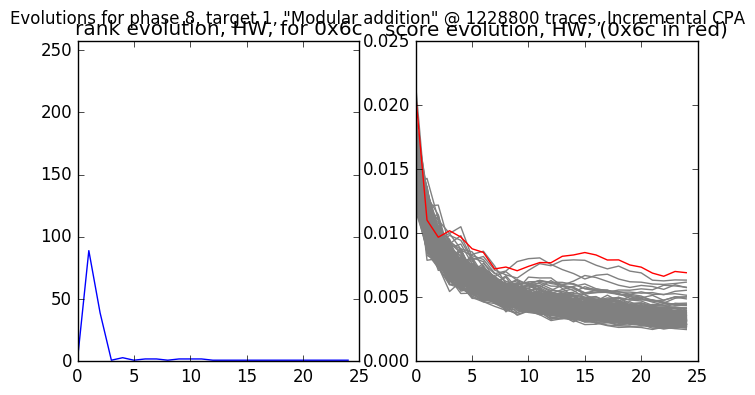

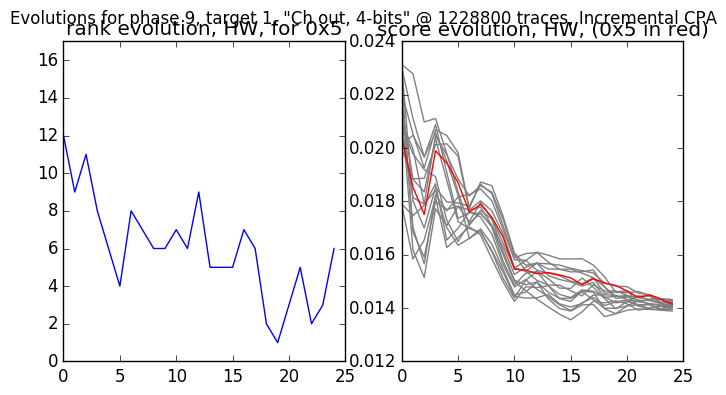

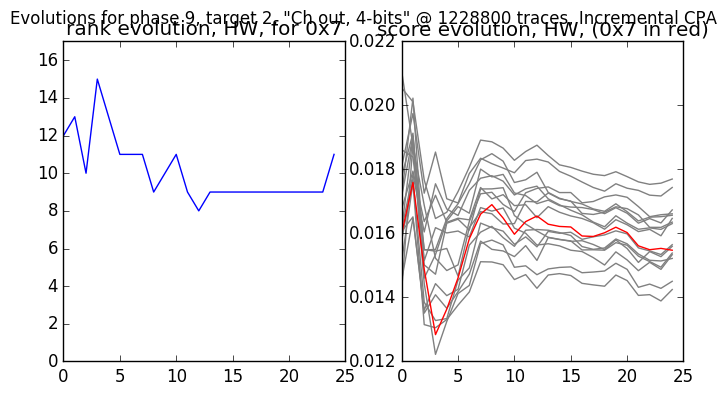

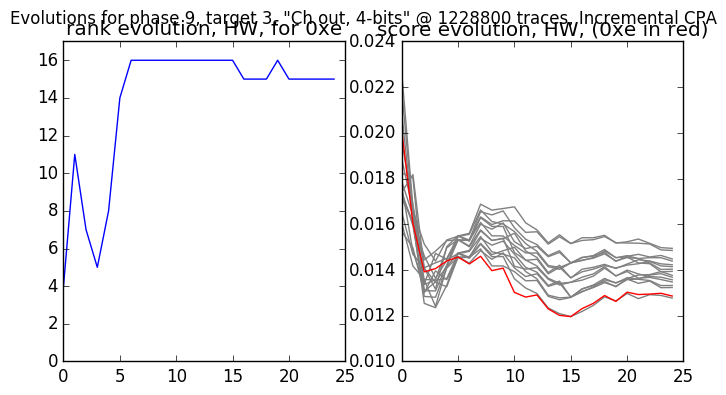

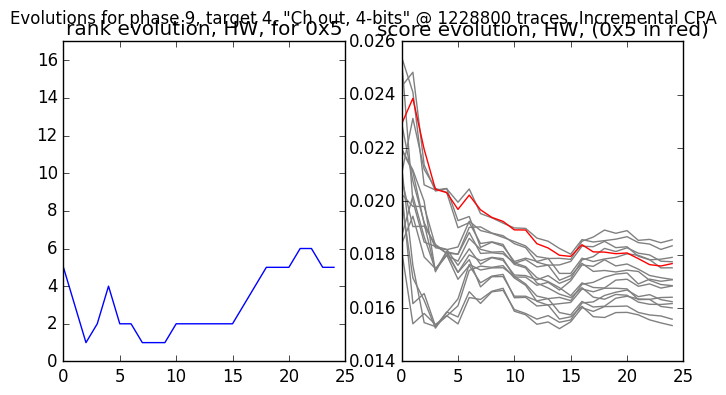

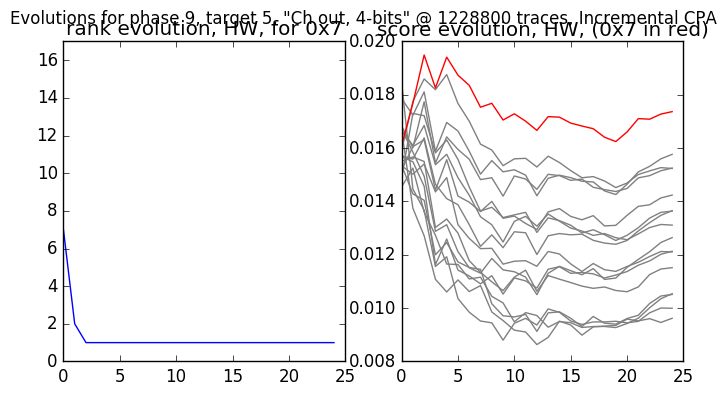

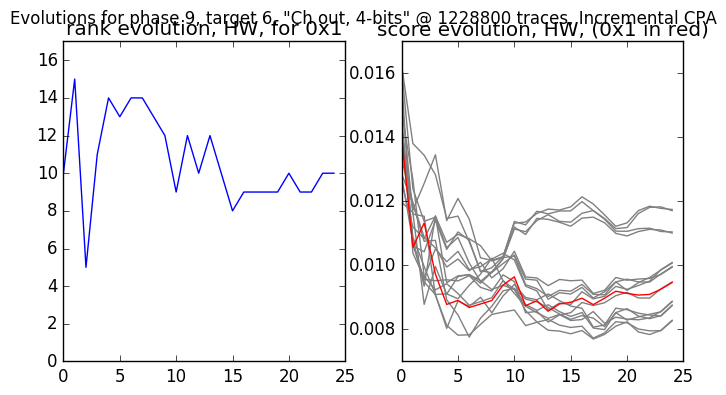

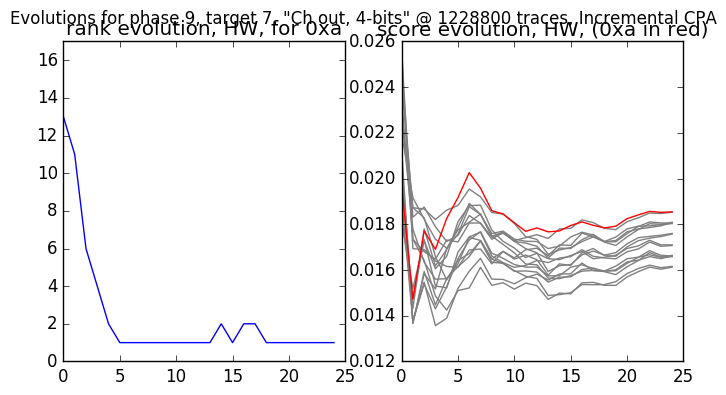

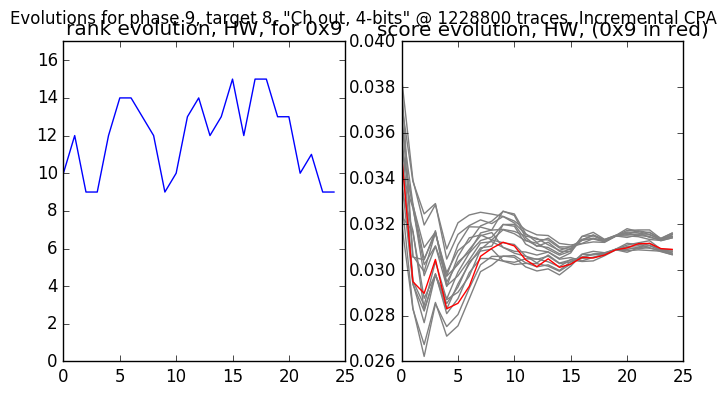

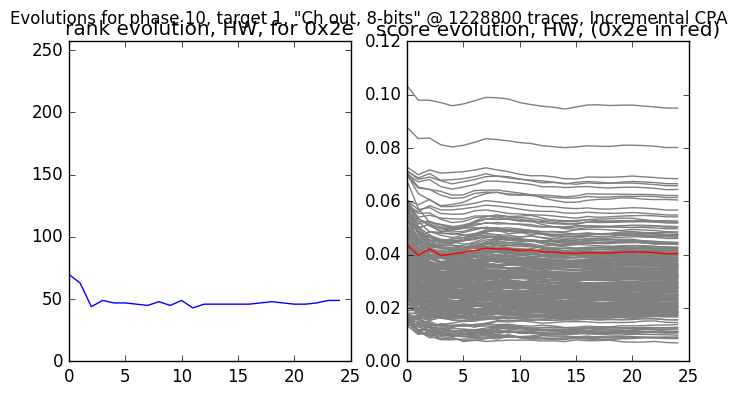

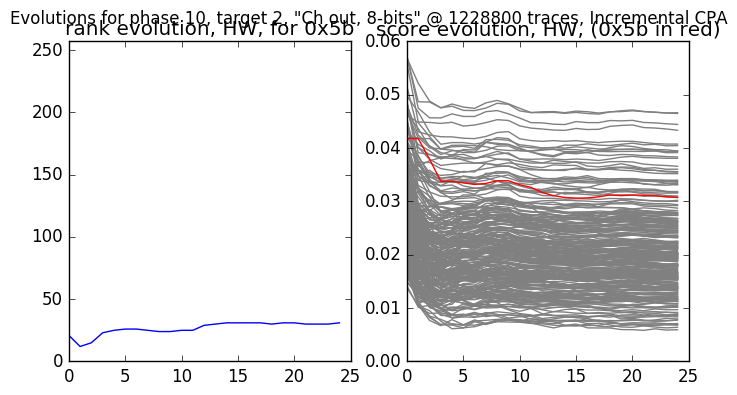

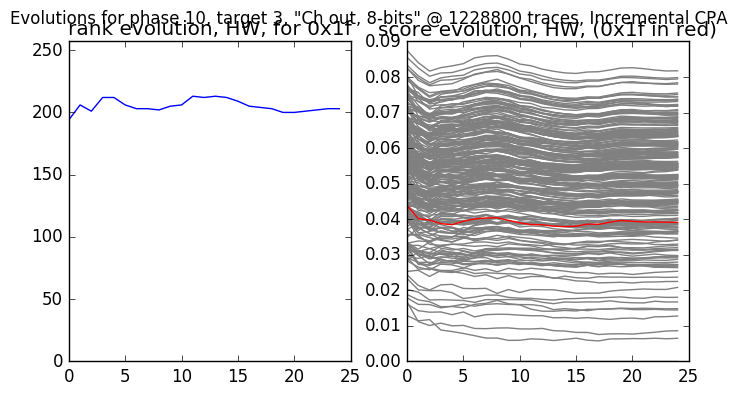

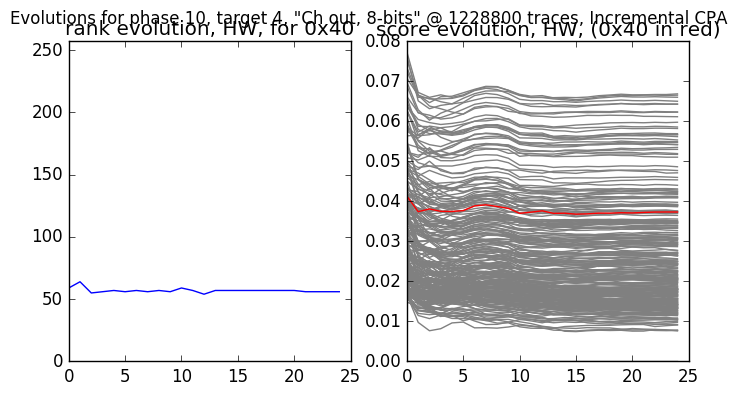

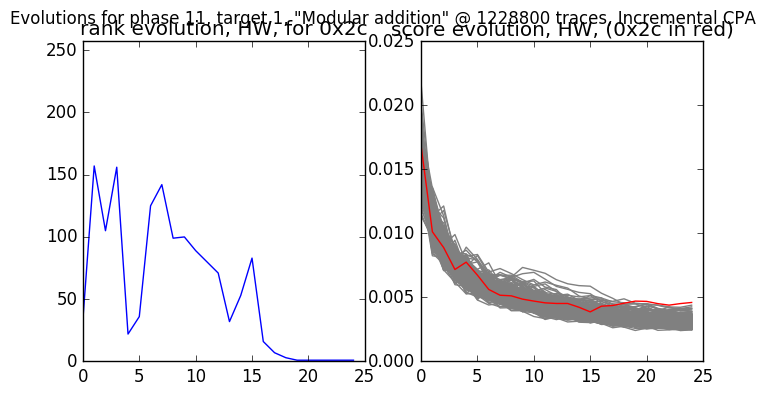

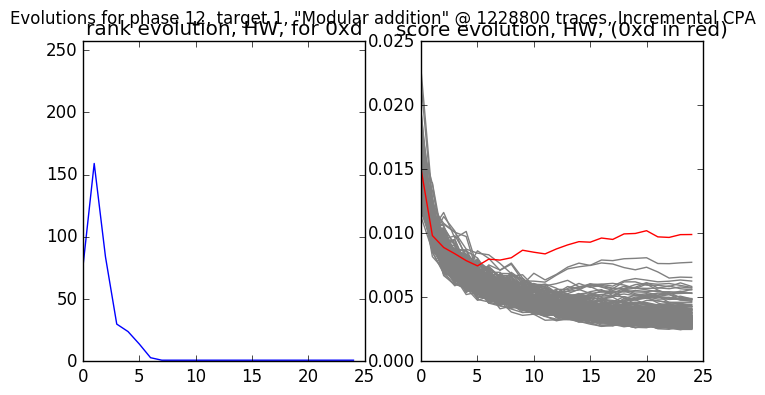

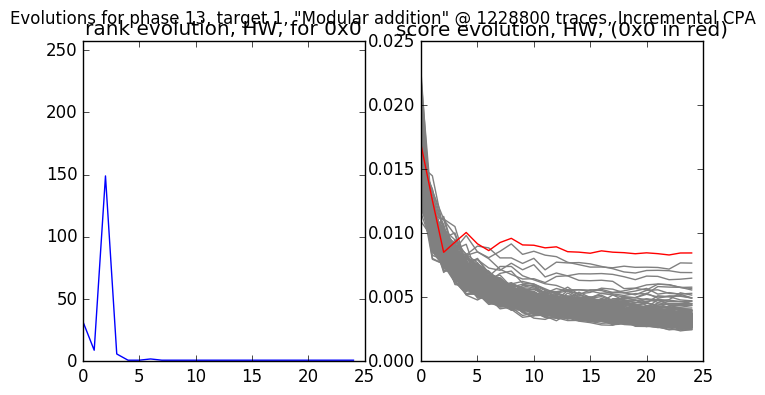

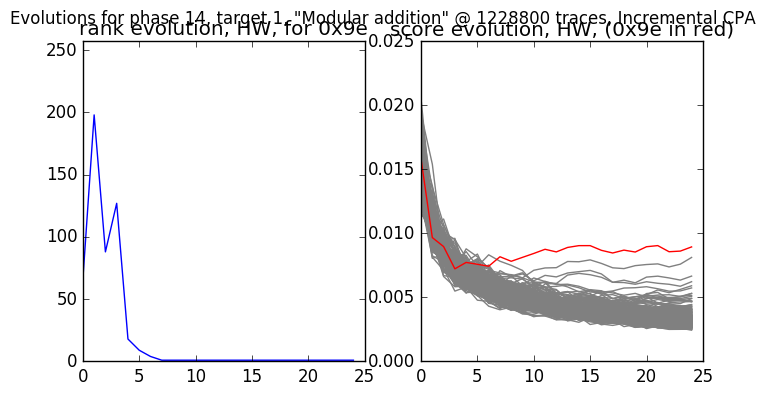

In [17]:
plotAllEvolutions(inccpaparams,inccparankData)

Like previously, we print the scores per sample for phase 5 target 1, and observe that the noise band is lower as compared to conditional averaging, as expected.

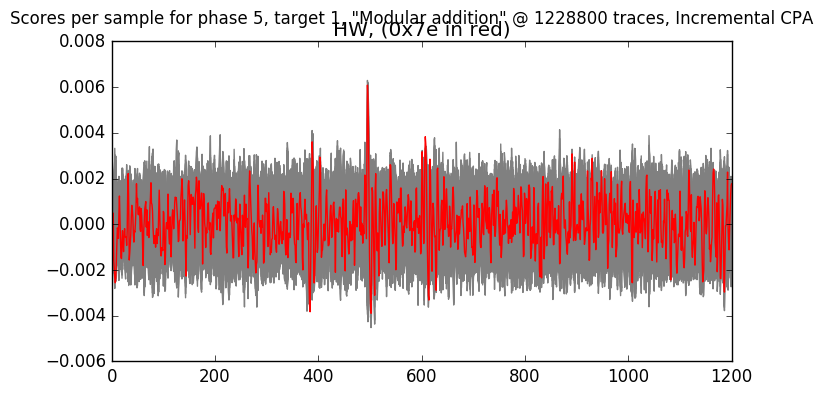

In [18]:
plotScoresPerSample(inccpacorrMatrices,inccparankData,inccpaparams,5,1)

That's all, no key! But I should re-run the acquisition and get > 10M traces, or if you're a student and you're bored, you can do it for me.